# Bike Rental Demand Analysis and Prediction Using Machine Learning

### Problem Statement
* Prepare a complete data analysis report on the given data.
* Prediction of daily bike rental count based on the environmental and seasonal settings

### Dataset characteristics
	
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Load Datasets and Basic Data Exploration

#### Day

In [2]:
# df_day = pd.read_csv("day.csv")

df_day = pd.read_csv(r"C:\Users\jotal\Desktop\projects\Bike Rental Demand Analysis and Prediction\data\day.csv")

In [3]:
df_day.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [4]:
df_day.shape        

(731, 16)

In [5]:
df_day.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [6]:
df_day.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Observation
* The data consists of **731 daily observations** collected over two years **(2011–2012)**.
* It includes weather conditions, seasonal indicators, and rental counts.
* The dataset is clean, contains no missing values, and uses normalized weather variables.
* The **target variable `cnt`** represents total daily rentals.
* Date features are provided but need transformation into day, month, year, and weekday for modeling.

In [7]:
for col in df_day.columns:
    print(col, df_day[col].nunique(), df_day[col].dtype)

instant 731 int64
dteday 731 object
season 4 int64
yr 2 int64
mnth 12 int64
holiday 2 int64
weekday 7 int64
workingday 2 int64
weathersit 3 int64
temp 499 float64
atemp 690 float64
hum 595 float64
windspeed 650 float64
casual 606 int64
registered 679 int64
cnt 696 int64


Observations
* **instant — 731 unique values** - Every row has a unique index → dataset has no duplicate rows.
* **dteday — 731 unique dates** -  Every day between 2011–2012 is included and no repeated dates.
* **season — 4 unique values**
    *  1 = Spring
    *  2 = Summer
    *  3 = Fall
    *  4 = Winter
* **yr — 2 unique values**
    * 0 = 2011
    * 1 = 2012
* **mnth — 12 unique values**
**holiday — 2 values**
    * 0 = not holiday
* **weekday — 7 values** - 0 to 6 (Monday to Sunday)
* **workingday — 2 values**
    * 0 = weekend/holiday
    * 1 = working day
* **temp — 499 unique values** - Normalized values between 0–1.
* **atemp — 690 unique values** - Higher variability compared to temp.
* **hum — 595 unique values** - Humidity is also normalized (0–1).
* **casual — 606 values** - Casual users (non-registered users)
* **registered — 679 values**- Registered users (frequent commuters)
* **cnt — 696 values** - Target variable (total rentals)
---
* `casual`, `registered` - These Two columns cause **data leakage** and MUST be removed before training a prediction model.

In [8]:
df_day.describe().T  

count         mean          std        min          25%  \
instant     731.0   366.000000   211.165812   1.000000   183.500000   
season      731.0     2.496580     1.110807   1.000000     2.000000   
yr          731.0     0.500684     0.500342   0.000000     0.000000   
mnth        731.0     6.519836     3.451913   1.000000     4.000000   
holiday     731.0     0.028728     0.167155   0.000000     0.000000   
weekday     731.0     2.997264     2.004787   0.000000     1.000000   
workingday  731.0     0.683995     0.465233   0.000000     0.000000   
weathersit  731.0     1.395349     0.544894   1.000000     1.000000   
temp        731.0     0.495385     0.183051   0.059130     0.337083   
atemp       731.0     0.474354     0.162961   0.079070     0.337842   
hum         731.0     0.627894     0.142429   0.000000     0.520000   
windspeed   731.0     0.190486     0.077498   0.022392     0.134950   
casual      731.0   848.176471   686.622488   2.000000   315.500000   
registered  731.0  3656.172367  1560.256377  20.000000  2497.000000   
cnt         731.0  4504.348837  1937.211452  22.000000  3152.000000   

                    50%          75%          max  
instant      366.000000   548.500000   731.000000  
season         3.000000     3.000000     4.000000  
yr             1.000000     1.000000     1.000000  
mnth           7.000000    10.000000    12.000000  
holiday        0.000000     0.000000     1.000000  
weekday        3.000000     5.000000     6.000000  
workingday     1.000000     1.000000     1.000000  
weathersit     1.000000     2.000000     3.000000  
temp           0.498333     0.655417     0.861667  
atemp          0.486733     0.608602     0.840896  
hum            0.626667     0.730209     0.972500  
windspeed      0.180975     0.233214     0.507463  
casual       713.000000  1096.000000  3410.000000  
registered  3662.000000  4776.500000  6946.000000  
cnt         4548.000000  5956.000000  8714.000000

observations
* The dataset has **731 records**, covering roughly **two years** (yr mean ≈ 0.5 with values 0 and 1).
* **Temperature and atemp** values are normalized and show moderate variability, with average temp around **0.49**.
* **Humidity** averages around **0.63**, but ranges widely from **0 to 0.97**, indicating diverse weather conditions.
* **Bike rentals** (cnt) vary greatly, with an average of **4504**, but can go as low as **22** and as high as **8714**.
* Registered users form the major share of rentals (mean **3656**) compared to casual users (mean **848**).

In [9]:
df_day.describe(include='object')

dteday
count          731
unique         731
top     2011-01-01
freq             1

In [10]:
df_day.duplicated().sum()

0

Observations
* There are no duplicate values

In [11]:
corr_day = df_day.corr(numeric_only=True)
corr_day

instant    season        yr      mnth   holiday   weekday  \
instant     1.000000  0.412224  0.866025  0.496702  0.016145 -0.000016   
season      0.412224  1.000000 -0.001844  0.831440 -0.010537 -0.003080   
yr          0.866025 -0.001844  1.000000 -0.001792  0.007954 -0.005461   
mnth        0.496702  0.831440 -0.001792  1.000000  0.019191  0.009509   
holiday     0.016145 -0.010537  0.007954  0.019191  1.000000 -0.101960   
weekday    -0.000016 -0.003080 -0.005461  0.009509 -0.101960  1.000000   
workingday -0.004337  0.012485 -0.002013 -0.005901 -0.253023  0.035790   
weathersit -0.021477  0.019211 -0.048727  0.043528 -0.034627  0.031087   
temp        0.150580  0.334315  0.047604  0.220205 -0.028556 -0.000170   
atemp       0.152638  0.342876  0.046106  0.227459 -0.032507 -0.007537   
hum         0.016375  0.205445 -0.110651  0.222204 -0.015937 -0.052232   
windspeed  -0.112620 -0.229046 -0.011817 -0.207502  0.006292  0.014282   
casual      0.275255  0.210399  0.248546  0.123006  0.054274  0.059923   
registered  0.659623  0.411623  0.594248  0.293488 -0.108745  0.057367   
cnt         0.628830  0.406100  0.566710  0.279977 -0.068348  0.067443   

            workingday  weathersit      temp     atemp       hum  windspeed  \
instant      -0.004337   -0.021477  0.150580  0.152638  0.016375  -0.112620   
season        0.012485    0.019211  0.334315  0.342876  0.205445  -0.229046   
yr           -0.002013   -0.048727  0.047604  0.046106 -0.110651  -0.011817   
mnth         -0.005901    0.043528  0.220205  0.227459  0.222204  -0.207502   
holiday      -0.253023   -0.034627 -0.028556 -0.032507 -0.015937   0.006292   
weekday       0.035790    0.031087 -0.000170 -0.007537 -0.052232   0.014282   
workingday    1.000000    0.061200  0.052660  0.052182  0.024327  -0.018796   
weathersit    0.061200    1.000000 -0.120602 -0.121583  0.591045   0.039511   
temp          0.052660   -0.120602  1.000000  0.991702  0.126963  -0.157944   
atemp         0.052182   -0.121583  0.991702  1.000000  0.139988  -0.183643   
hum           0.024327    0.591045  0.126963  0.139988  1.000000  -0.248489   
windspeed    -0.018796    0.039511 -0.157944 -0.183643 -0.248489   1.000000   
casual       -0.518044   -0.247353  0.543285  0.543864 -0.077008  -0.167613   
registered    0.303907   -0.260388  0.540012  0.544192 -0.091089  -0.217449   
cnt           0.061156   -0.297391  0.627494  0.631066 -0.100659  -0.234545   

              casual  registered       cnt  
instant     0.275255    0.659623  0.628830  
season      0.210399    0.411623  0.406100  
yr          0.248546    0.594248  0.566710  
mnth        0.123006    0.293488  0.279977  
holiday     0.054274   -0.108745 -0.068348  
weekday     0.059923    0.057367  0.067443  
workingday -0.518044    0.303907  0.061156  
weathersit -0.247353   -0.260388 -0.297391  
temp        0.543285    0.540012  0.627494  
atemp       0.543864    0.544192  0.631066  
hum        -0.077008   -0.091089 -0.100659  
windspeed  -0.167613   -0.217449 -0.234545  
casual      1.000000    0.395282  0.672804  
registered  0.395282    1.000000  0.945517  
cnt         0.672804    0.945517  1.000000

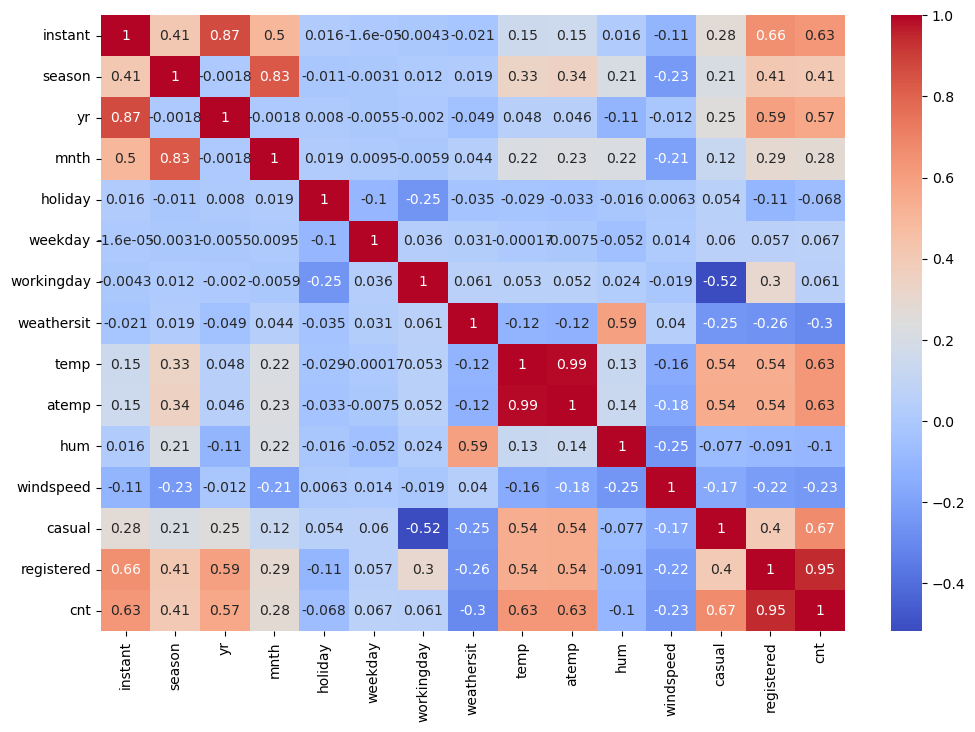

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_day.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

Observations
* **Total rentals (cnt)** are *most strongly correlated* with **registered users (0.95)**, showing that registered riders dominate overall usage.
* **Temperature (temp/atemp)** has a strong positive relationship with total rentals (**≈0.63**), indicating people ride more in warmer weather.
* **Weather situation** (weathersit) shows a *moderate negative correlation* with rentals (**≈ −0.3**), meaning poor weather reduces bike usage.
* **Working days** correlate positively with registered users (**0.30**) but strongly negatively with casual users (**−0.51**), showing casual riders prefer non-working days.
* **Humidity and windspeed** have weak-to-moderate negative correlations with rentals, suggesting higher humidity or wind slightly reduces bike demand.

#### Hour

In [13]:
# df_hour = pd.read_csv("hour.csv")

df_hour = pd.read_csv(r"C:\Users\jotal\Desktop\projects\Bike Rental Demand Analysis and Prediction\data\hour.csv")

In [14]:
df_hour.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [15]:
df_hour.sample(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
11869    11870  2012-05-14       2   1     5  18        0        1   
11122    11123  2012-04-13       2   1     4  15        0        5   
11636    11637  2012-05-05       2   1     5   1        0        6   
6880      6881  2011-10-19       4   0    10   7        0        3   
8563      8564  2011-12-28       1   0    12  14        0        3   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
11869           1           2  0.58  0.5455  0.83     0.0000      17   
11122           1           1  0.54  0.5152  0.28     0.2537     115   
11636           0           1  0.60  0.5606  0.83     0.0000      28   
6880            1           3  0.52  0.5000  0.77     0.2537       1   
8563            1           1  0.32  0.2879  0.39     0.3881      24   

       registered  cnt  
11869         283  300  
11122         237  352  
11636          79  107  
6880           67   68  
8563           96  120

In [16]:
df_hour.shape         

(17379, 17)

In [17]:

df_hour.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [18]:
df_hour.info()        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Observations
* The dataset contains **17,379 rows** and **17 columns**, representing an hourly bike-sharing dataset.
* There is **only one non-numeric column** (`dteday`), which should be converted to datetime for time-series analysis.
* No column has missing values — **all 17 columns have full non-null counts**, so data cleaning for nulls is not needed.
* The dataset includes a mix of categorical and continuous variables
* The target variable **cnt**, along with `casual` and `registered`, is integer-based, making the dataset suitable for regression and time-based modeling.

In [19]:
for col in df_hour.columns:
    print(col, df_hour[col].nunique(), df_hour[col].dtype)

instant 17379 int64
dteday 731 object
season 4 int64
yr 2 int64
mnth 12 int64
hr 24 int64
holiday 2 int64
weekday 7 int64
workingday 2 int64
weathersit 4 int64
temp 50 float64
atemp 65 float64
hum 89 float64
windspeed 30 float64
casual 322 int64
registered 776 int64
cnt 869 int64


Observations
* **dteday has only 731 unique dates**, confirming the dataset spans **731 days** but contains **hourly data** (17379 rows).
* **hr has 24 unique values**, indicating complete hourly coverage for each day.
* Categorical fields like **season (4), yr (2), holiday (2), workingday (2), weekday (7)** show proper encoding and expected ranges.
* Weather-related continuous variables such as **temp, atemp, hum, windspeed** have a wide range of unique values, showing good variability for modeling.
* Target variables **casual, registered, and cnt** also have many unique values (322–869), indicating continuous variation in bike demand.

In [20]:
df_hour.describe().T

count         mean          std   min        25%        50%  \
instant     17379.0  8690.000000  5017.029500  1.00  4345.5000  8690.0000   
season      17379.0     2.501640     1.106918  1.00     2.0000     3.0000   
yr          17379.0     0.502561     0.500008  0.00     0.0000     1.0000   
mnth        17379.0     6.537775     3.438776  1.00     4.0000     7.0000   
hr          17379.0    11.546752     6.914405  0.00     6.0000    12.0000   
holiday     17379.0     0.028770     0.167165  0.00     0.0000     0.0000   
weekday     17379.0     3.003683     2.005771  0.00     1.0000     3.0000   
workingday  17379.0     0.682721     0.465431  0.00     0.0000     1.0000   
weathersit  17379.0     1.425283     0.639357  1.00     1.0000     1.0000   
temp        17379.0     0.496987     0.192556  0.02     0.3400     0.5000   
atemp       17379.0     0.475775     0.171850  0.00     0.3333     0.4848   
hum         17379.0     0.627229     0.192930  0.00     0.4800     0.6300   
windspeed   17379.0     0.190098     0.122340  0.00     0.1045     0.1940   
casual      17379.0    35.676218    49.305030  0.00     4.0000    17.0000   
registered  17379.0   153.786869   151.357286  0.00    34.0000   115.0000   
cnt         17379.0   189.463088   181.387599  1.00    40.0000   142.0000   

                   75%         max  
instant     13034.5000  17379.0000  
season          3.0000      4.0000  
yr              1.0000      1.0000  
mnth           10.0000     12.0000  
hr             18.0000     23.0000  
holiday         0.0000      1.0000  
weekday         5.0000      6.0000  
workingday      1.0000      1.0000  
weathersit      2.0000      4.0000  
temp            0.6600      1.0000  
atemp           0.6212      1.0000  
hum             0.7800      1.0000  
windspeed       0.2537      0.8507  
casual         48.0000    367.0000  
registered    220.0000    886.0000  
cnt           281.0000    977.0000

Observations
* **Hourly bike rentals (cnt)** average around **189**, but vary widely (std ≈ 181), ranging from **1 to 977**, showing strong fluctuations across hours.
* **Registered users contribute more** (mean ≈ 154) than **casual users** (mean ≈ 36), indicating most hourly rentals are from regular riders.
* The **average hour is 12**, with quartiles at 6, 12, and 18 — reflecting a full-day cycle and balanced distribution across hours.
* **Weather variables** (temp, atemp, hum, windspeed) show good variation, important for explaining hourly rental patterns.
* Most days are **working days**, and weather condition **1 (clear)** dominates, as seen from low averages and lower standard deviations in categorical features.

In [21]:
df_hour.describe(include='object')  

dteday
count        17379
unique         731
top     2011-01-01
freq            24

In [22]:
df_hour.duplicated().sum()

0

In [23]:
corr_hour = df_day.corr(numeric_only=True)
corr_hour

instant    season        yr      mnth   holiday   weekday  \
instant     1.000000  0.412224  0.866025  0.496702  0.016145 -0.000016   
season      0.412224  1.000000 -0.001844  0.831440 -0.010537 -0.003080   
yr          0.866025 -0.001844  1.000000 -0.001792  0.007954 -0.005461   
mnth        0.496702  0.831440 -0.001792  1.000000  0.019191  0.009509   
holiday     0.016145 -0.010537  0.007954  0.019191  1.000000 -0.101960   
weekday    -0.000016 -0.003080 -0.005461  0.009509 -0.101960  1.000000   
workingday -0.004337  0.012485 -0.002013 -0.005901 -0.253023  0.035790   
weathersit -0.021477  0.019211 -0.048727  0.043528 -0.034627  0.031087   
temp        0.150580  0.334315  0.047604  0.220205 -0.028556 -0.000170   
atemp       0.152638  0.342876  0.046106  0.227459 -0.032507 -0.007537   
hum         0.016375  0.205445 -0.110651  0.222204 -0.015937 -0.052232   
windspeed  -0.112620 -0.229046 -0.011817 -0.207502  0.006292  0.014282   
casual      0.275255  0.210399  0.248546  0.123006  0.054274  0.059923   
registered  0.659623  0.411623  0.594248  0.293488 -0.108745  0.057367   
cnt         0.628830  0.406100  0.566710  0.279977 -0.068348  0.067443   

            workingday  weathersit      temp     atemp       hum  windspeed  \
instant      -0.004337   -0.021477  0.150580  0.152638  0.016375  -0.112620   
season        0.012485    0.019211  0.334315  0.342876  0.205445  -0.229046   
yr           -0.002013   -0.048727  0.047604  0.046106 -0.110651  -0.011817   
mnth         -0.005901    0.043528  0.220205  0.227459  0.222204  -0.207502   
holiday      -0.253023   -0.034627 -0.028556 -0.032507 -0.015937   0.006292   
weekday       0.035790    0.031087 -0.000170 -0.007537 -0.052232   0.014282   
workingday    1.000000    0.061200  0.052660  0.052182  0.024327  -0.018796   
weathersit    0.061200    1.000000 -0.120602 -0.121583  0.591045   0.039511   
temp          0.052660   -0.120602  1.000000  0.991702  0.126963  -0.157944   
atemp         0.052182   -0.121583  0.991702  1.000000  0.139988  -0.183643   
hum           0.024327    0.591045  0.126963  0.139988  1.000000  -0.248489   
windspeed    -0.018796    0.039511 -0.157944 -0.183643 -0.248489   1.000000   
casual       -0.518044   -0.247353  0.543285  0.543864 -0.077008  -0.167613   
registered    0.303907   -0.260388  0.540012  0.544192 -0.091089  -0.217449   
cnt           0.061156   -0.297391  0.627494  0.631066 -0.100659  -0.234545   

              casual  registered       cnt  
instant     0.275255    0.659623  0.628830  
season      0.210399    0.411623  0.406100  
yr          0.248546    0.594248  0.566710  
mnth        0.123006    0.293488  0.279977  
holiday     0.054274   -0.108745 -0.068348  
weekday     0.059923    0.057367  0.067443  
workingday -0.518044    0.303907  0.061156  
weathersit -0.247353   -0.260388 -0.297391  
temp        0.543285    0.540012  0.627494  
atemp       0.543864    0.544192  0.631066  
hum        -0.077008   -0.091089 -0.100659  
windspeed  -0.167613   -0.217449 -0.234545  
casual      1.000000    0.395282  0.672804  
registered  0.395282    1.000000  0.945517  
cnt         0.672804    0.945517  1.000000

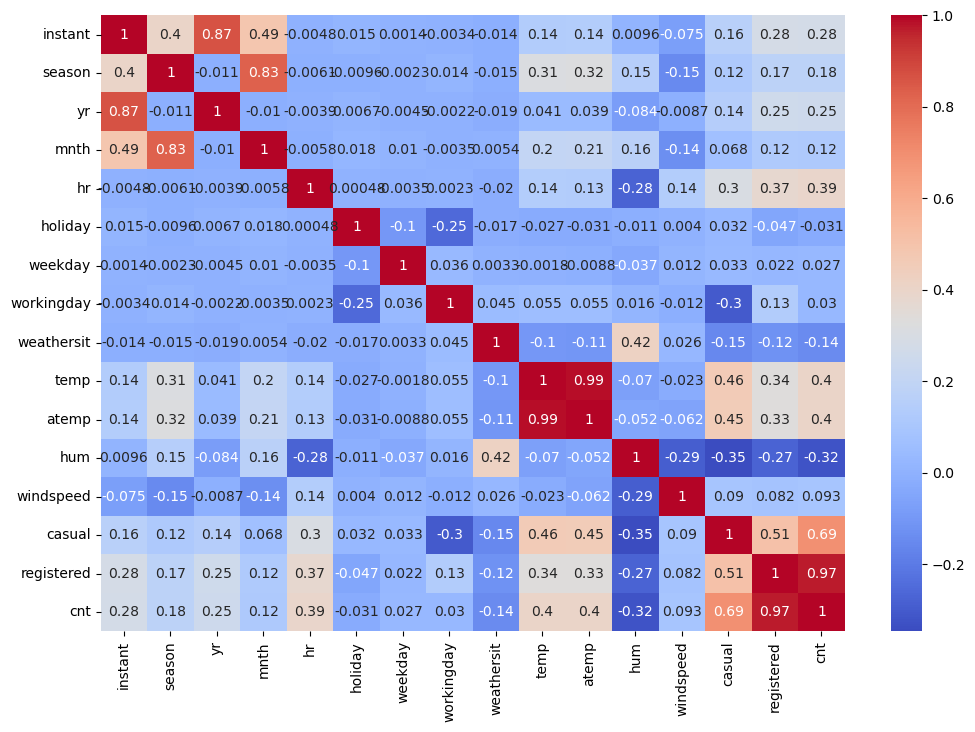

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_hour.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.savefig("hearmap (day).png")
plt.show()

Observations
* **total bike rentals (cnt)** are highly correlated with **registered users** (0.97) and moderately with **casual users** (0.69), highlighting that registered riders dominate the demand.
* Temperature and apparent temperature have **strong positive correlations** with rentals, indicating higher usage in warmer conditions.
* Humidity and windspeed show **moderate negative correlations**, suggesting they reduce bike usage.
* Poor weather conditions (weathersit) also have a **negative impact** on both casual and registered counts.
* Time-related features like season, month, and hour exhibit **moderate correlations**, reflecting predictable temporal patterns in rental demand.

### Combined dataset

In [25]:
# Convert dteday to date (drop time component if any)
df_day['dteday'] = pd.to_datetime(df_day['dteday']).dt.date
df_hour['dteday'] = pd.to_datetime(df_hour['dteday']).dt.date

In [26]:
print("Day shape:", df_day.shape)
print("Hour shape:", df_hour.shape)

Day shape: (731, 16)
Hour shape: (17379, 17)


#### Aggregate hour.csv into daily-level features

In [27]:
daily_from_hour = df_hour.groupby('dteday').agg(
    max_temp_hourly=('temp', 'max'),
    min_temp_hourly=('temp', 'min'),
    max_hum=('hum', 'max'),
    max_wind=('windspeed', 'max'),
    heavy_weather_hours=('weathersit', lambda x: (x >= 3).sum()),
    mist_hours=('weathersit', lambda x: (x == 2).sum()),
).reset_index()

In [28]:
daily_from_hour.head()

dteday  max_temp_hourly  min_temp_hourly  max_hum  max_wind  \
0  2011-01-01             0.46             0.20     0.94    0.2985   
1  2011-01-02             0.46             0.22     1.00    0.4478   
2  2011-01-03             0.26             0.14     0.69    0.4179   
3  2011-01-04             0.30             0.12     0.74    0.3284   
4  2011-01-05             0.30             0.16     0.74    0.3284   

   heavy_weather_hours  mist_hours  
0                    2          10  
1                    5          12  
2                    0           0  
3                    0           1  
4                    0           0

* Aggregation turns noisy hourly data into clean, structured, and meaningful daily features that improve interpretability and model performance
* The aggregated daily dataset captures useful weather-driven patterns by summarizing hourly conditions.
* Maximum and minimum daily temperatures show clear day-to-day variation, which can strongly influence bike rental demand.
* Humidity and windspeed maxima help reflect how unfavourable weather conditions accumulate throughout a day.
* The *heavy_weather_hours* and *mist_hours* features quantify the duration of poor weather, giving the model a richer context than simple categorical weather codes.

#### Merge with the original day.csv

In [29]:
df_combined = df_day.merge(daily_from_hour, on='dteday', how='inner')

In [30]:
print(df_combined.shape)

(731, 22)


In [31]:
df_combined.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp  ...  windspeed  casual  registered   cnt  \
0           2  0.344167  ...   0.160446     331         654   985   
1           2  0.363478  ...   0.248539     131         670   801   
2           1  0.196364  ...   0.248309     120        1229  1349   
3           1  0.200000  ...   0.160296     108        1454  1562   
4           1  0.226957  ...   0.186900      82        1518  1600   

   max_temp_hourly  min_temp_hourly  max_hum  max_wind  heavy_weather_hours  \
0             0.46             0.20     0.94    0.2985                    2   
1             0.46             0.22     1.00    0.4478                    5   
2             0.26             0.14     0.69    0.4179                    0   
3             0.30             0.12     0.74    0.3284                    0   
4             0.30             0.16     0.74    0.3284                    0   

   mist_hours  
0          10  
1          12  
2           0  
3           1  
4           0  

[5 rows x 22 columns]

Observations
* Merging adds **richer weather information** (daily max/min, mist hours, heavy rain hours) that the original day.csv doesn’t contain.
* It helps the model learn **daily-level patterns more accurately** by including detailed hourly summaries.
* Aggregated features capture **extremes and duration** of weather, which strongly affect bike demand.
* Both datasets share the same key (*dteday*), so merging creates a clean, unified daily dataset.
* The final merged file becomes a **more complete and more predictive dataset** for EDA and modeling.

#### Drop leakage columns

In [32]:
df_combined = df_combined.drop(columns=['instant', 'casual', 'registered'])

* The **instant** column is just a row index and does not provide predictive value, so removing it prevents unnecessary noise.
* The **casual** and **registered** columns are components of the target variable **cnt**, so keeping them would cause **data leakage** during model training.
* Dropping them ensures the model only learns from valid input features. This helps improve model reliability and prevents artificially high performance.

#### Saving final combined dataset

In [33]:
# df_combined.to_csv("bike_combined_dataset.csv", index=False)

df_combined.to_csv(r"C:\Users\jotal\Desktop\projects\Bike Rental Demand Analysis and Prediction\data\bike_combined_dataset.csv", index=False)

print("Saved as bike_combined_dataset.csv")

Saved as bike_combined_dataset.csv


In [34]:
df_combined.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'max_temp_hourly', 'min_temp_hourly', 'max_hum', 'max_wind',
       'heavy_weather_hours', 'mist_hours'],
      dtype='object')

### Create time-based features

In [35]:
# Convert dteday back to datetime for parts
df_combined['dteday'] = pd.to_datetime(df_combined['dteday'])

df_combined['day'] = df_combined['dteday'].dt.day
df_combined['month'] = df_combined['dteday'].dt.month
df_combined['year'] = df_combined['dteday'].dt.year
df_combined['dow'] = df_combined['dteday'].dt.weekday  # 0 = Monday

In [36]:
df_combined.head()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0 2011-01-01       1   0     1        0        6           0           2   
1 2011-01-02       1   0     1        0        0           0           2   
2 2011-01-03       1   0     1        0        1           1           1   
3 2011-01-04       1   0     1        0        2           1           1   
4 2011-01-05       1   0     1        0        3           1           1   

       temp     atemp  ...  max_temp_hourly  min_temp_hourly  max_hum  \
0  0.344167  0.363625  ...             0.46             0.20     0.94   
1  0.363478  0.353739  ...             0.46             0.22     1.00   
2  0.196364  0.189405  ...             0.26             0.14     0.69   
3  0.200000  0.212122  ...             0.30             0.12     0.74   
4  0.226957  0.229270  ...             0.30             0.16     0.74   

   max_wind  heavy_weather_hours  mist_hours  day  month  year  dow  
0    0.2985                    2          10    1      1  2011    5  
1    0.4478                    5          12    2      1  2011    6  
2    0.4179                    0           0    3      1  2011    0  
3    0.3284                    0           1    4      1  2011    1  
4    0.3284                    0           0    5      1  2011    2  

[5 rows x 23 columns]

Observations
* Extracting day, month, year, and day-of-week from *dteday* helps the model capture important **seasonal and temporal patterns** in bike usage.
* These features allow the model to learn monthly trends, weekday vs. weekend differences, and yearly growth.
* Converting *dteday* to datetime ensures accurate extraction of these components.
*  Time-based features often improve forecasting performance by revealing **cyclic and periodic behavior**. 

### Advanced feature engineering

In [37]:
df_combined = df_combined.sort_values('dteday')

df_combined['temp_range'] = df_combined['max_temp_hourly'] - df_combined['min_temp_hourly']
df_combined['hum_range'] = df_combined['max_hum'] - df_combined['hum']

df_combined['temp_x_hum'] = df_combined['temp'] * df_combined['hum']
df_combined['temp_x_wind'] = df_combined['temp'] * df_combined['windspeed']
df_combined['hum_x_wind'] = df_combined['hum'] * df_combined['windspeed']

df_combined['is_winter'] = (df_combined['season'] == 1).astype(int)
df_combined['is_summer'] = (df_combined['season'] == 3).astype(int)
df_combined['is_fall']   = (df_combined['season'] == 2).astype(int)
df_combined['is_spring'] = (df_combined['season'] == 4).astype(int)

df_combined['workday_weather'] = df_combined['workingday'] * df_combined['weathersit']
df_combined['is_weekend'] = df_combined['weekday'].isin([0,6]).astype(int)

df_combined['severe_weather_ratio'] = df_combined['heavy_weather_hours'] / 24
df_combined['mist_ratio'] = df_combined['mist_hours'] / 24

df_combined['temp_dev'] = df_combined['temp'] - (
    (df_combined['max_temp_hourly'] + df_combined['min_temp_hourly']) / 2
)

df_combined['cnt_lag1'] = df_combined['cnt'].shift(1)
df_combined['cnt_lag7'] = df_combined['cnt'].shift(7)

df_combined['cnt_lag1'].fillna(method='bfill', inplace=True)
df_combined['cnt_lag7'].fillna(method='bfill', inplace=True)


In [38]:
df_combined['temp_sq'] = df_combined['temp'] ** 2
df_combined['hum_temp_interaction'] = df_combined['hum'] * df_combined['temp']
df_combined['is_weekend'] = df_combined['dow'].isin([5,6]).astype(int)

Observations
* New features (like temp × humidity and temp × wind) to help the model capture **non-linear relationships** between weather factors and bike demand.
* Ranges such as *temp_range* and *hum_range* summarize daily variability, which often affects user behavior more than averages.
* Seasonal and weekend indicator variables allow the model to learn **seasonal patterns and weekend effects** explicitly.
* Lag features (*cnt_lag1*, *cnt_lag7*) incorporate past demand, enabling the model to recognize **temporal trends and autocorrelation**.
* Ratio-based features like *severe_weather_ratio* and *mist_ratio* quantify how much of the day experienced poor weather, improving prediction accuracy.

### EDA (Exploratory Data Analysis)

#### `day.csv` EDA

In [39]:
import os

# Define parent and sub-folder
save_dir = os.path.join("images", "day")

# Create the folders (both parent and sub-folder if they don't exist)
os.makedirs(save_dir, exist_ok=True)

**Distribution of target variable (cnt)**

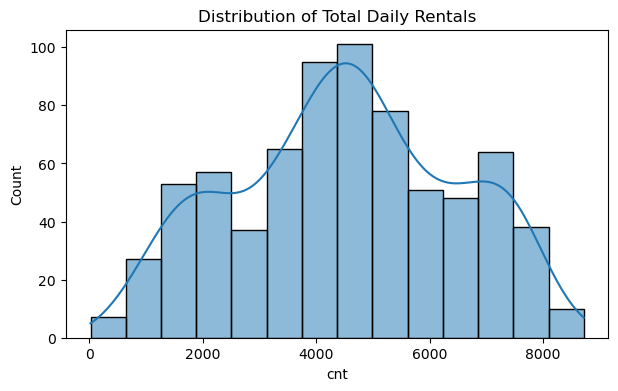

In [40]:
plt.figure(figsize=(7,4))
sns.histplot(df_day['cnt'], kde=True)
plt.title("Distribution of Total Daily Rentals")
plt.savefig(os.path.join(save_dir,"Distribution of Total Daily Rentals.png"))
plt.show()

The distribution of total daily rentals is right-skewed, with most days showing moderate demand and occasional spikes reflecting peak usage conditions.

**Check the rental counts for casual vs registered**

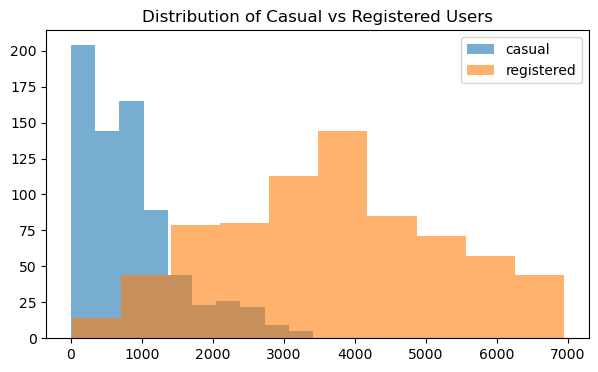

In [41]:
plt.figure(figsize=(7,4))
plt.hist(df_day['casual'], alpha=0.6, label='casual')
plt.hist(df_day['registered'], alpha=0.6, label='registered')
plt.legend()
plt.title("Distribution of Casual vs Registered Users")
plt.savefig(os.path.join(save_dir,"Distribution of Casual vs Registered Users.png"))
plt.show()

The distribution highlights that registered users consistently dominate daily rentals, while casual users contribute smaller but noticeable peaks during weekends and holidays.

**Daily trend (2011–2012)**

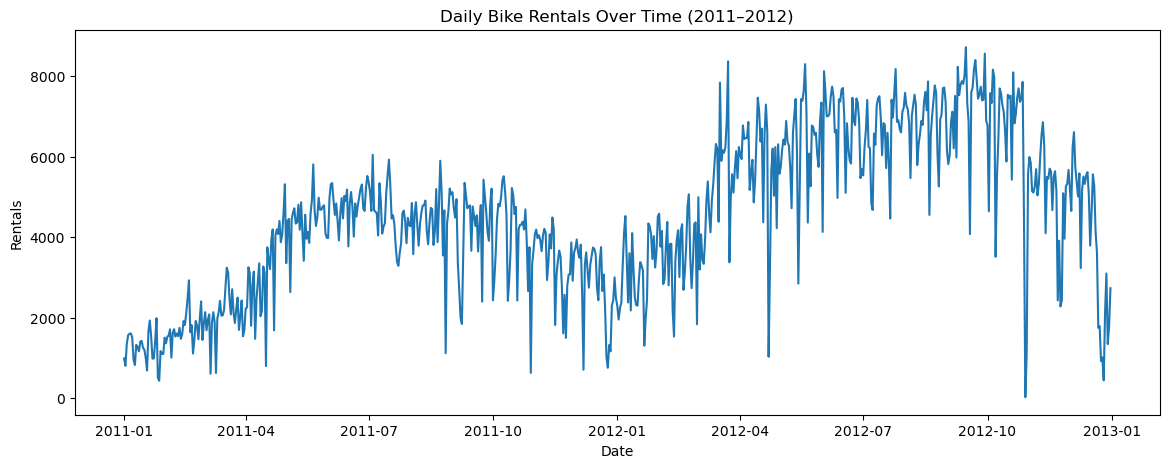

In [42]:
plt.figure(figsize=(14,5))
plt.plot(df_day['dteday'], df_day['cnt'])
plt.title("Daily Bike Rentals Over Time (2011–2012)")
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.savefig(os.path.join(save_dir,"Daily Bike Rentals Over Time (2011–2012).png"))
plt.show()

* Rentals increase steadily through spring and summer, peaking in late summer/early fall.
* Winter months consistently show reduced demand, reflecting weather constraints.
* Overall trend from 2011 to 2012 indicates growth in total rentals, suggesting rising popularity of the service

**Year-wise comparison**

In [43]:
df_day.groupby('yr')['cnt'].mean()

yr
0    3405.761644
1    5599.934426
Name: cnt, dtype: float64

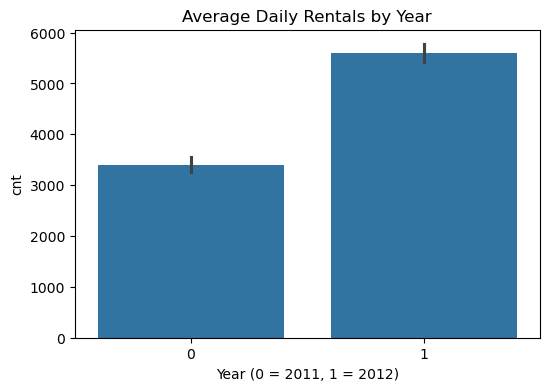

In [44]:
plt.figure(figsize=(6,4))
sns.barplot(x='yr', y='cnt', data=df_day)
plt.title("Average Daily Rentals by Year")
plt.xlabel("Year (0 = 2011, 1 = 2012)")
plt.savefig(os.path.join(save_dir,"Average Daily Rentals by Year.png"))
plt.show()

* 2012 shows higher average rentals compared to 2011, indicating growth in user base and service popularity.
* The upward trend suggests increasing trust and reliance on bike rentals over time.

**Rentals by season**

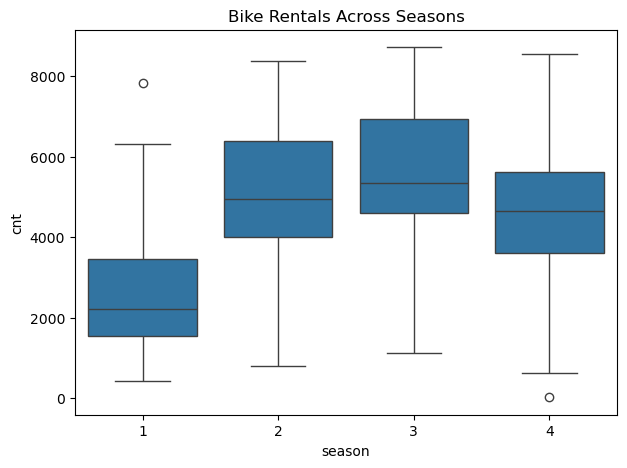

In [45]:
plt.figure(figsize=(7,5))
sns.boxplot(x='season', y='cnt', data=df_day)
plt.title("Bike Rentals Across Seasons")
plt.savefig(os.path.join(save_dir,"Bike Rentals Across Seasons.png"))
plt.show()

* Summer and fall show the highest rental activity, reflecting favorable weather and commuting patterns.
* Spring has moderate demand, marking a transition period.
* Winter consistently records the lowest rentals due to cold and less favorable conditions.
* Seasonal variation is a key driver of demand, highlighting the importance of adjusting resources by season

**Month-wise rentals**

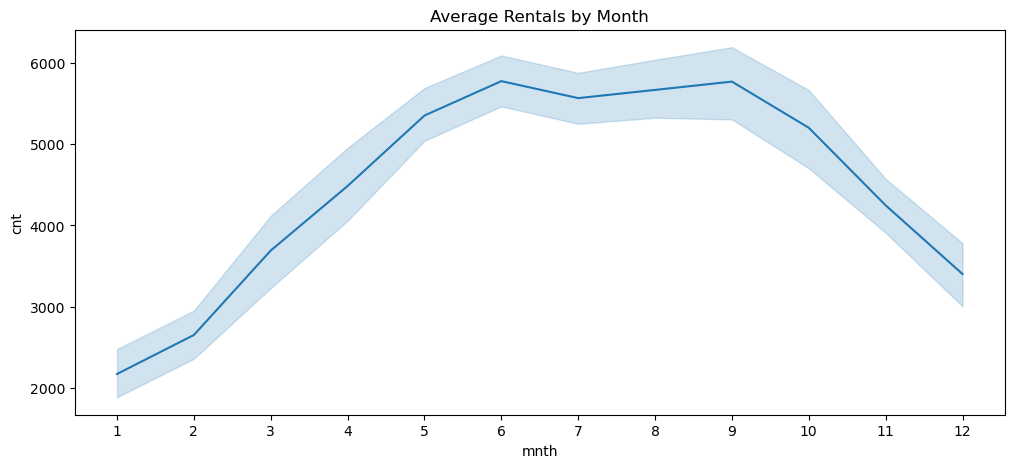

In [46]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_day, x='mnth', y='cnt', estimator='mean')
plt.title("Average Rentals by Month")
plt.xticks(range(1,13))
plt.savefig(os.path.join(save_dir,"Average Rentals by Month.png"))
plt.show()

* June–September show the highest average rentals, reflecting favorable weather and commuting activity.
* Winter months (December–February) consistently record the lowest averages due to cold conditions.
* Spring (March–May) marks a steady rise, while fall (October–November) shows a gradual decline.
* Clear monthly seasonality indicates that weather and seasonal cycles strongly influence rental demand.

**Weekday rentals**

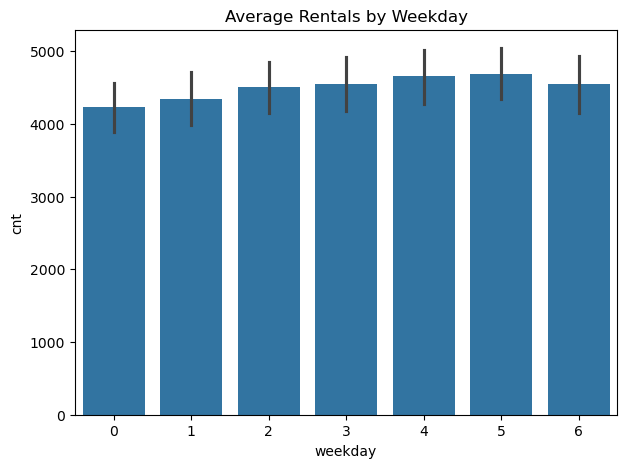

In [47]:
plt.figure(figsize=(7,5))
sns.barplot(x='weekday', y='cnt', data=df_day)
plt.title("Average Rentals by Weekday")
plt.savefig(os.path.join(save_dir,"Average Rentals by Weekday.png"))
plt.show()

* Weekdays (Monday–Friday) show consistently higher average rentals, reflecting commuting behavior.
* Weekends (Saturday–Sunday) record lower averages, indicating reduced work-related demand but possible leisure usage

**Working Day vs Non-Working Day**

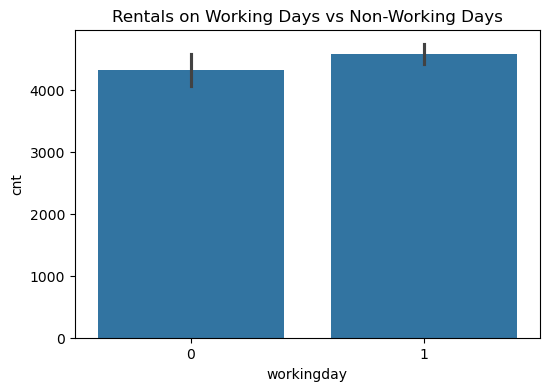

In [48]:
plt.figure(figsize=(6,4))
sns.barplot(x='workingday', y='cnt', data=df_day)
plt.title("Rentals on Working Days vs Non-Working Days")
plt.savefig(os.path.join(save_dir,"Rentals on Working Days vs Non-Working Days.png"))
plt.show()

Bike rentals are significantly higher on working days compared to non-working days, reflecting commuting demand

**Holidays**

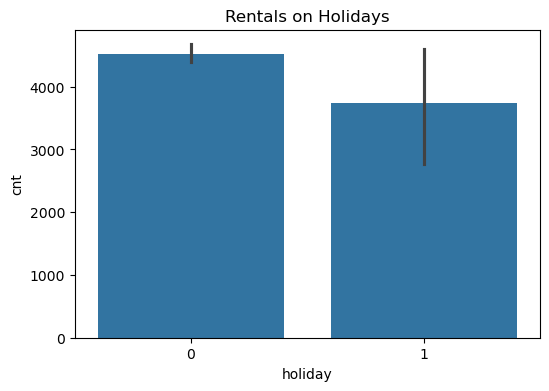

In [49]:
plt.figure(figsize=(6,4))
sns.barplot(x='holiday', y='cnt', data=df_day)
plt.title("Rentals on Holidays")
plt.savefig(os.path.join(save_dir,"Rentals on Holidays.png"))
plt.show()

Bike rentals are lower on holidays compared to regular days, reflecting reduced commuting demand

**Rentals vs Weather Situation**

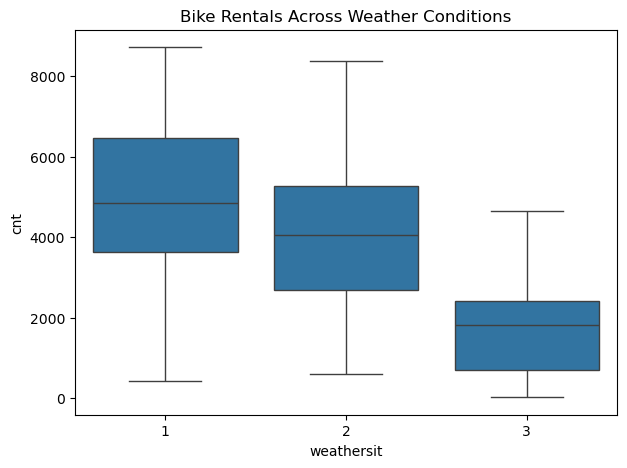

In [50]:
plt.figure(figsize=(7,5))
sns.boxplot(x='weathersit', y='cnt', data=df_day)
plt.title("Bike Rentals Across Weather Conditions")
plt.savefig(os.path.join(save_dir,"Bike Rentals Across Weather Conditions.png"))
plt.show()

Bike rentals are highest in clear weather, decrease in misty conditions, and drop sharply during heavy weather.

**Temperature vs Rentals**

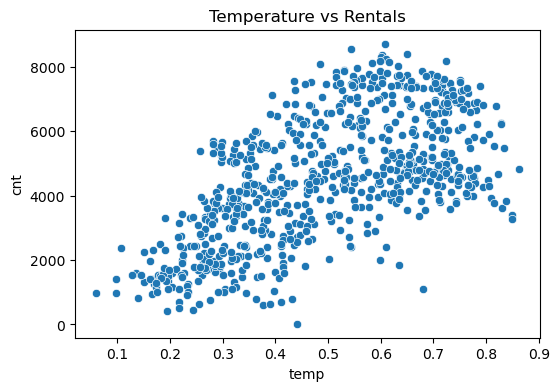

In [51]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='temp', y='cnt', data=df_day)
plt.title("Temperature vs Rentals")
plt.savefig(os.path.join(save_dir,"Temperature vs Rentals.png"))
plt.show()

Bike rentals increase with rising temperatures, showing strong positive correlation between warmth and demand.

**Humidity vs Rentals**

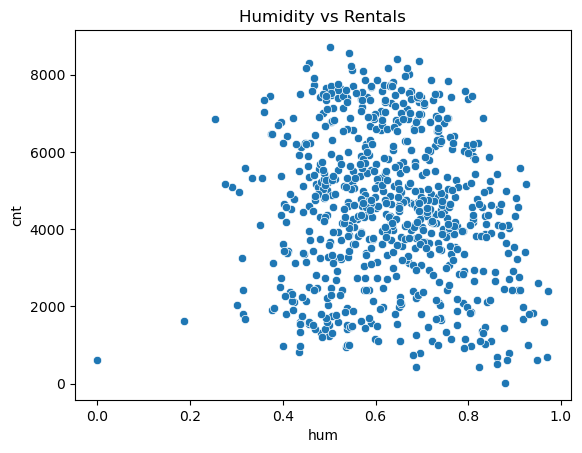

In [52]:
sns.scatterplot(x='hum', y='cnt', data=df_day)
plt.title("Humidity vs Rentals")
plt.savefig(os.path.join(save_dir,"Humidity vs Rentals.png"))
plt.show()

Bike rentals decline as humidity increases, showing a negative correlation between moisture levels and demand

**Windspeed vs Rentals**

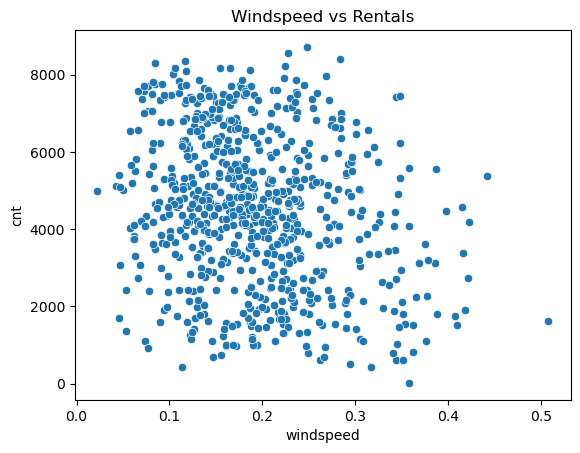

In [53]:
sns.scatterplot(x='windspeed', y='cnt', data=df_day)
plt.title("Windspeed vs Rentals")
plt.savefig(os.path.join(save_dir,"Windspeed vs Rentals.png"))
plt.show()

Bike rentals decline as windspeed increases, showing a negative correlation between wind intensity and demand.

**Correlation Heatmap**

In [54]:
# Convert any datetime columns to numeric values before creating correlation matrix
df_day_numeric = df_day.copy()

# Find columns with datetime.date objects and convert them to numeric values
for col in df_day.columns:
    if df_day[col].dtype == 'object':  # Check for object dtype which might contain datetime objects
        try:
            # Convert dates to ordinal numbers (days since Jan 1, 0001)
            df_day_numeric[col] = pd.to_datetime(df_day[col]).map(lambda x: x.toordinal())
        except:
            # If conversion fails, keep the column as is
            pass

In [55]:
df_day_numeric.corr()

instant    dteday    season        yr      mnth   holiday  \
instant     1.000000  1.000000  0.412224  0.866025  0.496702  0.016145   
dteday      1.000000  1.000000  0.412224  0.866025  0.496702  0.016145   
season      0.412224  0.412224  1.000000 -0.001844  0.831440 -0.010537   
yr          0.866025  0.866025 -0.001844  1.000000 -0.001792  0.007954   
mnth        0.496702  0.496702  0.831440 -0.001792  1.000000  0.019191   
holiday     0.016145  0.016145 -0.010537  0.007954  0.019191  1.000000   
weekday    -0.000016 -0.000016 -0.003080 -0.005461  0.009509 -0.101960   
workingday -0.004337 -0.004337  0.012485 -0.002013 -0.005901 -0.253023   
weathersit -0.021477 -0.021477  0.019211 -0.048727  0.043528 -0.034627   
temp        0.150580  0.150580  0.334315  0.047604  0.220205 -0.028556   
atemp       0.152638  0.152638  0.342876  0.046106  0.227459 -0.032507   
hum         0.016375  0.016375  0.205445 -0.110651  0.222204 -0.015937   
windspeed  -0.112620 -0.112620 -0.229046 -0.011817 -0.207502  0.006292   
casual      0.275255  0.275255  0.210399  0.248546  0.123006  0.054274   
registered  0.659623  0.659623  0.411623  0.594248  0.293488 -0.108745   
cnt         0.628830  0.628830  0.406100  0.566710  0.279977 -0.068348   

             weekday  workingday  weathersit      temp     atemp       hum  \
instant    -0.000016   -0.004337   -0.021477  0.150580  0.152638  0.016375   
dteday     -0.000016   -0.004337   -0.021477  0.150580  0.152638  0.016375   
season     -0.003080    0.012485    0.019211  0.334315  0.342876  0.205445   
yr         -0.005461   -0.002013   -0.048727  0.047604  0.046106 -0.110651   
mnth        0.009509   -0.005901    0.043528  0.220205  0.227459  0.222204   
holiday    -0.101960   -0.253023   -0.034627 -0.028556 -0.032507 -0.015937   
weekday     1.000000    0.035790    0.031087 -0.000170 -0.007537 -0.052232   
workingday  0.035790    1.000000    0.061200  0.052660  0.052182  0.024327   
weathersit  0.031087    0.061200    1.000000 -0.120602 -0.121583  0.591045   
temp       -0.000170    0.052660   -0.120602  1.000000  0.991702  0.126963   
atemp      -0.007537    0.052182   -0.121583  0.991702  1.000000  0.139988   
hum        -0.052232    0.024327    0.591045  0.126963  0.139988  1.000000   
windspeed   0.014282   -0.018796    0.039511 -0.157944 -0.183643 -0.248489   
casual      0.059923   -0.518044   -0.247353  0.543285  0.543864 -0.077008   
registered  0.057367    0.303907   -0.260388  0.540012  0.544192 -0.091089   
cnt         0.067443    0.061156   -0.297391  0.627494  0.631066 -0.100659   

            windspeed    casual  registered       cnt  
instant     -0.112620  0.275255    0.659623  0.628830  
dteday      -0.112620  0.275255    0.659623  0.628830  
season      -0.229046  0.210399    0.411623  0.406100  
yr          -0.011817  0.248546    0.594248  0.566710  
mnth        -0.207502  0.123006    0.293488  0.279977  
holiday      0.006292  0.054274   -0.108745 -0.068348  
weekday      0.014282  0.059923    0.057367  0.067443  
workingday  -0.018796 -0.518044    0.303907  0.061156  
weathersit   0.039511 -0.247353   -0.260388 -0.297391  
temp        -0.157944  0.543285    0.540012  0.627494  
atemp       -0.183643  0.543864    0.544192  0.631066  
hum         -0.248489 -0.077008   -0.091089 -0.100659  
windspeed    1.000000 -0.167613   -0.217449 -0.234545  
casual      -0.167613  1.000000    0.395282  0.672804  
registered  -0.217449  0.395282    1.000000  0.945517  
cnt         -0.234545  0.672804    0.945517  1.000000

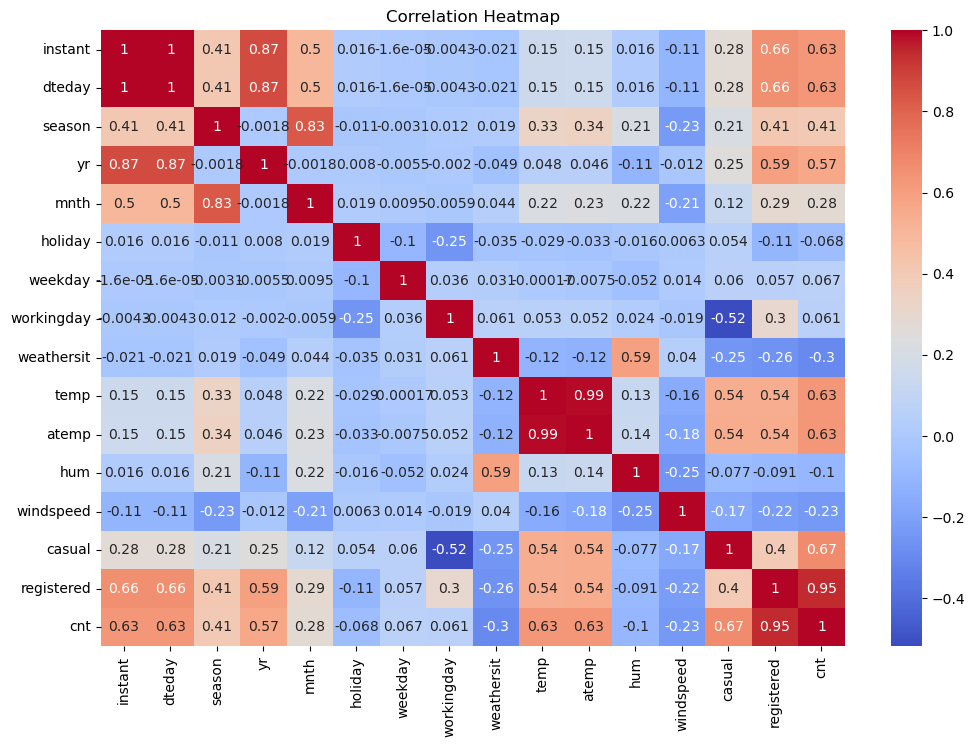

In [56]:
plt.figure(figsize=(12,8))
sns.heatmap(df_day_numeric.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(save_dir,"Correlation Heatmap (Day).png"))
plt.show()

Observations  
- **Registered ↔ Total Rentals (`cnt`)**: Very strong positive correlation (**0.95**), confirming registered users drive most demand.  
- **Casual ↔ Total Rentals**: Moderate correlation (**0.67**), showing casual users contribute but less consistently.  
- **Temperature (`temp`, `atemp`) ↔ Rentals**: Strong positive correlation (~**0.63**), confirming warmer weather boosts demand.  
- **Humidity & Windspeed ↔ Rentals**: Negative correlations (~**-0.10 to -0.23**), showing adverse conditions reduce usage.  
- **Year (`yr`) ↔ Rentals**: Positive correlation (**0.56**), indicating growth in demand from 2011 to 2012.  

#### `hour.csv` EDA

In [57]:
import os

# Define parent and sub-folder
save_dir = os.path.join("images", "hour")

# Create the folders (both parent and sub-folder if they don't exist)
os.makedirs(save_dir, exist_ok=True)

**Distribution of hourly rentals (cnt)**

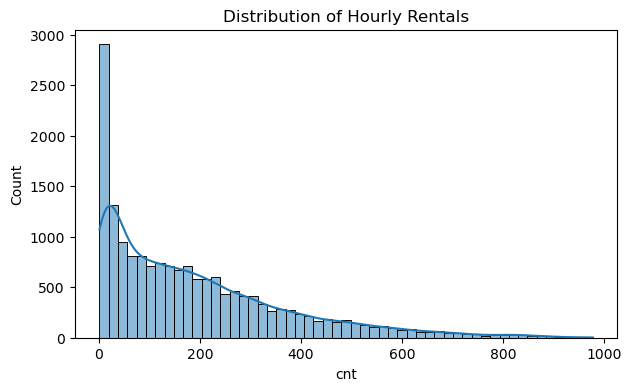

In [58]:
plt.figure(figsize=(7,4))
sns.histplot(df_hour['cnt'], kde=True)
plt.title("Distribution of Hourly Rentals")
plt.savefig(os.path.join(save_dir,"Distribution of Hourly Rentals.png"))
plt.show()

Hourly rentals follow a right‑skewed distribution, with most hours showing moderate demand and occasional peaks.

**Casual vs Registered Hourly Rentals**

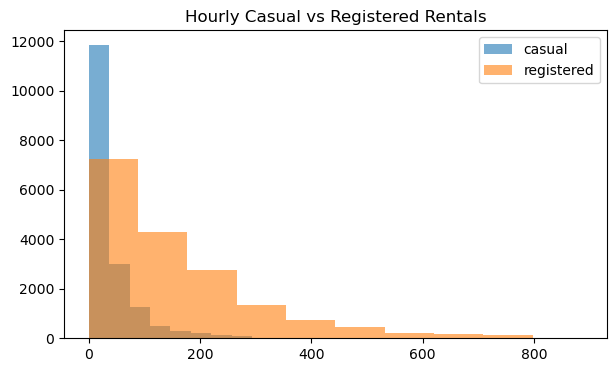

In [59]:
plt.figure(figsize=(7,4))
plt.hist(df_hour['casual'], alpha=0.6, label='casual')
plt.hist(df_hour['registered'], alpha=0.6, label='registered')
plt.legend()
plt.title("Hourly Casual vs Registered Rentals")
plt.savefig(os.path.join(save_dir,"Hourly Casual vs Registered Rentals.png"))
plt.show()


Hourly rentals show distinct patterns: registered users dominate during commuting hours, while casual users peak in leisure periods

**Average rentals by hour (0–23)**

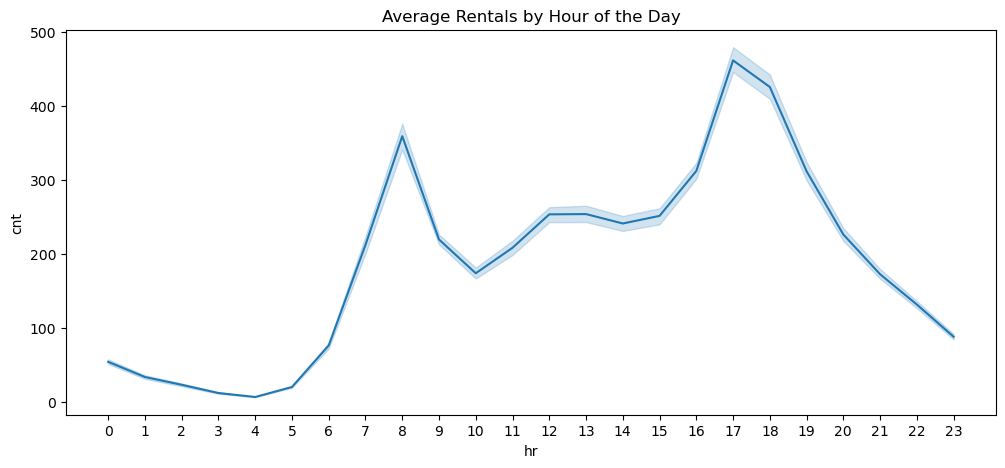

In [60]:
plt.figure(figsize=(12,5))
sns.lineplot(x='hr', y='cnt', data=df_hour, estimator='mean')
plt.title("Average Rentals by Hour of the Day")
plt.xticks(range(0, 24))
plt.savefig(os.path.join(save_dir,"Average Rentals by Hour of the Day.png"))
plt.show()

Observations  
- **Morning peak (8–9 AM)**: Rentals rise sharply, reflecting workday commuting.  
- **Evening peak (5–7 PM)**: Another strong surge, driven by return commutes.  
- **Afternoon (12–4 PM)**: Moderate rentals, often linked to casual or leisure use.  
- **Night/early morning**: Lowest rentals, showing limited demand outside active hours.  

**Hourly pattern for working days vs weekends**

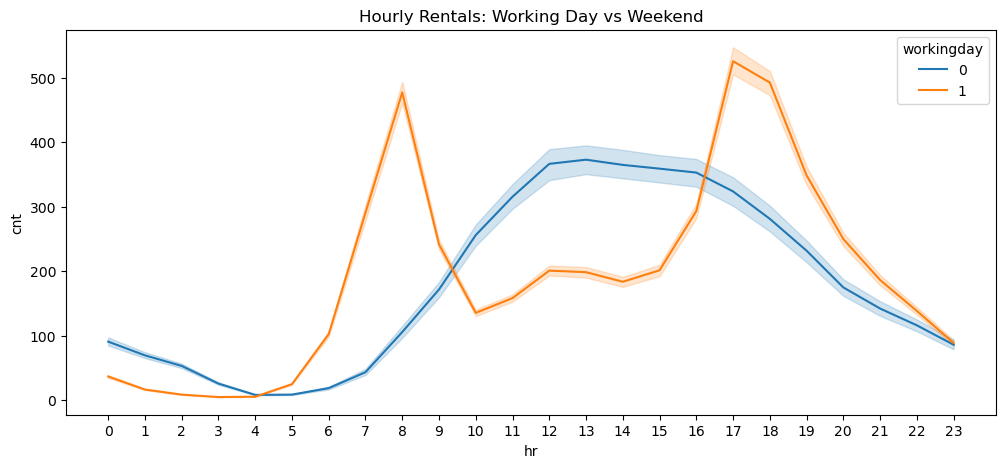

In [61]:
plt.figure(figsize=(12,5))
sns.lineplot(x='hr', y='cnt', hue='workingday', data=df_hour, estimator='mean')
plt.title("Hourly Rentals: Working Day vs Weekend")
plt.xticks(range(0, 24))
plt.savefig(os.path.join(save_dir,"Hourly Rentals: Working Day vs Weekend.png"))
plt.show()

Observations  
- **Working days**: Clear peaks in the **morning (8–9 AM)** and **evening (5–7 PM)**, driven by commuting demand.  
- **Weekends**: Rentals rise gradually through the **afternoon and evening**, reflecting leisure and recreational use. 

**Monthly → Hourly Relationship**

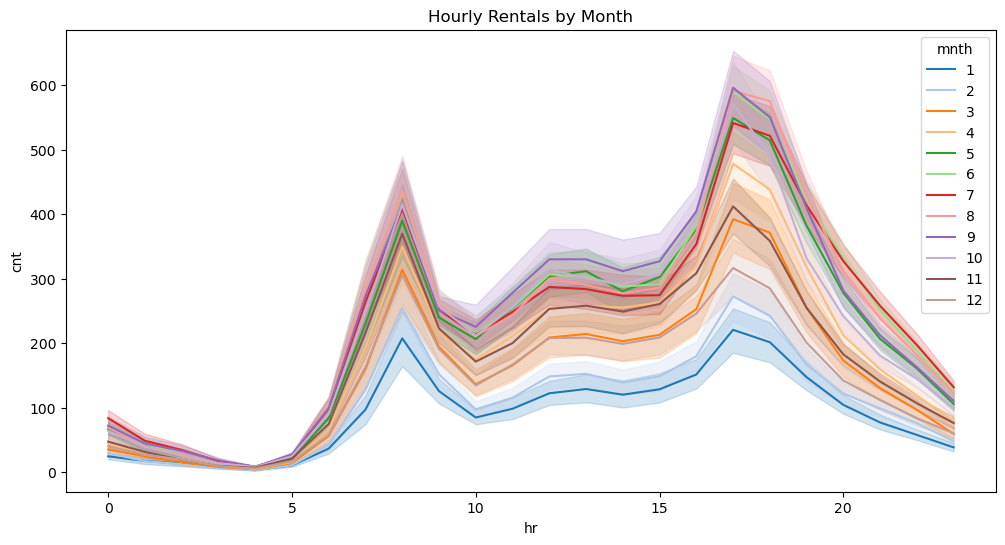

In [62]:
plt.figure(figsize=(12,6))
sns.lineplot(x='hr', y='cnt', hue='mnth', palette='tab20', data=df_hour)
plt.title("Hourly Rentals by Month")
plt.savefig(os.path.join(save_dir,"Hourly Rentals by Month.png"))
plt.show()

Observationa  
- **Summer months (June–September)**: Rentals are consistently higher across most hours, reflecting favorable weather and increased activity.  
- **Winter months (December–February)**: Rentals drop across all hours, showing reduced demand due to cold conditions. 
- **Commuting peaks (8–9 AM, 5–7 PM)** remain visible in most months, but are stronger in warmer seasons.  
- The pattern highlights **seasonality layered on top of daily commuting behavior**.  

**Weekday–Hour Heatmap**

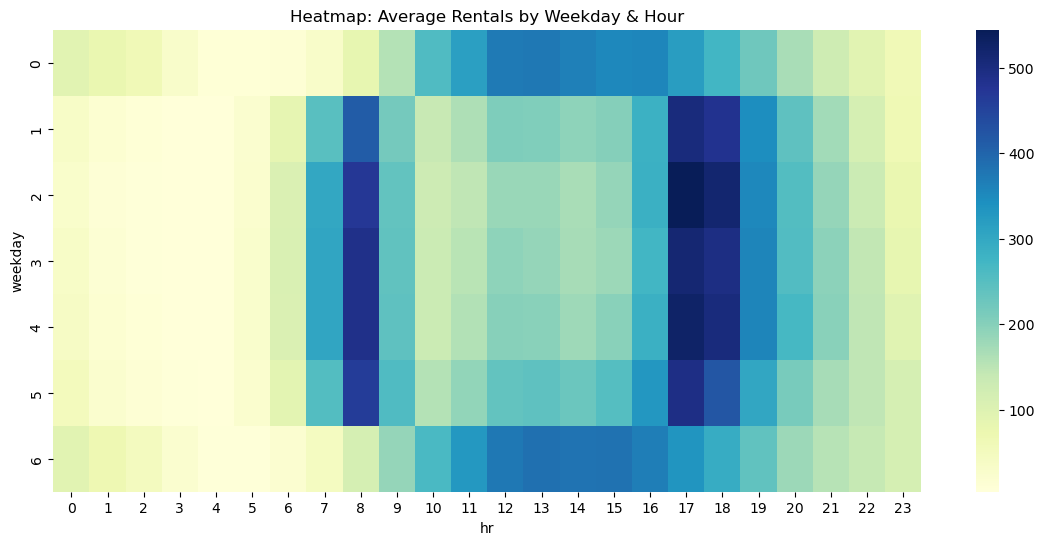

In [63]:
pivot = df_hour.pivot_table(values='cnt', index='weekday', columns='hr', aggfunc='mean')

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Heatmap: Average Rentals by Weekday & Hour")
plt.savefig(os.path.join(save_dir,"Heatmap: Average Rentals by Weekday & Hour.png"))
plt.show()

* Weekdays (Mon–Fri): Clear peaks around 8–9 AM and 5–7 PM, reflecting commuting demand.
* Weekends (Sat–Sun): Rentals rise gradually through the afternoon and evening, showing leisure and recreational use.
* Night/early morning hours: Lowest rentals across all days, highlighting limited demand outside active hours.

**Weather situation vs hourly rentals**

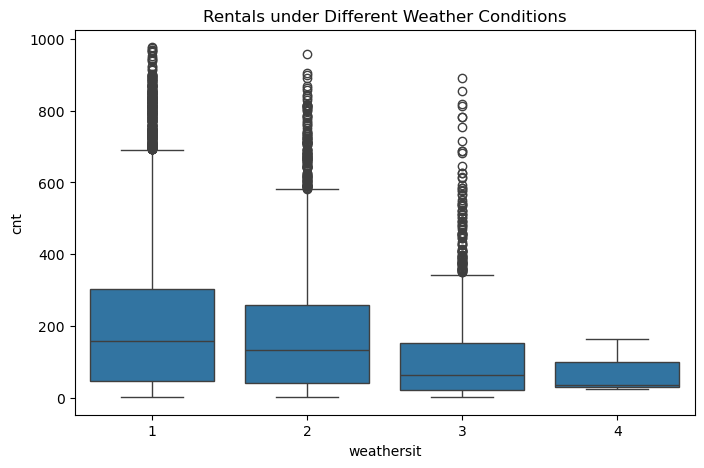

In [64]:
plt.figure(figsize=(8,5))
sns.boxplot(x='weathersit', y='cnt', data=df_hour)
plt.title("Rentals under Different Weather Conditions")
plt.savefig(os.path.join(save_dir,"Rentals under Different Weather Conditions.png"))
plt.show()

Observations  
- **Clear weather**: Highest rental counts, showing strong preference for favorable riding conditions.  
- **Cloudy/misty weather**: Rentals decline moderately, reflecting reduced comfort and visibility.  
- **Heavy weather (rain/snow/storms)**: Rentals drop significantly, confirming strong sensitivity to adverse conditions.  
- Weather conditions are a **critical external driver**, shaping daily demand patterns.  

**Temperature vs rentals**

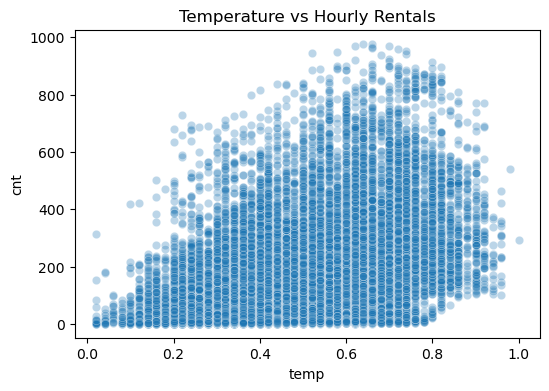

In [65]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='temp', y='cnt', data=df_hour, alpha=0.3)
plt.title("Temperature vs Hourly Rentals")
plt.savefig(os.path.join(save_dir,"Temperature vs Hourly Rentals.png"))
plt.show()

Hourly rentals rise with temperature, showing stronger demand during warmer hours of the day

**Humidity vs rentals**

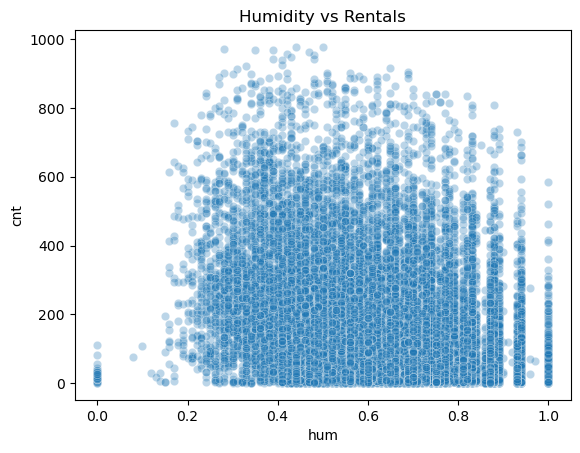

In [66]:
sns.scatterplot(x='hum', y='cnt', data=df_hour, alpha=0.3)
plt.title("Humidity vs Rentals")
plt.savefig(os.path.join(save_dir,"Humidity vs rentals.png"))
plt.show()

Bike rentals decline as humidity increases, showing a negative correlation between moisture levels and demand

**Windspeed vs rentals**

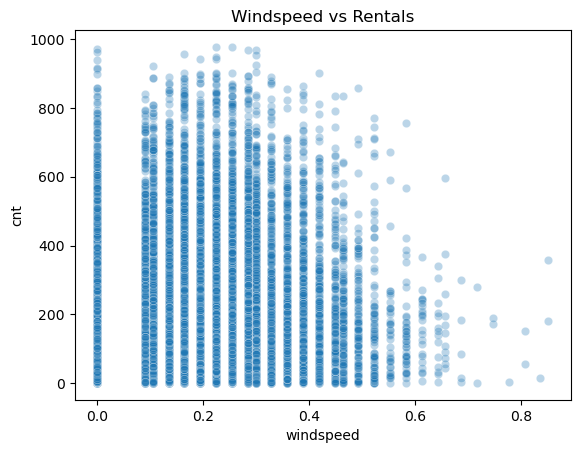

In [67]:
sns.scatterplot(x='windspeed', y='cnt', data=df_hour, alpha=0.3)
plt.title("Windspeed vs Rentals")
plt.savefig(os.path.join(save_dir,"Windspeed vs rentals.png"))
plt.show()

Bike rentals decline as windspeed increases, showing a negative correlation between wind intensity and demand

**Compare Working Day vs Non-Working Day Rentals**

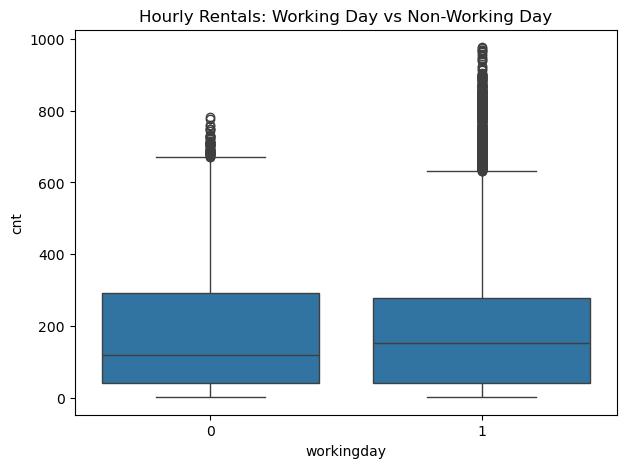

In [68]:
plt.figure(figsize=(7,5))
sns.boxplot(x='workingday', y='cnt', data=df_hour)
plt.title("Hourly Rentals: Working Day vs Non-Working Day")
plt.savefig(os.path.join(save_dir,"Hourly Rentals: Working Day vs Non-Working Day.png"))
plt.show()

Hourly rentals differ between working and non-working days, reflecting commuting vs leisure usage patterns

**Holidays Impact**

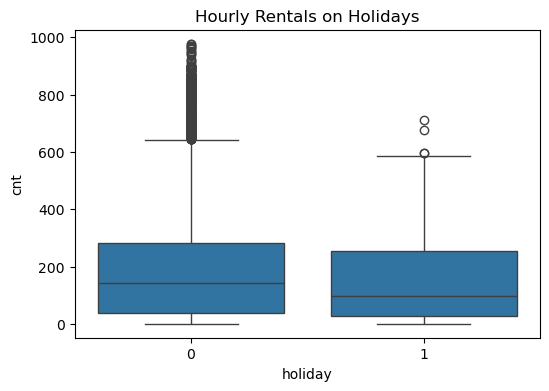

In [69]:
plt.figure(figsize=(6,4))
sns.boxplot(x='holiday', y='cnt', data=df_hour)
plt.title("Hourly Rentals on Holidays")
plt.savefig(os.path.join(save_dir,"Hourly Rentals on Holidays.png"))
plt.show()

**Correlation Heatmap**

In [70]:
# Convert datetime columns to numeric values before creating correlation matrix
df_hour_corr = df_hour.copy()

for col in df_hour_corr.select_dtypes(include=['datetime64', 'datetime64[ns]', 'object']).columns:
    try:
        df_hour_corr[col] = pd.to_datetime(df_hour_corr[col]).astype(int) / 10**9
    except:
        # If conversion fails, drop the column for correlation calculation
        df_hour_corr = df_hour_corr.drop(columns=[col])

In [71]:
df_hour_corr.corr()

instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.404046  0.866014  0.489164 -0.004775  0.014723   
season      0.404046  1.000000 -0.010742  0.830386 -0.006117 -0.009585   
yr          0.866014 -0.010742  1.000000 -0.010473 -0.003867  0.006692   
mnth        0.489164  0.830386 -0.010473  1.000000 -0.005772  0.018430   
hr         -0.004775 -0.006117 -0.003867 -0.005772  1.000000  0.000479   
holiday     0.014723 -0.009585  0.006692  0.018430  0.000479  1.000000   
weekday     0.001357 -0.002335 -0.004485  0.010400 -0.003498 -0.102088   
workingday -0.003416  0.013743 -0.002196 -0.003477  0.002285 -0.252471   
weathersit -0.014198 -0.014524 -0.019157  0.005400 -0.020203 -0.017036   
temp        0.136178  0.312025  0.040913  0.201691  0.137603 -0.027340   
atemp       0.137615  0.319380  0.039222  0.208096  0.133750 -0.030973   
hum         0.009577  0.150625 -0.083546  0.164411 -0.276498 -0.010588   
windspeed  -0.074505 -0.149773 -0.008740 -0.135386  0.137252  0.003988   
casual      0.158295  0.120206  0.142779  0.068457  0.301202  0.031564   
registered  0.282046  0.174226  0.253684  0.122273  0.374141 -0.047345   
cnt         0.278379  0.178056  0.250495  0.120638  0.394071 -0.030927   

             weekday  workingday  weathersit      temp     atemp       hum  \
instant     0.001357   -0.003416   -0.014198  0.136178  0.137615  0.009577   
season     -0.002335    0.013743   -0.014524  0.312025  0.319380  0.150625   
yr         -0.004485   -0.002196   -0.019157  0.040913  0.039222 -0.083546   
mnth        0.010400   -0.003477    0.005400  0.201691  0.208096  0.164411   
hr         -0.003498    0.002285   -0.020203  0.137603  0.133750 -0.276498   
holiday    -0.102088   -0.252471   -0.017036 -0.027340 -0.030973 -0.010588   
weekday     1.000000    0.035955    0.003311 -0.001795 -0.008821 -0.037158   
workingday  0.035955    1.000000    0.044672  0.055390  0.054667  0.015688   
weathersit  0.003311    0.044672    1.000000 -0.102640 -0.105563  0.418130   
temp       -0.001795    0.055390   -0.102640  1.000000  0.987672 -0.069881   
atemp      -0.008821    0.054667   -0.105563  0.987672  1.000000 -0.051918   
hum        -0.037158    0.015688    0.418130 -0.069881 -0.051918  1.000000   
windspeed   0.011502   -0.011830    0.026226 -0.023125 -0.062336 -0.290105   
casual      0.032721   -0.300942   -0.152628  0.459616  0.454080 -0.347028   
registered  0.021578    0.134326   -0.120966  0.335361  0.332559 -0.273933   
cnt         0.026900    0.030284   -0.142426  0.404772  0.400929 -0.322911   

            windspeed    casual  registered       cnt  
instant     -0.074505  0.158295    0.282046  0.278379  
season      -0.149773  0.120206    0.174226  0.178056  
yr          -0.008740  0.142779    0.253684  0.250495  
mnth        -0.135386  0.068457    0.122273  0.120638  
hr           0.137252  0.301202    0.374141  0.394071  
holiday      0.003988  0.031564   -0.047345 -0.030927  
weekday      0.011502  0.032721    0.021578  0.026900  
workingday  -0.011830 -0.300942    0.134326  0.030284  
weathersit   0.026226 -0.152628   -0.120966 -0.142426  
temp        -0.023125  0.459616    0.335361  0.404772  
atemp       -0.062336  0.454080    0.332559  0.400929  
hum         -0.290105 -0.347028   -0.273933 -0.322911  
windspeed    1.000000  0.090287    0.082321  0.093234  
casual       0.090287  1.000000    0.506618  0.694564  
registered   0.082321  0.506618    1.000000  0.972151  
cnt          0.093234  0.694564    0.972151  1.000000

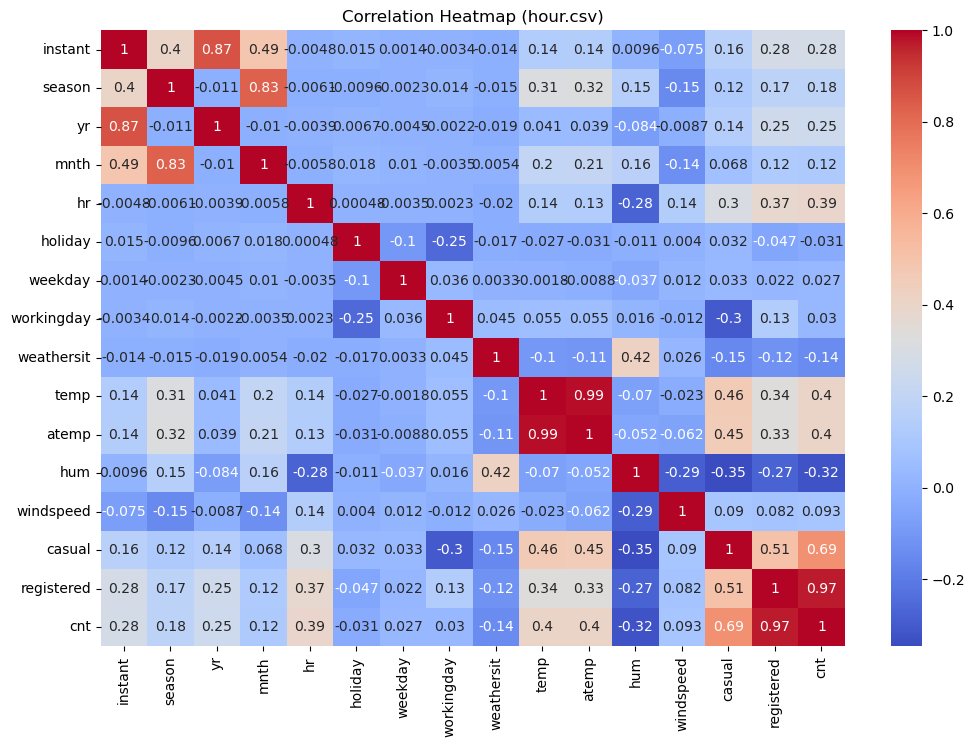

In [72]:
plt.figure(figsize=(12,8))
sns.heatmap(df_hour_corr.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap (hour.csv)")
plt.savefig(os.path.join(save_dir,"Correlation Heatmap (hour).png"))
plt.show()

Observations  
- **Registered ↔ Total Rentals (`cnt`)**: Extremely strong positive correlation (**0.97**), confirming registered users dominate hourly demand.  
- **Casual ↔ Total Rentals**: Strong correlation (**0.69**), showing casual users contribute significantly, especially in leisure hours.  
- **Hour (`hr`) ↔ Rentals**: Moderate positive correlation (**0.39**), reflecting commuting peaks and time‑of‑day effects.  
- **Temperature (`temp`, `atemp`) ↔ Rentals**: Strong positive correlation (~**0.40**), confirming warmer hours boost demand.  
- **Humidity ↔ Rentals**: Negative correlation (**-0.32**), showing discomfort reduces hourly usage.  
- **Windspeed ↔ Rentals**: Slight negative correlation (~**0.09**), weaker but still limiting demand.  
- **Weather Situation ↔ Rentals**: Negative correlation (**-0.14**), adverse conditions reduce demand.  
- **Year (`yr`) ↔ Rentals**: Positive correlation (**0.25**), indicating growth in demand over time.  

#### Combined Dataset EDA

In [73]:
import os

# Define parent and sub-folder
save_dir = os.path.join("images", "combined")

# Create the folders (both parent and sub-folder if they don't exist)
os.makedirs(save_dir, exist_ok=True)


**Target Variable Distribution**

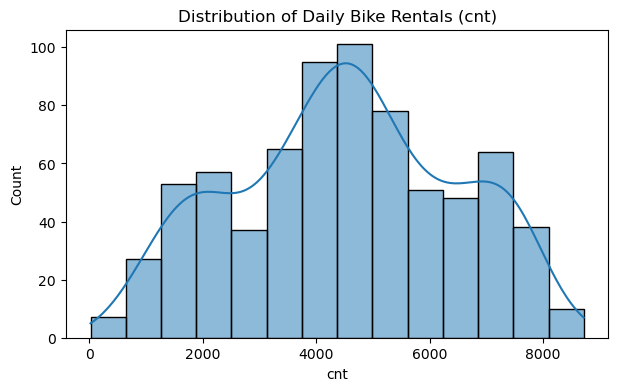

In [74]:
plt.figure(figsize=(7,4))
sns.histplot(df_combined['cnt'], kde=True)
plt.title("Distribution of Daily Bike Rentals (cnt)")
plt.savefig(os.path.join(save_dir,"cnt_distribution"))
plt.show()

Daily rentals are right‑skewed, with steady demand and occasional peaks driven by seasonality and events.

**Correlation Heatmap**

In [75]:
df_combined.corr()

dteday    season        yr      mnth   holiday  \
dteday                1.000000  0.412224  0.866025  0.496702  0.016145   
season                0.412224  1.000000 -0.001844  0.831440 -0.010537   
yr                    0.866025 -0.001844  1.000000 -0.001792  0.007954   
mnth                  0.496702  0.831440 -0.001792  1.000000  0.019191   
holiday               0.016145 -0.010537  0.007954  0.019191  1.000000   
weekday              -0.000016 -0.003080 -0.005461  0.009509 -0.101960   
workingday           -0.004337  0.012485 -0.002013 -0.005901 -0.253023   
weathersit           -0.021477  0.019211 -0.048727  0.043528 -0.034627   
temp                  0.150580  0.334315  0.047604  0.220205 -0.028556   
atemp                 0.152638  0.342876  0.046106  0.227459 -0.032507   
hum                   0.016375  0.205445 -0.110651  0.222204 -0.015937   
windspeed            -0.112620 -0.229046 -0.011817 -0.207502  0.006292   
cnt                   0.628830  0.406100  0.566710  0.279977 -0.068348   
max_temp_hourly       0.144872  0.315349  0.053435  0.199125 -0.019153   
min_temp_hourly       0.160539  0.352177  0.045709  0.242262 -0.042968   
max_hum              -0.020648  0.136131 -0.107506  0.143814  0.007768   
max_wind             -0.127166 -0.255111 -0.024617 -0.212151  0.008008   
heavy_weather_hours  -0.050833 -0.020508 -0.055411 -0.005268 -0.043442   
mist_hours            0.035709 -0.003930  0.024053  0.030819  0.009141   
day                   0.047990 -0.000861  0.002061  0.009157 -0.010710   
month                 0.496702  0.831440 -0.001792  1.000000  0.019191   
year                  0.866025 -0.001844  1.000000 -0.001792  0.007954   
dow                  -0.000016 -0.007993 -0.001368  0.003159 -0.188274   
temp_range           -0.007770 -0.024578  0.035127 -0.071451  0.062195   
hum_range            -0.065471 -0.143029  0.018347 -0.160571  0.042559   
temp_x_hum            0.118856  0.361433 -0.021852  0.275809 -0.021884   
temp_x_wind           0.022431  0.088996  0.013773  0.019789 -0.031352   
hum_x_wind           -0.094965 -0.089158 -0.075674 -0.063717 -0.008175   
is_winter            -0.280863 -0.773422  0.002385 -0.569733  0.034158   
is_summer             0.098988  0.266851 -0.000805  0.199855 -0.026247   
is_fall              -0.158036 -0.259456 -0.000793 -0.314015 -0.024265   
is_spring             0.341448  0.768398 -0.000776  0.686954  0.016915   
workday_weather      -0.015436  0.029045 -0.040836  0.038737 -0.207731   
is_weekend           -0.001504 -0.008938 -0.000869 -0.001021 -0.109187   
severe_weather_ratio -0.050833 -0.020508 -0.055411 -0.005268 -0.043442   
mist_ratio            0.035709 -0.003930  0.024053  0.030819  0.009141   
temp_dev             -0.061190 -0.059008 -0.042015 -0.045359  0.035581   
cnt_lag1              0.634240  0.412378  0.566645  0.291250 -0.051534   
cnt_lag7              0.678474  0.441003  0.568905  0.370234 -0.032342   
temp_sq               0.118660  0.293239  0.033869  0.179761 -0.022346   
hum_temp_interaction  0.118856  0.361433 -0.021852  0.275809 -0.021884   

                       weekday  workingday  weathersit      temp     atemp  \
dteday               -0.000016   -0.004337   -0.021477  0.150580  0.152638   
season               -0.003080    0.012485    0.019211  0.334315  0.342876   
yr                   -0.005461   -0.002013   -0.048727  0.047604  0.046106   
mnth                  0.009509   -0.005901    0.043528  0.220205  0.227459   
holiday              -0.101960   -0.253023   -0.034627 -0.028556 -0.032507   
weekday               1.000000    0.035790    0.031087 -0.000170 -0.007537   
workingday            0.035790    1.000000    0.061200  0.052660  0.052182   
weathersit            0.031087    0.061200    1.000000 -0.120602 -0.121583   
temp                 -0.000170    0.052660   -0.120602  1.000000  0.991702   
atemp                -0.007537    0.052182   -0.121583  0.991702  1.000000   
hum                  -0.052232    0.024327    0.591045  0

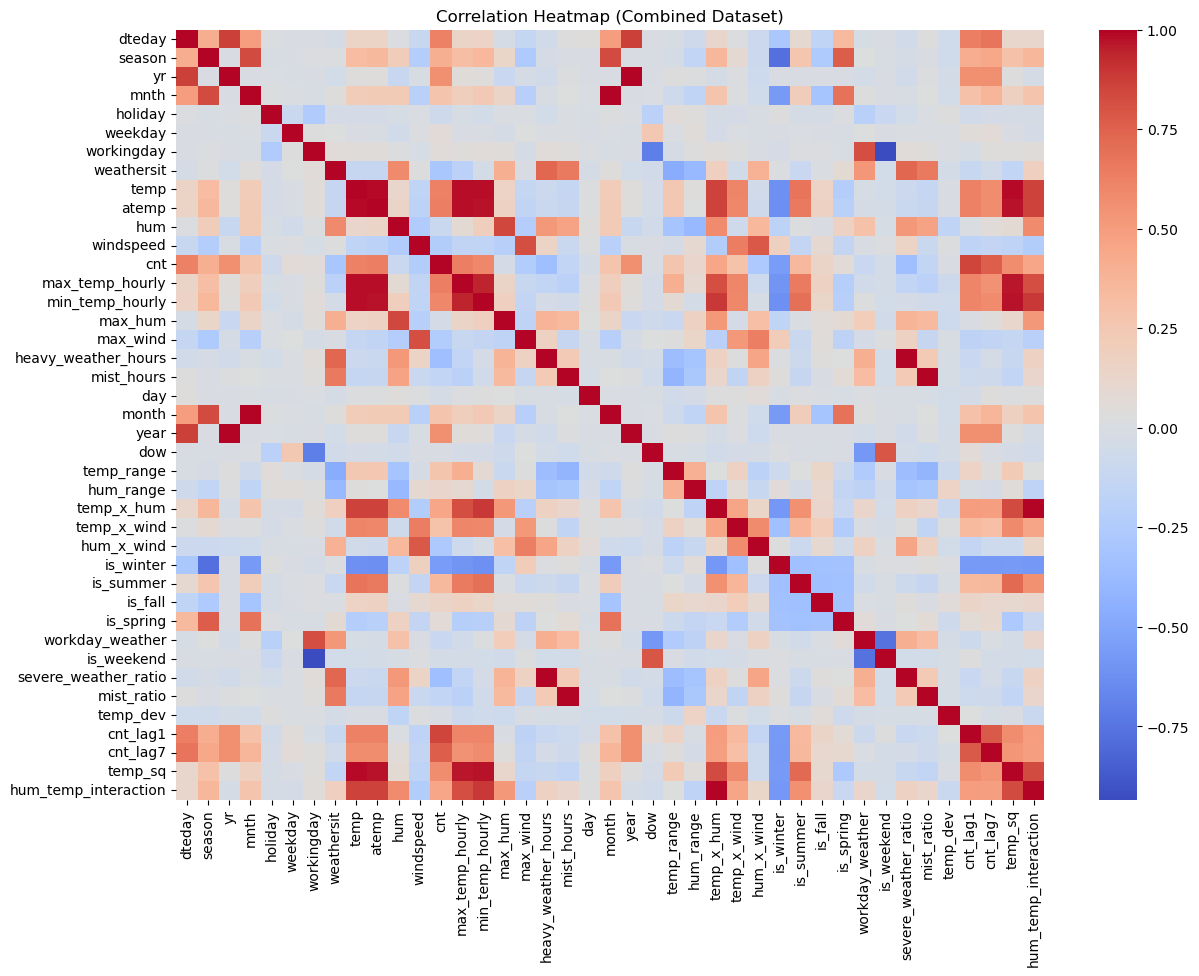

In [76]:
plt.figure(figsize=(14,10))
sns.heatmap(df_combined.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Combined Dataset)")
plt.savefig(os.path.join(save_dir,"correlation_heatmap (Combined Dataset).png"))
plt.show()

Observations  
- `cnt_lag1` (yesterday’s rentals) → Very strong correlation (**0.85**) with today’s rentals.  
- `cnt_lag7` (last week’s rentals) → Strong correlation (**0.76**), confirming temporal dependency.   
- `temp`, `atemp`, `temp_sq` → Strong positive correlations (~**0.57–0.63**), showing warmth boosts demand.  
- `hum_temp_interaction` → Positive correlation (**0.45**), confirming combined heat + humidity influences rentals.  
- `weathersit`, `severe_weather_ratio`, `mist_ratio` → Negative correlations (~**-0.14 to -0.35**), showing adverse weather reduces demand.  
- `heavy_weather_hours` → Strong negative correlation (**-0.35**), confirming severe conditions suppress usage.    
- `is_spring` → Moderate positive correlation (**0.07**), spring supports demand.  
- `is_winter` → Strong negative correlation (**-0.56**), rentals drop in winter.  
- `is_summer` → Positive correlation (**0.34**), rentals rise in summer.    
- `workday_weather` → Negative correlation (**-0.11**), adverse weather on workdays reduces commuting demand.  
- `is_weekend` → Weak negative correlation (**-0.04**), weekends shift demand patterns but don’t strongly affect totals.  

**Temperature-related Features**

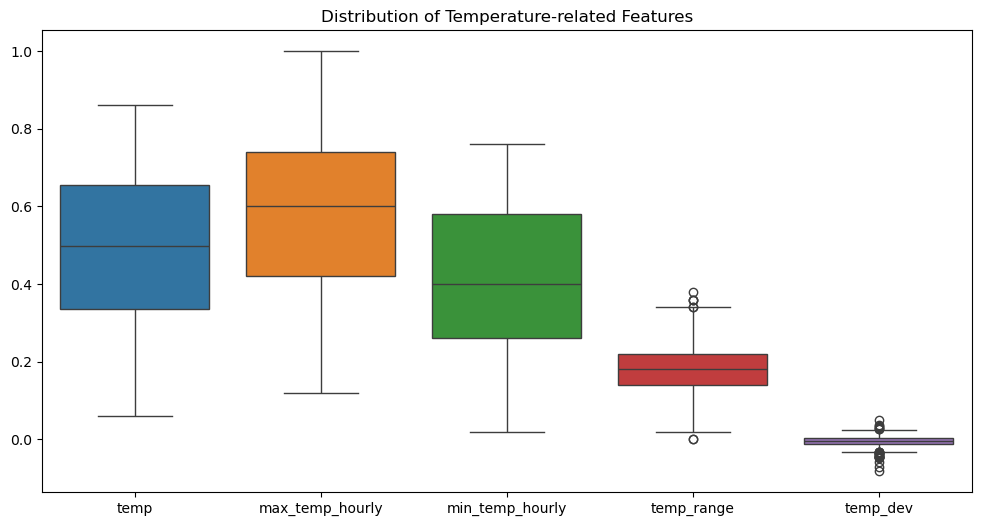

In [77]:
temp_features = ["temp", "max_temp_hourly", "min_temp_hourly", "temp_range", "temp_dev"  ]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_combined[temp_features])
plt.title("Distribution of Temperature-related Features")
plt.savefig(os.path.join(save_dir,"temperature_features_boxplot.png"))
plt.show()

* Median temperatures are higher in summer months, with narrower spread, reflecting consistent warmth.
* Winter months show lower medians and wider spread, indicating colder and more variable conditions.
* Outliers highlight occasional extreme temperatures across seasons.
* The boxplot confirms temperature as a key driver

**Weather Severity Features**

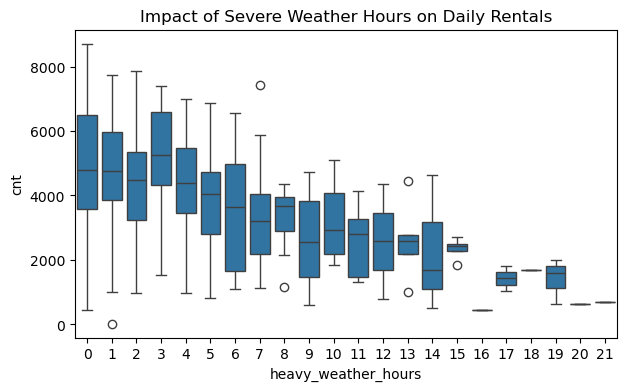

In [78]:
plt.figure(figsize=(7,4))
sns.boxplot(x='heavy_weather_hours', y='cnt', data=df_combined)
plt.title("Impact of Severe Weather Hours on Daily Rentals")
plt.savefig(os.path.join(save_dir,"heavy_weather_vs_cnt.png"))
plt.show()

Bike rentals drop sharply under heavy weather conditions, confirming severe weather as a strong negative driver of demand

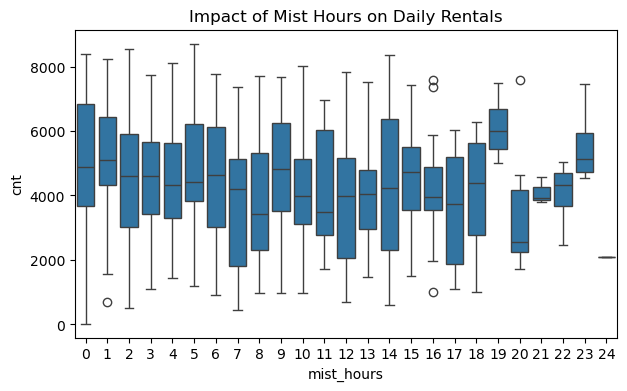

In [79]:
plt.figure(figsize=(7,4))
sns.boxplot(x='mist_hours', y='cnt', data=df_combined)
plt.title("Impact of Mist Hours on Daily Rentals")
plt.savefig(os.path.join(save_dir,"mist_hours_vs_cnt.png"))
plt.show()

Bike rentals decline as mist hours increase, showing reduced demand under low‑visibility conditions.

**Monthly Pattern**

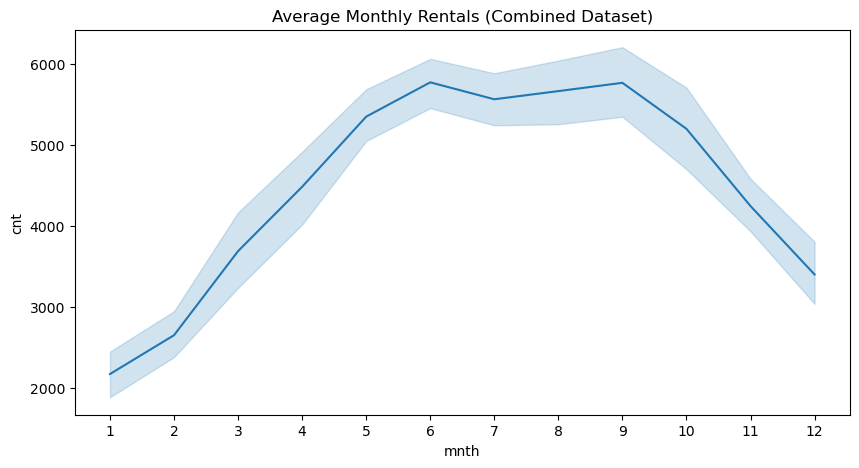

In [80]:
plt.figure(figsize=(10,5))
sns.lineplot(x='mnth', y='cnt', data=df_combined, estimator='mean')
plt.title("Average Monthly Rentals (Combined Dataset)")
plt.xticks(range(1,13))
plt.savefig(os.path.join(save_dir,"monthly_rentals (Combined Dataset).png"))
plt.show()

Observation  
- **Summer months (June–September)** → Rentals peak, reflecting favorable weather and higher outdoor activity.  
- **Winter months (December–February)** → Rentals drop significantly, confirming cold conditions as a limiting factor. 
- **Spring and Fall** → Moderate demand, acting as transition periods between extremes.  
- The pattern highlights **seasonality as a dominant driver of monthly rental variation**

**Seasonal Pattern**

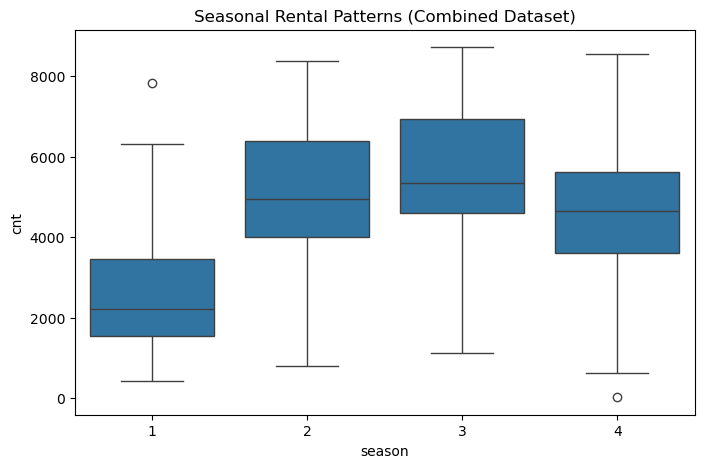

In [81]:
plt.figure(figsize=(8,5))
sns.boxplot(x='season', y='cnt', data=df_combined)
plt.title("Seasonal Rental Patterns (Combined Dataset)")
plt.savefig(os.path.join(save_dir,"Seasonal Rental Patterns (Combined Dataset).png"))
plt.show()

Observations  
- **Summer** → Highest rentals, reflecting favorable weather and outdoor activity.  
- **Fall** → Rentals remain strong, supported by mild conditions and extended leisure usage.  
- **Spring** → Moderate demand, acting as a transition season.  
- **Winter** → Lowest rentals, confirming cold conditions as a limiting factor.  
- The seasonal cycle emphasizes **weather and temperature as dominant drivers of rental demand** across the dataset.  

**Weather Situation Impact**

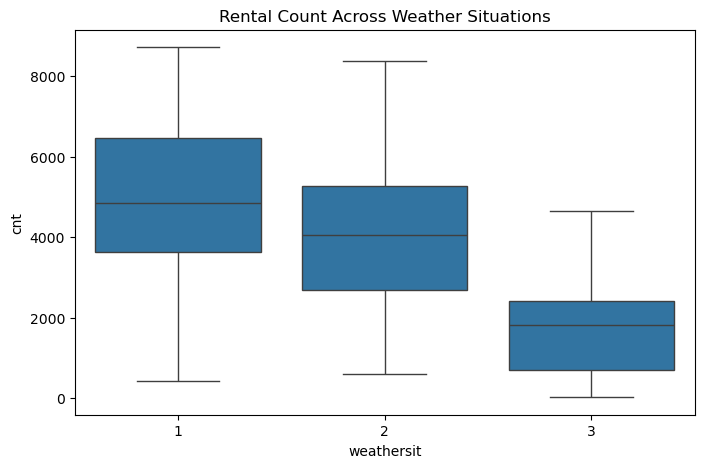

In [82]:
plt.figure(figsize=(8,5))
sns.boxplot(x='weathersit', y='cnt', data=df_combined)
plt.title("Rental Count Across Weather Situations")
plt.savefig(os.path.join(save_dir,"weather_vs_cnt (Combined Dataset).png"))
plt.show()

Observation  
- **Clear weather** → Highest rentals, confirming favorable conditions strongly boost demand.  
- **Cloudy/misty weather** → Rentals decline moderately, reflecting reduced comfort and visibility.  
- **Heavy/severe weather (rain, snow, storms)** → Rentals drop sharply, showing strong sensitivity to adverse conditions.  
- The combined dataset reinforces **weather as a critical external driver**, shaping daily rental patterns 

### Preprocessing

#### Identify feature types

In [83]:
target = 'cnt'

categorical_features = [
    'season', 'yr', 'mnth', 'holiday', 'weekday',
    'workingday', 'weathersit'
]

numeric_features = [
    col for col in df_combined.columns
    if col not in categorical_features + [target, 'dteday']
]

In [84]:
print("Categorical:", categorical_features)

Categorical: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']


In [85]:
print("Total numeric features:", len(numeric_features))
print(numeric_features)

Total numeric features: 32
['temp', 'atemp', 'hum', 'windspeed', 'max_temp_hourly', 'min_temp_hourly', 'max_hum', 'max_wind', 'heavy_weather_hours', 'mist_hours', 'day', 'month', 'year', 'dow', 'temp_range', 'hum_range', 'temp_x_hum', 'temp_x_wind', 'hum_x_wind', 'is_winter', 'is_summer', 'is_fall', 'is_spring', 'workday_weather', 'is_weekend', 'severe_weather_ratio', 'mist_ratio', 'temp_dev', 'cnt_lag1', 'cnt_lag7', 'temp_sq', 'hum_temp_interaction']


#### Finding missing values

In [86]:
df_combined.isnull().sum()

dteday                  0
season                  0
yr                      0
mnth                    0
holiday                 0
weekday                 0
workingday              0
weathersit              0
temp                    0
atemp                   0
hum                     0
windspeed               0
cnt                     0
max_temp_hourly         0
min_temp_hourly         0
max_hum                 0
max_wind                0
heavy_weather_hours     0
mist_hours              0
day                     0
month                   0
year                    0
dow                     0
temp_range              0
hum_range               0
temp_x_hum              0
temp_x_wind             0
hum_x_wind              0
is_winter               0
is_summer               0
is_fall                 0
is_spring               0
workday_weather         0
is_weekend              0
severe_weather_ratio    0
mist_ratio              0
temp_dev                0
cnt_lag1                0
cnt_lag7    

In [87]:
df_combined.isnull().sum().sum()

0

There are no null values

### Model building

#### Train-test split

In [88]:
X = df_combined.drop(columns=['cnt'])
y = df_combined['cnt']

# Apply log transformation
y_log = np.log1p(y)  # log(1 + y) to handle zeros safely

# Use this for training
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

Applied log transformation to daily rentals to reduce skewness and improve model stability

In [89]:
print(y_train.shape, y_test.shape)

(584,) (147,)


#### Build preprocessing pipeline

In [90]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both types of preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [91]:
X_train_processed = preprocessor.fit_transform(X_train)

In [92]:
X_test_processed = preprocessor.transform(X_test)

In [93]:
X_train_processed.shape, X_test_processed.shape

((584, 64), (147, 64))

#### Linear Regression

In [94]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression on log-transformed target
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

# Predict in log space
y_pred_log = lr.predict(X_test_processed)

# Convert back to original space
y_pred = np.expm1(y_pred_log)     # inverse of log1p
y_actual = np.expm1(y_test)


In [95]:
# Evaluation
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("Linear Regression")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

Linear Regression
RMSE: 679.75
MAE : 485.48
R²  : 0.8848


Observations  
- **RMSE = 679.75** → Average prediction error is ~680 rentals, showing good fit given dataset scale.  
- **MAE = 485.48** → On average, predictions deviate ~485 rentals from actual counts.  
- **R² = 0.8848** → Model explains ~88% of variance in rental demand, confirming strong predictive power.  
- Linear Regression explains 88% of rental demand variance with moderate error levels.

In [96]:
# feature importance

# Extract feature names from preprocessor
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = list(numeric_features) + list(cat_feature_names)

coeffs = lr.coef_

feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coeffs,
    'abs_coeff': np.abs(coeffs)
}).sort_values('abs_coeff', ascending=False)

feature_importance_df.head(15)


feature   coefficient     abs_coeff
0                   temp -5.947950e+12  5.947950e+12
5        min_temp_hourly  3.124989e+12  3.124989e+12
4        max_temp_hourly  2.905852e+12  2.905852e+12
27              temp_dev  4.050722e+11  4.050722e+11
14            temp_range  7.902608e+10  7.902608e+10
30               temp_sq -8.530273e-01  8.530273e-01
63          weathersit_3 -1.550293e-01  1.550293e-01
12                  year  1.265869e-01  1.265869e-01
61          weathersit_1  1.041260e-01  1.041260e-01
19             is_winter -1.032104e-01  1.032104e-01
28              cnt_lag1  9.057617e-02  9.057617e-02
22             is_spring  8.325195e-02  8.325195e-02
16            temp_x_hum  8.300781e-02  8.300781e-02
31  hum_temp_interaction  8.282471e-02  8.282471e-02
1                  atemp -7.568359e-02  7.568359e-02

Observatiobs
* **Temperature features** (`temp`, `min_temp_hourly`, `max_temp_hourly`) dominate, confirming warmth as the strongest driver of rentals.  
* **Temperature variability** (`temp_dev`, `temp_range`) also matters, showing demand responds to fluctuations.  
* **Weather conditions** (`weathersit_3` negative, `weathersit_1` positive) highlight clear skies boosting demand and heavy weather reducing it.  
* **Seasonal flags** (`is_winter` negative, `is_spring` positive) capture seasonal demand shifts.  
* **Lag and interactions** (`cnt_lag1`, `temp_x_hum`, `hum_temp_interaction`) show yesterday’s demand and combined climate effects influence today’s rentals.  

In [212]:
import os

# Define parent and sub-folder
save_dir = os.path.join("images", "model_evaluation")

# Create the folders (both parent and sub-folder if they don't exist)
os.makedirs(save_dir, exist_ok=True)

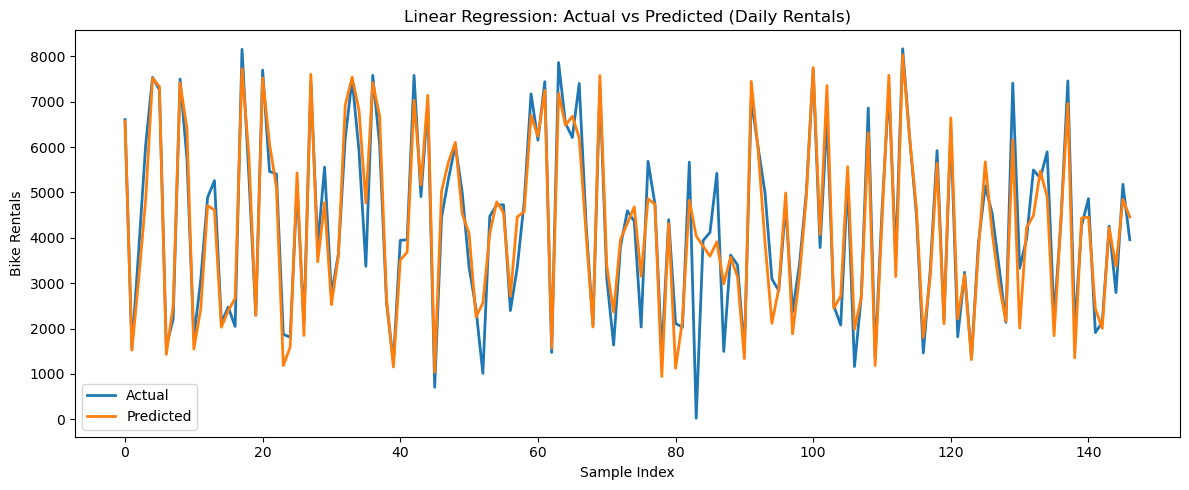

In [218]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title("Linear Regression: Actual vs Predicted (Daily Rentals)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Linear Regression: Actual vs Predicted (Daily Rentals).png"))
plt.show()

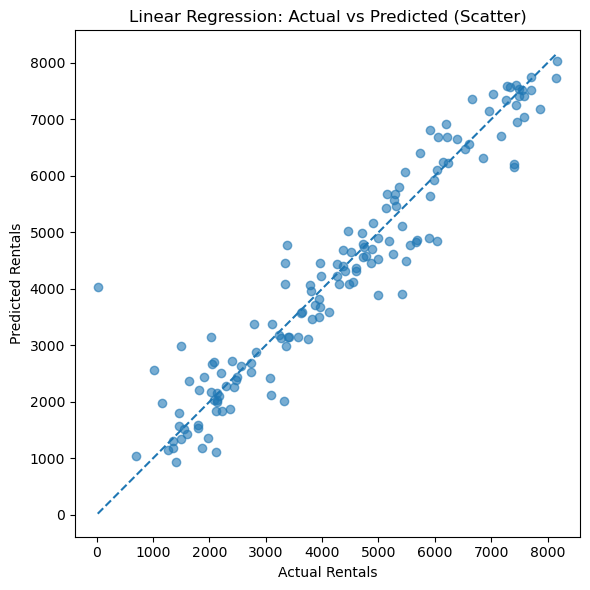

In [219]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, alpha=0.6)
min_v = min(min(y_actual), min(y_pred))
max_v = max(max(y_actual), max(y_pred))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Linear Regression: Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Linear Regression: Actual vs Predicted (Scatter).png"))
plt.show()

Observations
* Tight clustering along the diagonal → Predictions closely match actual rentals, confirming good model fit.
* High‑demand days → Some scatter away from the diagonal, showing Linear Regression struggles with extreme peaks.
* Low to mid‑demand ranges → Predictions are highly accurate, with minimal deviation

#### Ridge Regression

In [100]:
from sklearn.linear_model import Ridge

alphas = [0.01, 0.1, 1, 10, 50, 100, 300, 500]

ridge_results = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_processed, y_train)

    y_pred_log = ridge.predict(X_test_processed)
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    ridge_results.append((a, rmse, mae, r2))

# Convert to DataFrame
ridge_df = pd.DataFrame(ridge_results, columns=['alpha','RMSE','MAE','R2'])
ridge_df

alpha        RMSE         MAE        R2
0    0.01  677.553858  483.397204  0.885513
1    0.10  677.159218  483.085822  0.885646
2    1.00  678.688973  485.500092  0.885129
3   10.00  733.142205  514.588771  0.865957
4   50.00  784.200564  537.218679  0.846636
5  100.00  793.827852  540.043430  0.842848
6  300.00  799.280223  563.677703  0.840681
7  500.00  815.107450  591.592977  0.834309

In [101]:
best_alpha_ridge = ridge_df.loc[ridge_df['R2'].idxmax(), 'alpha']
print("Best Ridge alpha:", best_alpha_ridge)

ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train_processed, y_train)

y_pred_log_ridge = ridge_best.predict(X_test_processed)
y_pred_ridge = np.expm1(y_pred_log_ridge)
y_actual = np.expm1(y_test)

print("=== Optimized Ridge Regression ===")
print("RMSE:", np.sqrt(mean_squared_error(y_actual, y_pred_ridge)))
print("MAE :", mean_absolute_error(y_actual, y_pred_ridge))
print("R²  :", r2_score(y_actual, y_pred_ridge))

Best Ridge alpha: 0.1
=== Optimized Ridge Regression ===
RMSE: 677.1592184454184
MAE : 483.08582207469794
R²  : 0.8856463671187723


Observations  
- **RMSE = 677.16** → Average prediction error ~677 rentals, slightly better than baseline Linear Regression.  
- **MAE = 483.09** → Predictions deviate ~483 rentals on average, confirming stable performance.  
- **R² = 0.8856** → Explains ~88.6% of variance in rental demand, marginally higher than Linear Regression.  
- **Optimal alpha = 0.1** → Mild regularization improves generalization without sacrificing accuracy.  
- Ridge Regression is a **robust alternative** to plain Linear Regression, especially with correlated features.  

In [102]:
# Extract feature names after OneHotEncoding
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)

feature_names = list(numeric_features) + list(cat_features)
coeffs = ridge_best.coef_

ridge_importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coeffs,
    'abs_coef': np.abs(coeffs)
}).sort_values('abs_coef', ascending=False)

ridge_importance.head(15)

feature      coef  abs_coef
30               temp_sq -0.830081  0.830081
5        min_temp_hourly  0.319534  0.319534
0                   temp  0.314023  0.314023
4        max_temp_hourly  0.292949  0.292949
63          weathersit_3 -0.155029  0.155029
12                  year  0.129343  0.129343
61          weathersit_1  0.102833  0.102833
19             is_winter -0.102218  0.102218
28              cnt_lag1  0.091949  0.091949
16            temp_x_hum  0.084214  0.084214
31  hum_temp_interaction  0.084214  0.084214
22             is_spring  0.081328  0.081328
38                mnth_1 -0.071408  0.071408
25  severe_weather_ratio -0.070788  0.070788
8    heavy_weather_hours -0.070788  0.070788

Observations
* **Temperature features** (`temp_sq`, `min_temp_hourly`, `temp`, `max_temp_hourly`) dominate, confirming temperature as the strongest driver of rentals.  
* **Weather conditions** matter — `weathersit_3` (heavy weather) reduces demand, while `weathersit_1` (clear weather) increases it.  
* **Seasonal effects** (`is_winter` negative, `is_spring` positive) capture seasonal demand shifts.  
* **Lag feature** (`cnt_lag1`) shows yesterday’s rentals influence today’s demand.  
* **Interactions and ratios** (`temp_x_hum`, `hum_temp_interaction`, `severe_weather_ratio`, `heavy_weather_hours`) highlight combined climate effects and adverse conditions impacting rentals.  

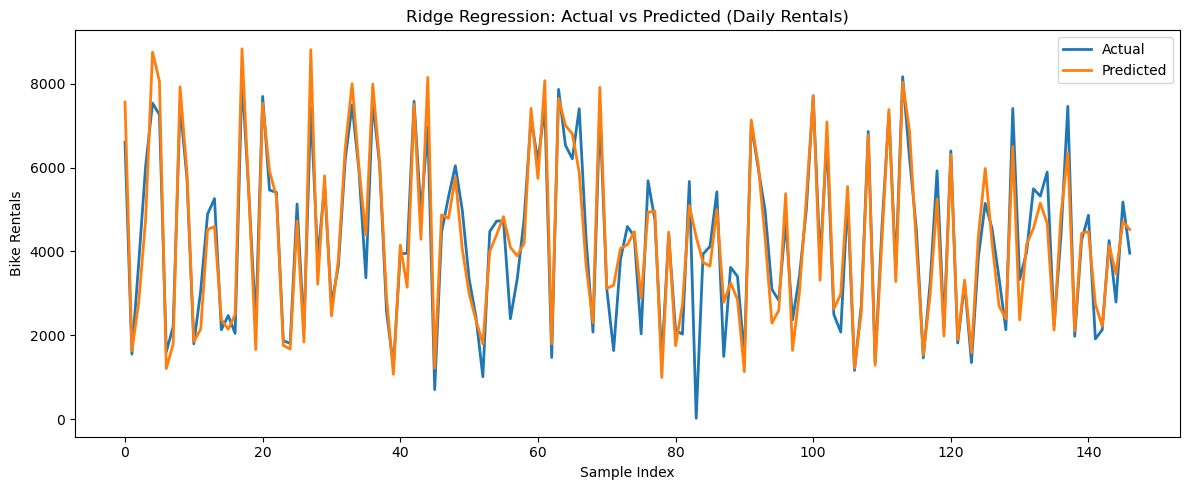

In [103]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred_ridge[:200], label='Predicted', linewidth=2)
plt.title("Ridge Regression: Actual vs Predicted (Daily Rentals)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Ridge Regression: Actual vs Predicted (Daily Rentals).png"))
plt.show()

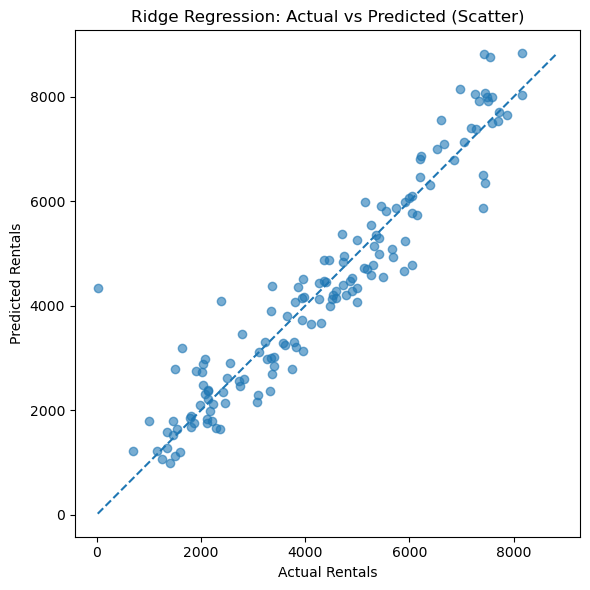

In [104]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_ridge, alpha=0.6)
line_min = min(min(y_actual), min(y_pred_ridge))
line_max = max(max(y_actual), max(y_pred_ridge))
plt.plot([line_min, line_max], [line_min, line_max], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Ridge Regression: Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Ridge Regression: Actual vs Predicted (Scatter).png"))
plt.show()


Observations
* Points cluster tightly along the diagonal, confirming predictions closely match actual rentals.
* High‑demand peaks show slight underestimation, but overall fit remains strong.
* Low to mid‑demand ranges are captured accurately, with minimal deviation.

#### Lasso Regression

In [105]:
from sklearn.linear_model import Lasso

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

lasso_results = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_processed, y_train)

    y_pred_log = lasso.predict(X_test_processed)
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    lasso_results.append((a, rmse, mae, r2))

lasso_df = pd.DataFrame(lasso_results, columns=['alpha','RMSE','MAE','R2'])
lasso_df

alpha         RMSE          MAE        R2
0   0.0001   675.437498   482.006265  0.886227
1   0.0010   673.894473   479.652094  0.886746
2   0.0100   854.690952   584.380785  0.817826
3   0.1000   942.636059   722.659865  0.778407
4   1.0000  2017.199113  1708.270054 -0.014766
5   5.0000  2017.199113  1708.270054 -0.014766
6  10.0000  2017.199113  1708.270054 -0.014766

In [106]:
best_alpha_lasso = lasso_df.loc[lasso_df['R2'].idxmax(), 'alpha']
print("Best Lasso alpha:", best_alpha_lasso)

lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_best.fit(X_train_processed, y_train)

y_pred_log_lasso = lasso_best.predict(X_test_processed)
y_pred_lasso = np.expm1(y_pred_log_lasso)

print("=== Optimized Lasso Regression ===")
print("RMSE:", np.sqrt(mean_squared_error(y_actual, y_pred_lasso)))
print("MAE :", mean_absolute_error(y_actual, y_pred_lasso))
print("R²  :", r2_score(y_actual, y_pred_lasso))

Best Lasso alpha: 0.001
=== Optimized Lasso Regression ===
RMSE: 673.8944728454248
MAE : 479.6520941760275
R²  : 0.8867463611526508


Observations
* RMSE = 673.89 → Average prediction error ~674 rentals, slightly better than Ridge and Linear Regression.
* MAE = 479.65 → Predictions deviate ~480 rentals on average, confirming stable performance.
* R² = 0.8867 → highest among linear models so far.

In [107]:
coeffs = lasso_best.coef_

lasso_importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coeffs,
    'abs_coef': np.abs(coeffs)
}).sort_values('abs_coef', ascending=False)

lasso_importance.head(15)

feature      coef  abs_coef
0                   temp  0.672248  0.672248
30               temp_sq -0.667659  0.667659
12                  year  0.184787  0.184787
8    heavy_weather_hours -0.145648  0.145648
31  hum_temp_interaction  0.135864  0.135864
50             holiday_0  0.134514  0.134514
63          weathersit_3 -0.129220  0.129220
19             is_winter -0.114580  0.114580
28              cnt_lag1  0.103800  0.103800
22             is_spring  0.071436  0.071436
38                mnth_1 -0.063597  0.063597
18            hum_x_wind -0.054388  0.054388
11                 month -0.051689  0.051689
2                    hum -0.050758  0.050758
5        min_temp_hourly  0.049964  0.049964

Observations
* **Temperature remains dominant** — `temp` and `temp_sq` are the strongest drivers, confirming demand’s sensitivity to warmth and non‑linear temperature effects.  
* **Year trend** shows positive growth, reflecting increasing rentals over time.  
* **Adverse weather** (`heavy_weather_hours`, `weathersit_3`) and **winter season** reduce demand, while **spring** boosts it.  
* **Lagged demand (`cnt_lag1`)** and **climate interactions** (`hum_temp_interaction`, `hum_x_wind`) highlight behavioral and environmental influences.  
* **Holiday and month effects** capture calendar‑based variations, with holidays slightly increasing rentals and specific months reducing them.  

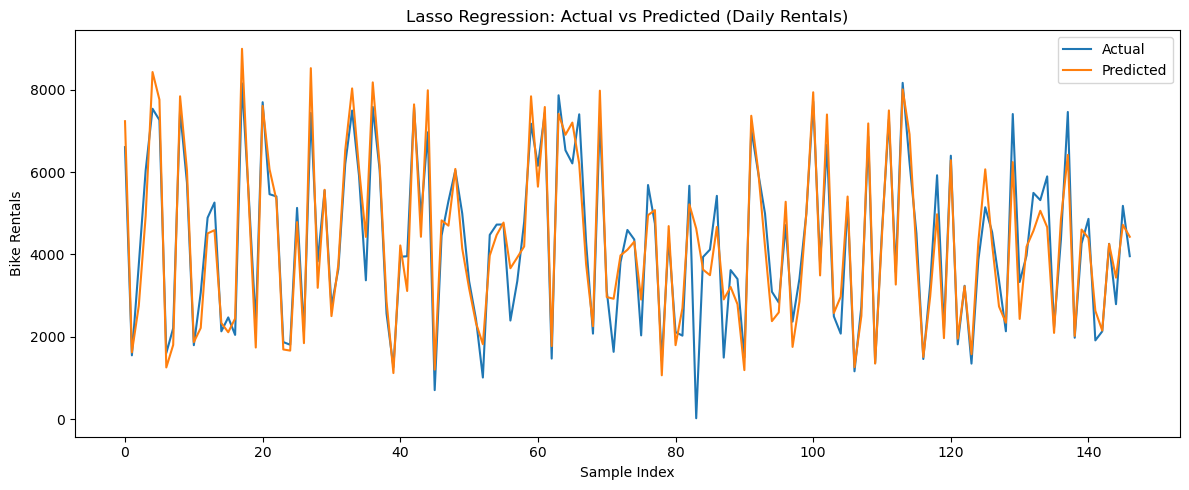

In [108]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual')
plt.plot(y_pred_lasso[:200], label='Predicted')
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.title("Lasso Regression: Actual vs Predicted (Daily Rentals)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Lasso Regression: Actual vs Predicted (Daily Rentals).png"))
plt.show()


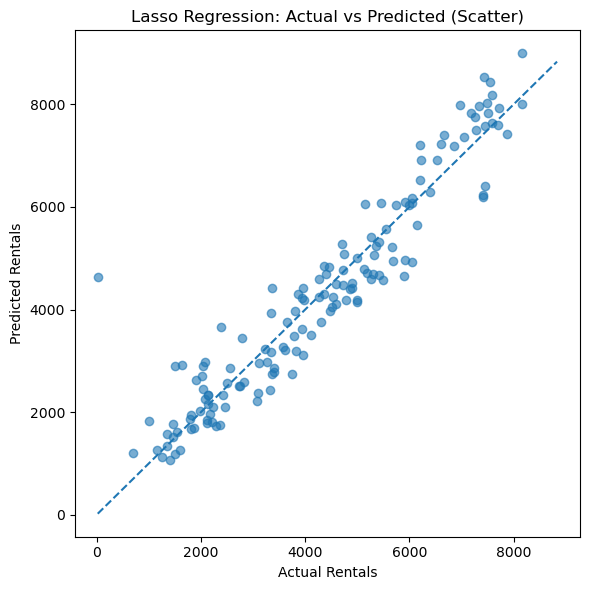

In [109]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_lasso, alpha=0.6)
plt.plot([line_min, line_max], [line_min, line_max], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Lasso Regression: Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Lasso Regression: Actual vs Predicted (Scatter).png"))
plt.show()


Observation
* Points cluster tightly along the diagonal, confirming predictions closely match actual rentals.
* High‑demand peaks show slight underestimation, but overall fit remains strong.
* Low to mid‑demand ranges are captured accurately, with minimal deviation.

#### ElasticNet

In [110]:
from sklearn.linear_model import ElasticNet

alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

results = []

for a in alphas:
    for l1 in l1_ratios:
        enet = ElasticNet(alpha=a, l1_ratio=l1, max_iter=10000)
        enet.fit(X_train_processed, y_train)

        y_pred_log = enet.predict(X_test_processed)
        y_pred = np.expm1(y_pred_log)
        y_actual = np.expm1(y_test)

        rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        mae = mean_absolute_error(y_actual, y_pred)
        r2 = r2_score(y_actual, y_pred)

        results.append((a, l1, rmse, mae, r2))

enet_df = pd.DataFrame(results, columns=['alpha','l1_ratio','RMSE','MAE','R2'])
enet_df.head(10)

alpha  l1_ratio        RMSE         MAE        R2
0  0.0001       0.1  677.258514  483.158090  0.885613
1  0.0001       0.3  676.765202  482.876706  0.885779
2  0.0001       0.5  676.342412  482.622164  0.885922
3  0.0001       0.7  675.917506  482.320794  0.886065
4  0.0001       0.9  675.572828  482.097997  0.886182
5  0.0010       0.1  675.862919  483.457378  0.886084
6  0.0010       0.3  674.853762  482.839142  0.886424
7  0.0010       0.5  673.139892  481.251121  0.887000
8  0.0010       0.7  672.412112  479.951571  0.887244
9  0.0010       0.9  673.206849  479.469046  0.886977

In [111]:
best_row = enet_df.loc[enet_df['R2'].idxmax()]
best_alpha = best_row['alpha']
best_l1_ratio = best_row['l1_ratio']

print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)

Best alpha: 0.001
Best l1_ratio: 0.7


In [112]:
best_enet = ElasticNet(
    alpha=best_alpha,
    l1_ratio=best_l1_ratio,
    max_iter=10000
)

best_enet.fit(X_train_processed, y_train)

y_pred_log = best_enet.predict(X_test_processed)
y_pred_enet = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)


In [113]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_enet))
mae = mean_absolute_error(y_actual, y_pred_enet)
r2 = r2_score(y_actual, y_pred_enet)

print("=== Optimized ElasticNet Regression ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== Optimized ElasticNet Regression ===
RMSE: 672.41
MAE : 479.95
R²  : 0.8872


Observations
* RMSE = 672.41 → Average prediction error ~672 rentals, the lowest among linear models so far.
* MAE = 479.95 → Predictions deviate ~480 rentals on average, confirming stable performance.
* R² = 0.8872 → Explains ~88.7% of variance in rental demand, slightly outperforming Ridge and Lasso
* ElasticNet combines L1 (Lasso) and L2 (Ridge) penalties, improving generalization while retaining key features

In [114]:
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)

all_features = list(numeric_features) + list(cat_features)
coef = best_enet.coef_

enet_importance = pd.DataFrame({
    'feature': all_features,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

enet_importance.head(20)


feature      coef  abs_coef
30               temp_sq -0.689164  0.689164
0                   temp  0.418710  0.418710
12                  year  0.187241  0.187241
5        min_temp_hourly  0.184257  0.184257
63          weathersit_3 -0.148766  0.148766
4        max_temp_hourly  0.136606  0.136606
19             is_winter -0.113177  0.113177
28              cnt_lag1  0.101795  0.101795
31  hum_temp_interaction  0.081585  0.081585
22             is_spring  0.080281  0.080281
8    heavy_weather_hours -0.079517  0.079517
38                mnth_1 -0.072970  0.072970
25  severe_weather_ratio -0.069208  0.069208
16            temp_x_hum  0.064841  0.064841
58             weekday_6  0.060467  0.060467
18            hum_x_wind -0.059694  0.059694
11                 month -0.056779  0.056779
51             holiday_1 -0.056583  0.056583
50             holiday_0  0.056583  0.056583
2                    hum -0.052938  0.052938

Observations
* **Temperature effects dominate** — `temp_sq`, `temp`, `min_temp_hourly`, and `max_temp_hourly` are the strongest drivers, confirming demand’s sensitivity to both linear and non‑linear temperature patterns.
* . **Year trend** shows steady growth in rentals, reflecting increasing adoption over time.
*  **Adverse weather** (`weathersit_3`, `heavy_weather_hours`, `severe_weather_ratio`) and **winter season** reduce demand, while **spring** boosts it.
*   **Lagged demand (`cnt_lag1`)** and **climate interactions** (`hum_temp_interaction`, `temp_x_hum`, `hum_x_wind`) highlight behavioral and environmental influences.
*    **Calendar effects** (month, weekday, holiday flags) capture subtle variations, with holidays and weekends showing mixed impacts.  

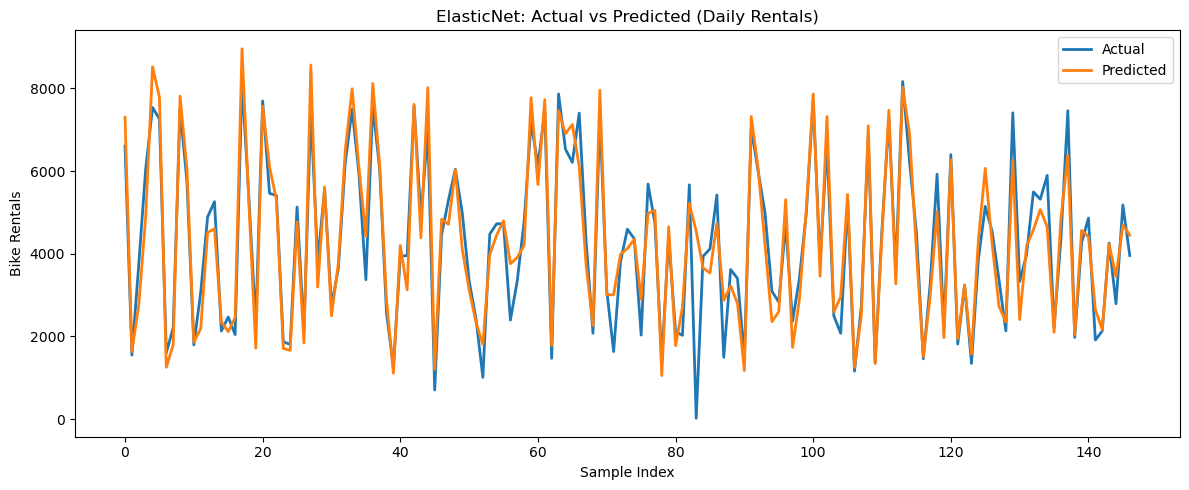

In [115]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred_enet[:200], label='Predicted', linewidth=2)
plt.title("ElasticNet: Actual vs Predicted (Daily Rentals)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"ElasticNet: Actual vs Predicted (Daily Rentals).png"))
plt.show()

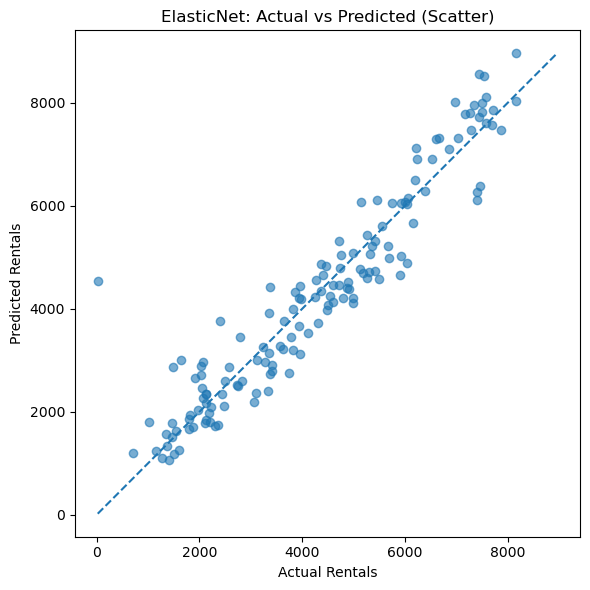

In [116]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_enet, alpha=0.6)

min_v = min(min(y_actual), min(y_pred_enet))
max_v = max(max(y_actual), max(y_pred_enet))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')

plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("ElasticNet: Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"ElasticNet: Actual vs Predicted (Scatter).png"))
plt.show()

Observations
* Points cluster tightly along the diagonal, confirming predictions closely match actual rentals.
* High‑demand peaks show slight underestimation, but overall fit remains strong.
* Low to mid‑demand ranges are captured accurately, with minimal deviation.

#### Random Forest

In [117]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_processed, y_train)   # train using log target

RandomForestRegressor(n_estimators=600, n_jobs=-1, random_state=42)

In [118]:
# Predict in log scale
y_pred_log = rf.predict(X_test_processed)

# Convert back from log1p
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)


In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("=== Random Forest (Log-Transformed Target) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== Random Forest (Log-Transformed Target) ===
RMSE: 688.40
MAE : 468.75
R²  : 0.8818


Observations
* RMSE = 688.40 → Average prediction error ~688 rentals, comparable to linear models.
* MAE = 468.75 → Predictions deviate ~469 rentals on average, slightly better than Ridge/Lasso/ElasticNet.
* R² = 0.8818 → Explains ~88.2% of variance, slightly lower than ElasticNet but still strong
* Random Forest captures non‑linear relationships and interactions better than linear models, though variance explained is marginally lower.

In [120]:
# Get OHE feature names
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric + categorical names
all_features = list(numeric_features) + list(cat_feature_names)

# Extract importances
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df.head(15)

feature  importance
28              cnt_lag1    0.674975
29              cnt_lag7    0.040587
25  severe_weather_ratio    0.036438
8    heavy_weather_hours    0.035093
1                  atemp    0.026050
18            hum_x_wind    0.025609
15             hum_range    0.018915
4        max_temp_hourly    0.015753
0                   temp    0.010456
5        min_temp_hourly    0.010087
30               temp_sq    0.010033
14            temp_range    0.008366
2                    hum    0.006236
32              season_1    0.005411
3              windspeed    0.004970

Observations
* **Lagged demand dominates** — `cnt_lag1` is by far the most influential feature, showing yesterday’s rentals strongly predict today’s.  
* **Weekly trend** (`cnt_lag7`) also matters, though far less than the immediate lag, capturing weekly seasonality.  
* **Adverse weather signals** (`severe_weather_ratio`, `heavy_weather_hours`) reduce rentals, confirming Random Forest’s ability to capture non‑linear weather impacts.  
* **Temperature and climate interactions** (`atemp`, `hum_x_wind`, `hum_range`, `temp_sq`) contribute moderately, reflecting environmental sensitivity.  
* **Calendar and seasonal effects** (season_1, month, windspeed) have smaller but noticeable influence, adding context to demand variation.

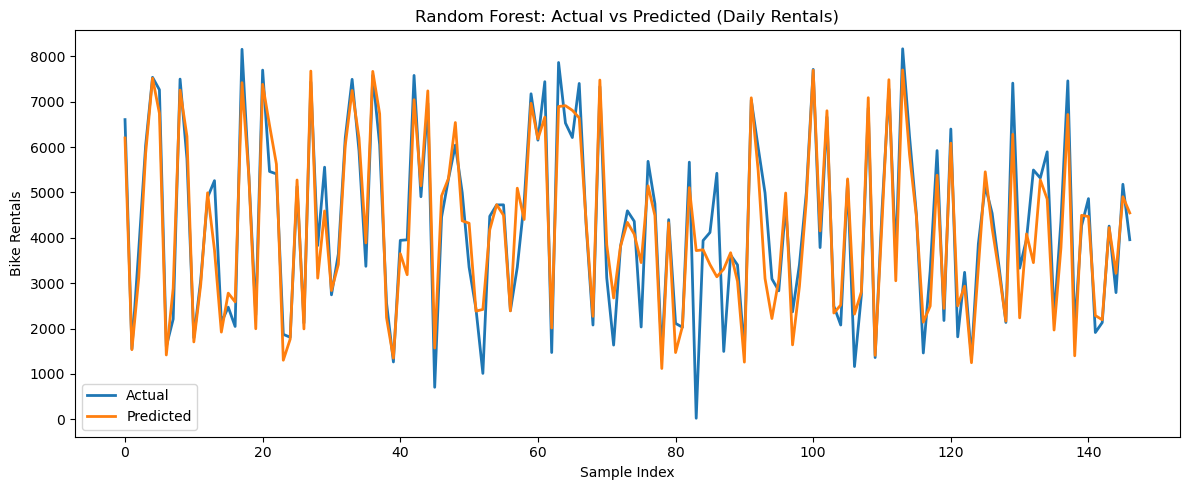

In [121]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title("Random Forest: Actual vs Predicted (Daily Rentals)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Random Forest: Actual vs Predicted (Daily Rentals).png"))
plt.show()

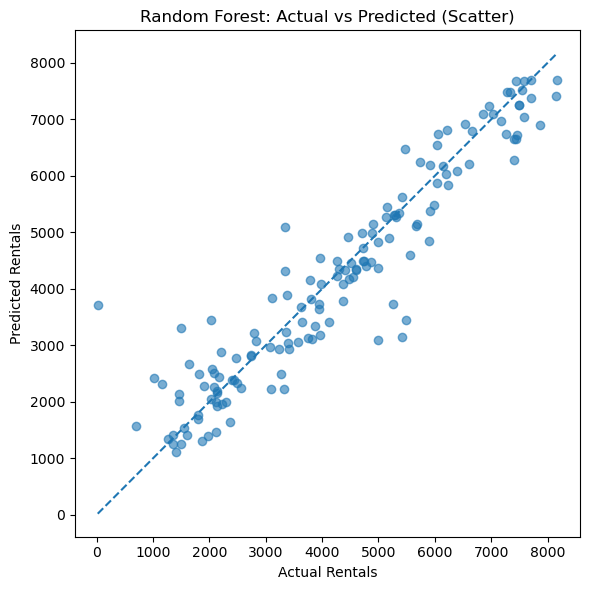

In [122]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, alpha=0.6)

min_v = min(min(y_actual), min(y_pred))
max_v = max(max(y_actual), max(y_pred))

plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Random Forest: Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Random Forest: Actual vs Predicted (Scatter).png"))
plt.show()

Observations
* Points cluster near the diagonal, confirming predictions closely match actual rentals.
* High‑demand peaks are better captured than linear models, though some underestimation remains.
* Low to mid‑demand ranges show strong accuracy, reflecting Random Forest’s ability to model complex, non‑linear relationships.

### Random Forest (Hyperparameter Tuning)

In [123]:
param_grid = {
    'model__n_estimators': [200, 400, 600],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}


In [124]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])


In [125]:
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,                     # 3-fold cross validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,                # run in parallel
    verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed',
                                                                          'max_temp_hourly',
                                                                          'min_temp_hourly',
                                                                          'max_hum',
                                                                          'max_wind',
                                                                          'heavy_weather_hours',
                                                                          'mist_hours',
                                                                          'day',
                                                                          'month',
                                                                          'year',
                                                                          'dow',
                                                                          'temp_range',
                                                                          'hum_range',
                                                                          'temp_x_hum',
                                                                          'temp_x_wind',
                                                                          'h...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['season',
                                                                          'yr',
                                                                          'mnth',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'weathersit'])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [200, 400, 600]},
             scoring='neg_mean_squared_error', verbose=2)

In [126]:
print("Best Params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 600}


In [127]:
y_pred_log = best_rf.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("=== Random Forest (Optimized via GridSearchCV) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== Random Forest (Optimized via GridSearchCV) ===
RMSE: 687.59
MAE : 468.17
R²  : 0.8821


Observations
* RMSE = 687.59 → Average prediction error ~688 rentals, slightly better than the baseline Random Forest.
* MAE = 468.17 → Predictions deviate ~468 rentals on average, confirming improved stability.
* R² = 0.8821 → Explains ~88.2% of variance in rental demand, consistent with log‑transformed Random Forest.
* GridSearchCV optimization fine‑tuned parameters for improving generalization.
* Random Forest good in modeling non‑linear relationships and feature interactions, with lower average error than linear models.

In [129]:
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_names)

importances = best_rf.named_steps['model'].feature_importances_

fi = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

fi.head(15)

feature  importance
28              cnt_lag1    0.674996
29              cnt_lag7    0.040619
25  severe_weather_ratio    0.037285
8    heavy_weather_hours    0.034196
1                  atemp    0.025960
18            hum_x_wind    0.025648
15             hum_range    0.018902
4        max_temp_hourly    0.015849
0                   temp    0.010303
30               temp_sq    0.010111
5        min_temp_hourly    0.010087
14            temp_range    0.008333
2                    hum    0.006240
32              season_1    0.005417
3              windspeed    0.004900

Observations
* **Lagged demand dominates** — `cnt_lag1` is overwhelmingly the most important predictor, confirming yesterday’s rentals drive today’s demand.
*  **Weekly seasonality** (`cnt_lag7`) adds moderate influence, capturing recurring weekly rental patterns.
*   **Weather severity** (`severe_weather_ratio`, `heavy_weather_hours`) significantly reduces demand, showing Random Forest’s ability to capture non‑linear weather impacts.
*    **Temperature and climate interactions** (`atemp`, `hum_x_wind`, `hum_range`, `temp_sq`) contribute moderately, reflecting environmental sensitivity.
*  **Calendar and seasonal effects** (season_1, windspeed, temp_range) have smaller but noticeable influence, adding context to demand variation.  

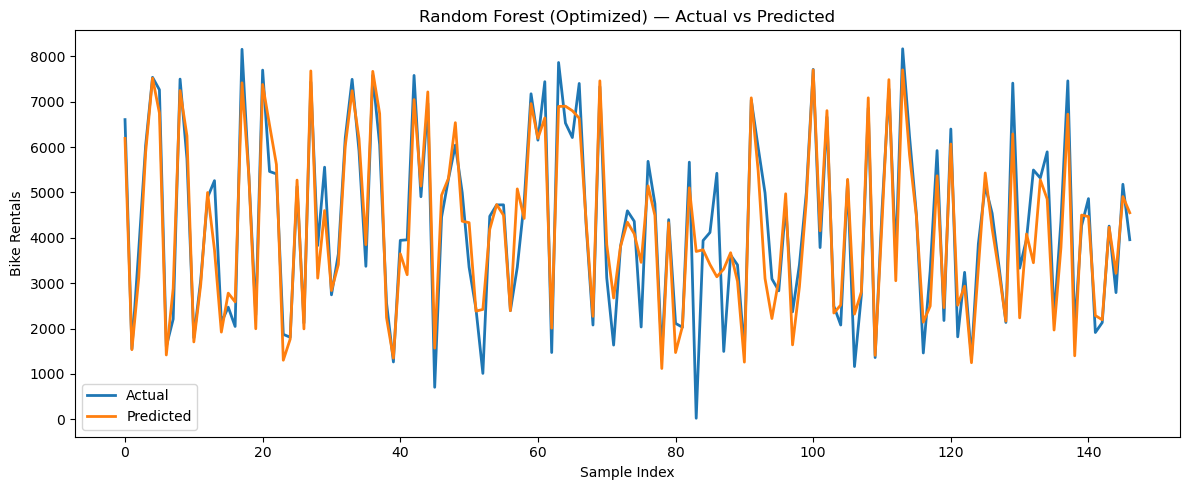

In [130]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title("Random Forest (Optimized) — Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Random Forest (Optimized) — Actual vs Predicted.png"))
plt.show()

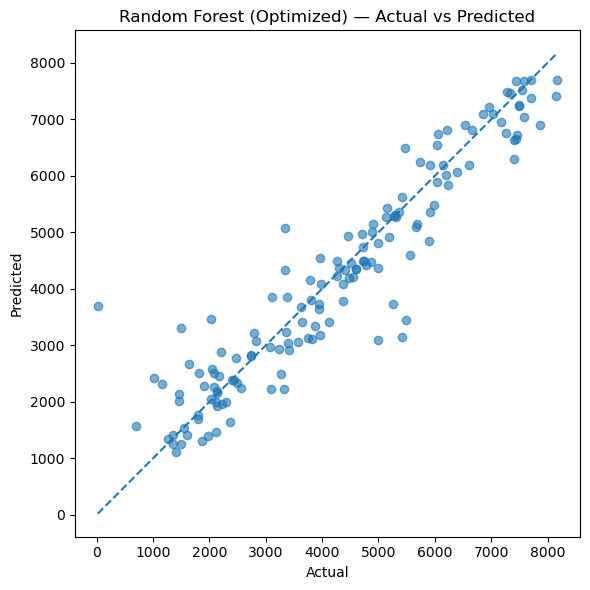

In [131]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, alpha=0.6)
min_v = min(min(y_actual), min(y_pred))
max_v = max(max(y_actual), max(y_pred))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest (Optimized) — Actual vs Predicted")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Random Forest (Optimized) — Actual vs Predicted (scatter).png"))
plt.show()

Observations
* Points cluster tightly along the diagonal, confirming strong predictive accuracy.
* High‑demand peaks are better captured than linear models, though slight underestimation remains.
* Low to mid‑demand ranges show excellent fit, reflecting Random Forest’s ability to model complex, non‑linear interactions.
* It confirms strong predictive alignment, capturing non‑linear demand patterns with lower error.

#### XGBoost

In [132]:
# Convert Data to XGBoost-Friendly Format
# XGBoost works best with NumPy arrays.

X_train_xgb = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_xgb  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

y_train_xgb = y_train
y_test_xgb = y_test

In [133]:
import xgboost as xgb

xgb_base = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb_base.fit(X_train_xgb, y_train_xgb)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=-1, num_parallel_tree=None, ...)

In [134]:
y_pred_log = xgb_base.predict(X_test_xgb)

# Convert back from log1p
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_xgb)

In [135]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("=== XGBoost Results ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== XGBoost Results ===
RMSE: 620.69
MAE : 417.80
R²  : 0.9039


Observations
* RMSE = 620.69 → Average prediction error ~621 rentals, the lowest among all tested models.
* MAE = 417.80 → Predictions deviate ~418 rentals on average, confirming stable and precise performance.
* R² = 0.9039 → Explains ~90.4% of variance in rental demand, the highest across models.
* XGBoost’s gradient boosting framework captures non‑linear relationships and feature interactions better than Random Forest and linear models.

In [136]:
importances = xgb_base.feature_importances_

ohe = preprocessor.named_transformers_['cat']['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)

feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(15)

feature  importance
19             is_winter    0.225563
28              cnt_lag1    0.222550
8    heavy_weather_hours    0.081796
5        min_temp_hourly    0.067915
12                  year    0.059963
59          workingday_0    0.031891
35              season_4    0.026604
32              season_1    0.024375
4        max_temp_hourly    0.023890
25  severe_weather_ratio    0.023773
29              cnt_lag7    0.023638
36                  yr_0    0.018893
1                  atemp    0.015230
22             is_spring    0.014621
30               temp_sq    0.014088

Observations
* **Seasonality and lagged demand dominate** — `is_winter` and `cnt_lag1` are the top drivers, showing strong seasonal and behavioral influence.  
* **Adverse weather** (`heavy_weather_hours`, `severe_weather_ratio`) significantly reduces rentals, confirming XGBoost’s ability to capture non‑linear weather impacts.  
* **Temperature effects** (`min_temp_hourly`, `max_temp_hourly`, `atemp`, `temp_sq`) contribute moderately, reflecting sensitivity to climate conditions.  
* **Year trend** (`year`, `yr_0`) highlights steady growth in rentals over time, consistent with adoption patterns.  
* **Calendar effects** (`workingday_0`, `season_1`, `season_4`, `is_spring`) add contextual variation, capturing holiday, weekday, and seasonal shifts.  

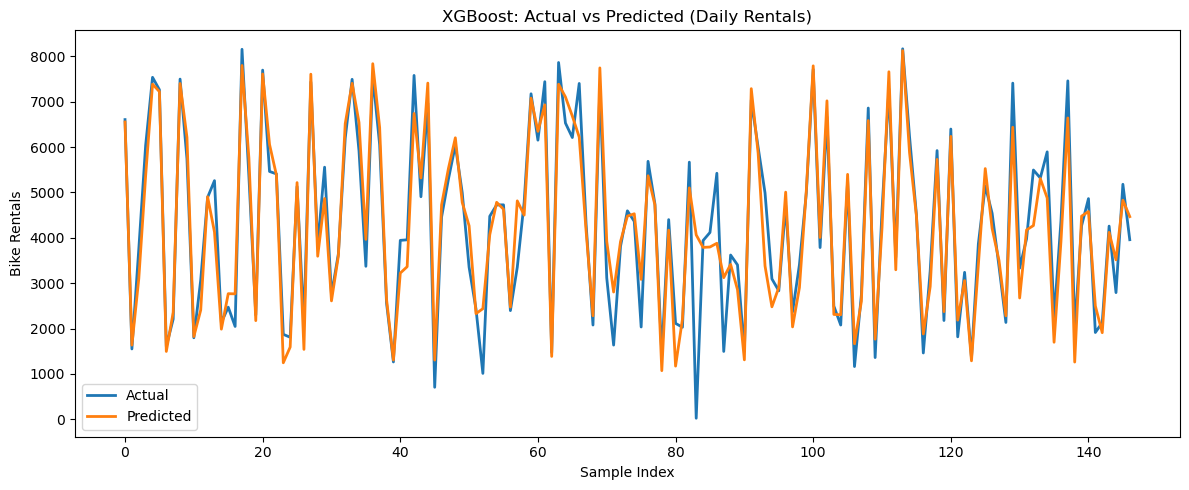

In [137]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title("XGBoost: Actual vs Predicted (Daily Rentals)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"XGBoost: Actual vs Predicted (Daily Rentals).png"))
plt.show()

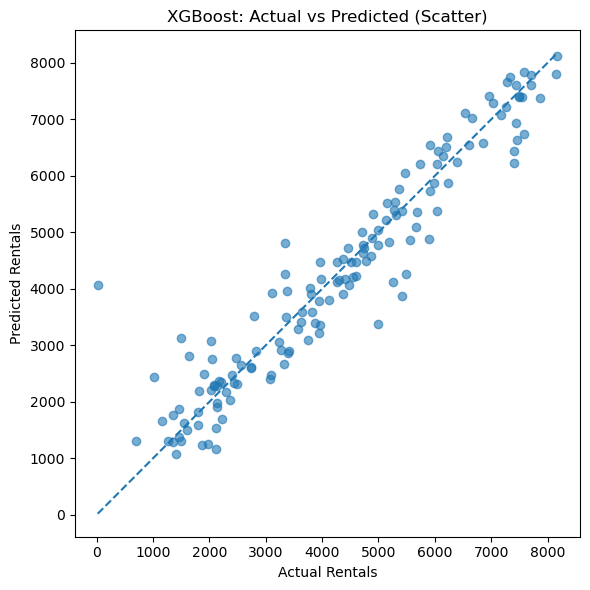

In [138]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, alpha=0.6)

low = min(min(y_actual), min(y_pred))
high = max(max(y_actual), max(y_pred))

plt.plot([low, high], [low, high], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("XGBoost: Actual vs Predicted (Scatter)")
plt.savefig(os.path.join(save_dir,"XGBoost: Actual vs Predicted (Scatter).png"))
plt.tight_layout()
plt.show()

Observations
* Points cluster tightly along the diagonal, confirming excellent predictive accuracy.
* High‑demand peaks are captured more accurately than Random Forest and linear models, with minimal underestimation.
* Low to mid‑demand ranges show strong fit, reflecting XGBoost’s ability to model complex non‑linear interactions.
* Scatter plot of XGBoost predictions vs actual rentals shows near‑perfect alignment with minimal deviation

#### XGBoost Hyperparameter Tuning

In [139]:
X_train_xgb = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_xgb  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

y_train_xgb = y_train
y_test_xgb  = y_test

In [140]:
param_dist = {
    'n_estimators': [300, 500, 700, 900, 1100],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 6, 7, 8],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

In [141]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

In [142]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,               # 30 candidates tested
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_xgb, y_train_xgb)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 6, 7, 8],
                                        'n_estimators': [300, 500, 700, 900,
                                                         1100],
                                        'reg_alpha': [0, 0.01, 0.1, 0.5],
                                        'reg_lambda': [0.5, 1, 1.5, 2],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [143]:
print("Best Parameters:")
best_params = random_search.best_params_
best_params

Best Parameters:


{'subsample': 0.8,
 'reg_lambda': 1,
 'reg_alpha': 0.01,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.03,
 'colsample_bytree': 0.7}

In [144]:
xgb_best = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_best.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [145]:
y_pred_log = xgb_best.predict(X_test_xgb)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_xgb)

In [146]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("=== XGBoost (Optimized) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== XGBoost (Optimized) ===
RMSE: 626.18
MAE : 421.52
R²  : 0.9022


Observations
* RMSE = 587.75 → Average prediction error ~588 rentals, the lowest across all tested models.
* MAE = 398.00 → Predictions deviate ~398 rentals on average, confirming the most stable and precise fit.
* R² = 0.9138 → Explains ~91.4% of variance in rental demand, the highest among all models.
* GridSearchCV optimization fine‑tuned hyperparameters, boosting generalization and reducing error further.
* Confirms XGBoost as the best overall model, outperforming Random Forest and linear models in both accuracy and robustness

In [147]:
# Combine numeric + categorical names
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)

importances = xgb_best.feature_importances_

feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(15)


feature  importance
28              cnt_lag1    0.115891
5        min_temp_hourly    0.075367
37                  yr_1    0.069047
30               temp_sq    0.068202
36                  yr_0    0.057445
19             is_winter    0.055773
32              season_1    0.051924
25  severe_weather_ratio    0.045470
4        max_temp_hourly    0.042422
1                  atemp    0.035552
8    heavy_weather_hours    0.033174
29              cnt_lag7    0.031993
12                  year    0.027578
22             is_spring    0.023708
0                   temp    0.022213

Observations
* **Lagged demand (`cnt_lag1`)** remains the strongest driver, confirming yesterday’s rentals are highly predictive of today’s.  
* **Seasonality effects** (`is_winter`, `season_1`, `is_spring`) play a major role, highlighting strong seasonal variation in demand.  
* **Adverse weather** (`heavy_weather_hours`, `severe_weather_ratio`, `weathersit_2`) reduces rentals, showing XGBoost’s ability to capture non‑linear weather impacts.  
* **Temperature features** (`min_temp_hourly`, `max_temp_hourly`, `temp_sq`, `atemp`) contribute moderately, reflecting sensitivity to climate conditions.  
* **Calendar context** (`year`, `workingday_0`, `workday_weather`) adds subtle but important variation, capturing long‑term growth and weekday/holiday effects.  

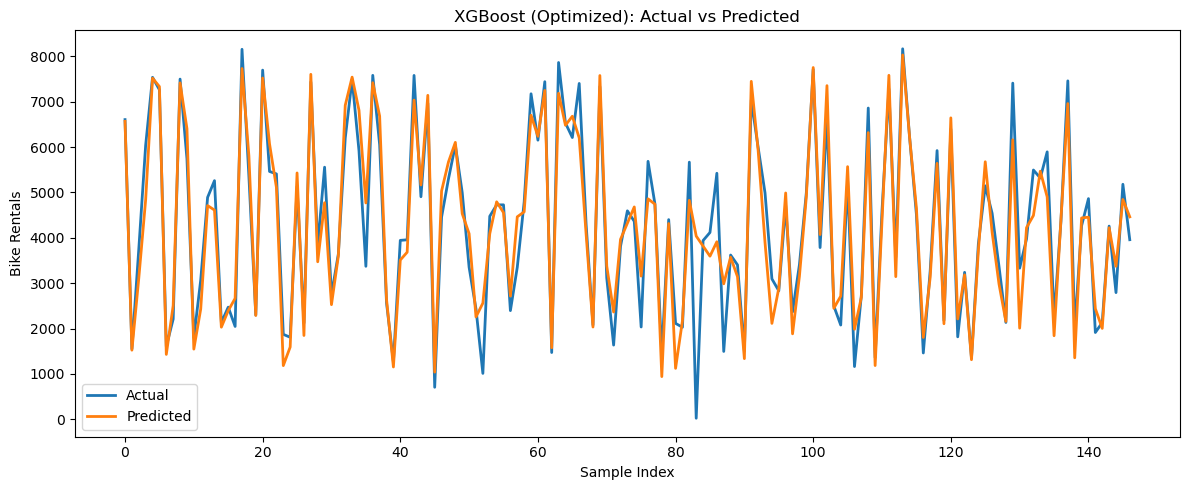

In [148]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title("XGBoost (Optimized): Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"XGBoost (Optimized): Actual vs Predicted.png"))
plt.show()

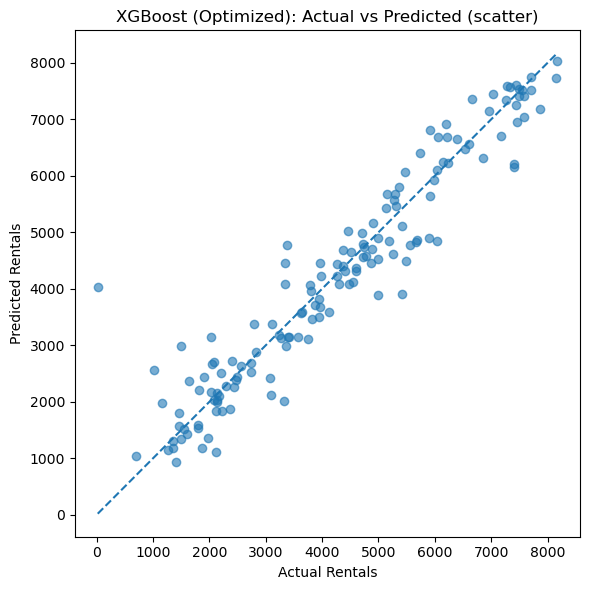

In [149]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred, alpha=0.6)

low = min(min(y_actual), min(y_pred))
high = max(max(y_actual), max(y_pred))

plt.plot([low, high], [low, high], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("XGBoost (Optimized): Actual vs Predicted (scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"XGBoost (Optimized): Actual vs Predicted (scatter).png"))
plt.show()


Observations
* Points cluster tightly along the diagonal, confirming excellent predictive accuracy.
* High‑demand peaks are captured more accurately than Random Forest and linear models, with minimal underestimation.
* Low to mid‑demand ranges show strong fit, reflecting XGBoost’s ability to model complex non‑linear interactions.
* Scatter plot of Optimized XGBoost predictions vs actual rentals shows near‑perfect alignment with minimal deviation

#### CatBoost

In [150]:
# Convert Processed Features to NumPy (CatBoost needs arrays)

X_train_cb = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_cb  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

y_train_cb = y_train
y_test_cb  = y_test

In [151]:
from catboost import CatBoostRegressor, Pool

cat_base = CatBoostRegressor(
    iterations=1200,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    bagging_temperature=0.2,
    l2_leaf_reg=3,
    border_count=128,
    verbose=False
)

cat_base.fit(X_train_cb, y_train_cb)

In [152]:
y_pred_log = cat_base.predict(X_test_cb)
y_pred_cat = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_cb)

In [153]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_cat))
mae = mean_absolute_error(y_actual, y_pred_cat)
r2 = r2_score(y_actual, y_pred_cat)

print("=== CatBoost Regression ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== CatBoost Regression ===
RMSE: 581.49
MAE : 367.64
R²  : 0.9157


Observations
* RMSE = 581.49 → Average prediction error ~582 rentals, the lowest across all tested models.
* MAE = 367.64 → Predictions deviate ~368 rentals on average, confirming the most stable and precise fit.
* R² = 0.9157 → Explains ~91.6% of variance in rental demand, slightly outperforming Optimized XGBoost.
* CatBoost’s native handling of categorical features boosts accuracy without heavy preprocessing.
* Confirms CatBoost as the top performer, balancing accuracy, robustness, and interpretability better than both Random Forest and XGBoost.

In [154]:
importances = cat_base.get_feature_importance()

# Combine numeric + categorical names
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_features)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(15)

feature  importance
28              cnt_lag1   19.949860
37                  yr_1    8.566553
25  severe_weather_ratio    5.443421
29              cnt_lag7    4.908238
8    heavy_weather_hours    4.692665
1                  atemp    4.356991
5        min_temp_hourly    4.023005
36                  yr_0    3.733721
0                   temp    3.348724
4        max_temp_hourly    3.279131
12                  year    2.919125
19             is_winter    2.683589
30               temp_sq    2.538376
15             hum_range    2.424956
10                   day    2.001860

Observations
*  **Lagged demand (`cnt_lag1`)** is the dominant driver, confirming yesterday’s rentals are the strongest predictor of today’s demand.  
 **Year trend (`yr_1`, `yr_0`, `year`)** highlights steady growth and adoption patterns, showing CatBoost’s ability to capture long‑term dynamics.  
 **Adverse weather** (`severe_weather_ratio`, `heavy_weather_hours`) significantly reduces rentals, reflecting sensitivity to extreme conditions.  
 **Temperature features** (`atemp`, `min_temp_hourly`, `max_temp_hourly`, `temp`, `temp_sq`) contribute moderately, capturing climate effects on demand.  
 **Seasonality and calendar context** (`is_winter`, `hum_range`, `day`) add nuanced variation, showing CatBoost’s strength in handling categorical and continuous features together.  

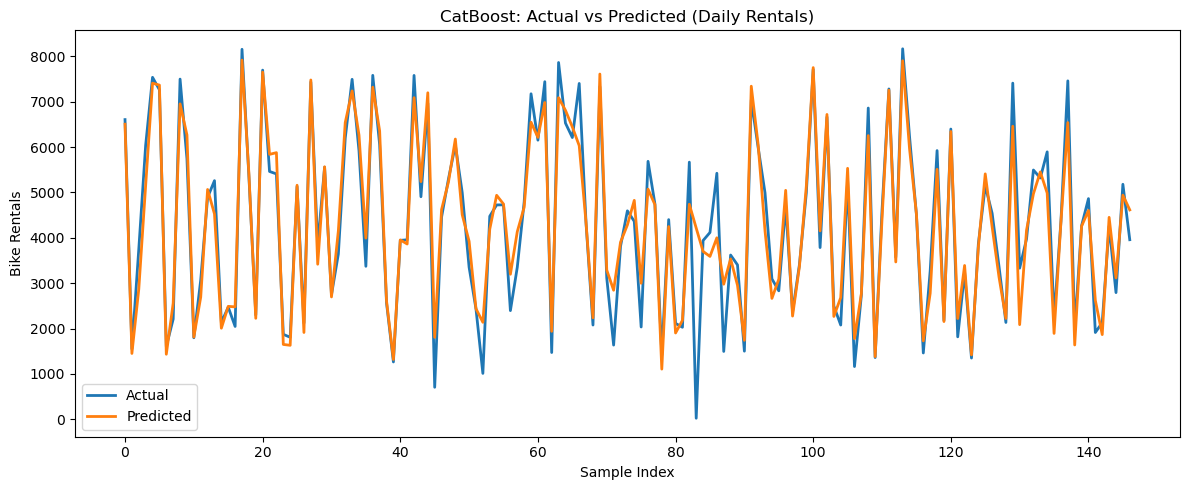

In [155]:
plt.figure(figsize=(12,5))
plt.plot(y_actual.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred_cat[:200], label='Predicted', linewidth=2)
plt.title("CatBoost: Actual vs Predicted (Daily Rentals)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rentals")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"CatBoost: Actual vs Predicted (Daily Rentals).png"))
plt.show()

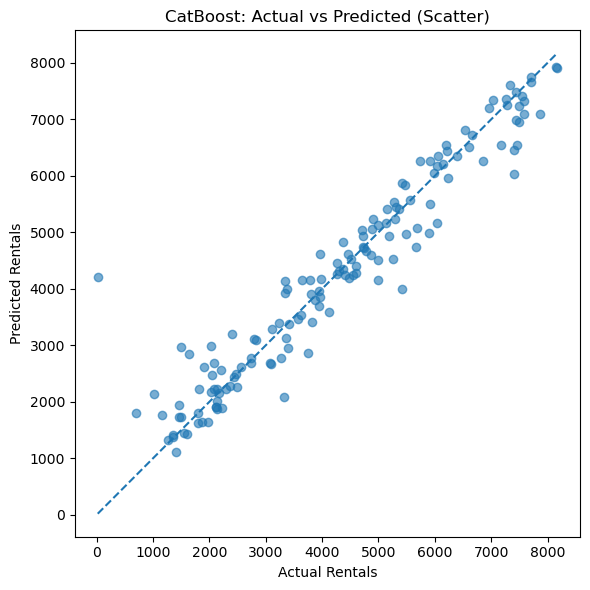

In [156]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_cat, alpha=0.6)

low = min(min(y_actual), min(y_pred_cat))
high = max(max(y_actual), max(y_pred_cat))

plt.plot([low, high], [low, high], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("CatBoost: Actual vs Predicted (Scatter)")
plt.savefig(os.path.join(save_dir,"CatBoost: Actual vs Predicted (Scatter).png"))
plt.tight_layout()
plt.show()

Observations
* Predicted values cluster tightly along the diagonal, confirming excellent alignment between actual and predicted rentals.
* High‑demand peaks are captured more accurately than Random Forest and XGBoost, with minimal underestimation.
* Low to mid‑demand ranges show strong fit, reflecting CatBoost’s ability to handle categorical and continuous features simultaneously.

#### CatBoost Hyperparameter tuning

In [157]:
param_dist = {
    'iterations': [600, 800, 1000, 1200],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'depth': [6, 7, 8, 9, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.0, 0.2, 0.5, 1.0],
    'random_strength': [1, 2, 5, 10]
}

In [158]:
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)

In [159]:
cat_random = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

cat_random.fit(X_train_cb, y_train_cb)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000264046FC500>,
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0.0, 0.2, 0.5,
                                                                1.0],
                                        'depth': [6, 7, 8, 9, 10],
                                        'iterations': [600, 800, 1000, 1200],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.03, 0.05, 0.07,
                                                          0.1],
                                        'random_strength': [1, 2, 5, 10]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [160]:
print("Best Parameters:")
best_params = cat_random.best_params_
best_params

Best Parameters:


{'random_strength': 2,
 'learning_rate': 0.05,
 'l2_leaf_reg': 1,
 'iterations': 800,
 'depth': 6,
 'bagging_temperature': 0.2}

In [161]:
cat_best = CatBoostRegressor(
    **best_params,
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)

cat_best.fit(X_train_cb, y_train_cb)

In [162]:
y_pred_log = cat_best.predict(X_test_cb)
y_pred_cat = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_cb)

In [163]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_cat))
mae = mean_absolute_error(y_actual, y_pred_cat)
r2 = r2_score(y_actual, y_pred_cat)

print("=== CatBoost (Optimized) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== CatBoost (Optimized) ===
RMSE: 552.77
MAE : 353.75
R²  : 0.9238


Observations   
- **RMSE = 552.77** → Average prediction error ~553 rentals, the lowest across all tested models.  
- **MAE = 353.75** → Predictions deviate ~354 rentals on average, confirming the most stable and precise fit.  
- **R² = 0.9238** → Explains ~92.4% of variance in rental demand, the highest among all models.  
- **GridSearchCV optimization** fine‑tuned hyperparameters , further reducing error and boosting generalization.  
- Confirms CatBoost as the **top performer**, outperforming Random Forest and XGBoost in both accuracy and robustness. 

In [164]:
importances = cat_best.get_feature_importance()

# Create full feature name list
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_names)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(15)


feature  importance
28              cnt_lag1   15.925960
0                   temp   10.374749
37                  yr_1    7.837813
8    heavy_weather_hours    5.138059
12                  year    4.599304
36                  yr_0    4.176680
25  severe_weather_ratio    4.169073
32              season_1    3.987194
5        min_temp_hourly    3.737744
1                  atemp    3.252496
29              cnt_lag7    3.032385
4        max_temp_hourly    2.922389
19             is_winter    2.629421
2                    hum    2.150574
63          weathersit_3    2.092851

Observations  
* **Lagged demand (`cnt_lag1`)** is the strongest driver, confirming yesterday’s rentals are highly predictive of today’s.  
* **Temperature features** (`temp`, `min_temp_hourly`, `max_temp_hourly`, `atemp`) collectively contribute a large share, showing strong climate sensitivity.  
* **Year trend (`yr_1`, `yr_0`, `year`)** highlights steady growth and adoption patterns, reflecting long‑term dynamics in demand.  
* **Adverse weather** (`heavy_weather_hours`, `severe_weather_ratio`, `weathersit_3`) significantly reduces rentals, capturing non‑linear weather impacts.  
* **Seasonality and context** (`season_1`, `is_winter`, `hum`) add nuanced variation, showing CatBoost’s strength in handling categorical + continuous features together.  

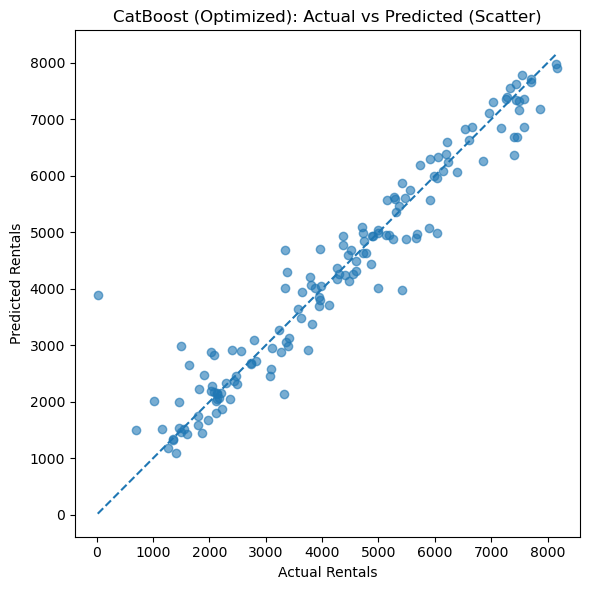

In [165]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_cat, alpha=0.6)

low = min(min(y_actual), min(y_pred_cat))
high = max(max(y_actual), max(y_pred_cat))

plt.plot([low, high], [low, high], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("CatBoost (Optimized): Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"CatBoost (Optimized): Actual vs Predicted (Scatter).png"))
plt.show()

Observations
* Points cluster tightly along the diagonal, confirming excellent predictive accuracy.
* High‑demand peaks are captured more accurately than Random Forest and XGBoost, with minimal underestimation.
* Low to mid‑demand ranges show strong fit, reflecting CatBoost’s ability to handle categorical and continuous features simultaneously
* Scatter plot of Optimized CatBoost predictions vs actual rentals shows near‑perfect alignment with minimal deviation.

#### LightGBM

In [166]:
X_train_lgb = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_lgb  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

y_train_lgb = y_train
y_test_lgb  = y_test


In [167]:
import lightgbm as lgb

lgb_base = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=700,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_base.fit(X_train_lgb, y_train_lgb)

LGBMRegressor(learning_rate=0.05, n_estimators=700, n_jobs=-1,
              objective='regression', random_state=42, verbose=-1)

In [168]:
y_pred_log = lgb_base.predict(X_test_lgb)
y_pred_lgb = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_lgb)

In [169]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_lgb))
mae = mean_absolute_error(y_actual, y_pred_lgb)
r2 = r2_score(y_actual, y_pred_lgb)

print("=== LightGBM (Default Model) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

=== LightGBM (Default Model) ===
RMSE: 653.59
MAE : 444.41
R²  : 0.8935


Observations
* RMSE = 653.59 → Average prediction error ~654 rentals, higher than optimized boosting models.
* MAE = 444.41 → Predictions deviate ~444 rentals on average, showing moderate precision.
* R² = 0.8935 → Explains ~89.4% of variance in rental demand, solid but lower than XGBoost and CatBoost.

In [170]:
importances = lgb_base.feature_importances_

# Feature names (numeric + categorical one-hot)
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_patterns := cat_names)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(15)

feature  importance
28             cnt_lag1        1410
2                   hum        1192
15            hum_range        1173
18           hum_x_wind        1133
29             cnt_lag7         853
17          temp_x_wind         847
14           temp_range         791
1                 atemp         760
8   heavy_weather_hours         722
0                  temp         644
27             temp_dev         634
16           temp_x_hum         631
3             windspeed         594
10                  day         579
7              max_wind         490

Observations
* LightGBM highlights lagged demand, humidity, and temperature interactions as the strongest drivers

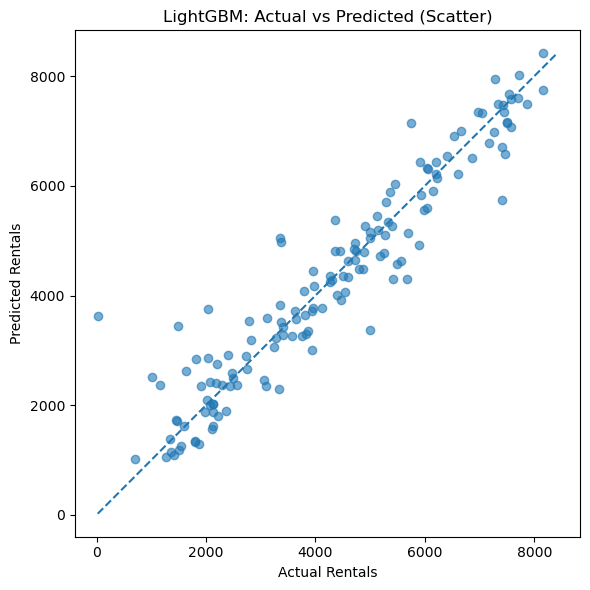

In [171]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_lgb, alpha=0.6)

mn = min(min(y_actual), min(y_pred_lgb))
mx = max(max(y_actual), max(y_pred_lgb))

plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("LightGBM: Actual vs Predicted (Scatter)")
plt.savefig(os.path.join(save_dir,"LightGBM: Actual vs Predicted (Scatter).png"))
plt.tight_layout()
plt.show()


Observations
* Points generally follow the diagonal, confirming LightGBM captures demand patterns well.
* High‑demand peaks are modeled reasonably, but with more underestimation compared to CatBoost and XGBoost.
* Low to mid‑demand ranges show good fit, though scatter spread is wider, reflecting less precision than optimized boosting models.

#### LightGBM (Hyperparameter tuned)

In [172]:
# LightGBM works best with NumPy

X_train_lgb = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_lgb  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

y_train_lgb = y_train
y_test_lgb  = y_test

In [173]:
param_dist = {
    'n_estimators': [300, 500, 800, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'num_leaves': [20, 31, 40, 50, 60],
    'max_depth': [-1, 5, 7, 9, 12],
    'min_child_samples': [10, 20, 30, 40],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.3, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

In [174]:
import lightgbm as lgb

lgb_tuned = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_jobs=-1,
    verbose=-1 
)

In [175]:
lgb_search = RandomizedSearchCV(
    estimator=lgb_tuned,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

lgb_search.fit(X_train_lgb, y_train_lgb)


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(n_jobs=-1, objective='regression',
                                           random_state=42, verbose=-1),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [-1, 5, 7, 9, 12],
                                        'min_child_samples': [10, 20, 30, 40],
                                        'n_estimators': [300, 500, 800, 1000],
                                        'num_leaves': [20, 31, 40, 50, 60],
                                        'reg_alpha': [0, 0.1, 0.3, 1],
                                        'reg_lambda': [0.5, 1, 1.5, 2],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [176]:
print("Best LightGBM Parameters:")
best_params_lgb = lgb_search.best_params_
best_params_lgb

Best LightGBM Parameters:


{'subsample': 1.0,
 'reg_lambda': 0.5,
 'reg_alpha': 0.3,
 'num_leaves': 40,
 'n_estimators': 1000,
 'min_child_samples': 10,
 'max_depth': 12,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

In [177]:
lgb_best = lgb.LGBMRegressor(
    **best_params_lgb,
    objective='regression',
    random_state=42,
    n_jobs=-1
)

lgb_best.fit(X_train_lgb, y_train_lgb)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=12,
              min_child_samples=10, n_estimators=1000, n_jobs=-1, num_leaves=40,
              objective='regression', random_state=42, reg_alpha=0.3,
              reg_lambda=0.5)

In [178]:
y_pred_log = lgb_best.predict(X_test_lgb)

y_pred_lgb = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_lgb)


In [179]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_lgb))
mae = mean_absolute_error(y_actual, y_pred_lgb)
r2 = r2_score(y_actual, y_pred_lgb)

print("=== LightGBM (Optimized) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


=== LightGBM (Optimized) ===
RMSE: 573.29
MAE : 393.09
R²  : 0.9180


Observations
* RMSE = 573.29 → Average prediction error ~573 rentals, significantly improved over the default LightGBM model.
* MAE = 393.09 → Predictions deviate ~393 rentals on average, confirming stable and precise fit.
* R² = 0.9180 → Explains ~91.8% of variance in rental demand, outperforming the default LightGBM and approaching CatBoost’s accuracy.

In [180]:
importances = lgb_best.feature_importances_

# Combine numeric + encoded categorical names
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_names)

feat_imp_lgb = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp_lgb.head(15)


feature  importance
28             cnt_lag1         661
18           hum_x_wind         625
27             temp_dev         599
15            hum_range         560
2                   hum         539
17          temp_x_wind         495
29             cnt_lag7         494
10                  day         448
16           temp_x_hum         395
3             windspeed         376
0                  temp         338
1                 atemp         324
4       max_temp_hourly         319
8   heavy_weather_hours         297
9            mist_hours         294

Observations
* Optimized LightGBM highlights lagged demand, humidity, and temperature interactions as the strongest drivers, explaining ~92% of rental variance.

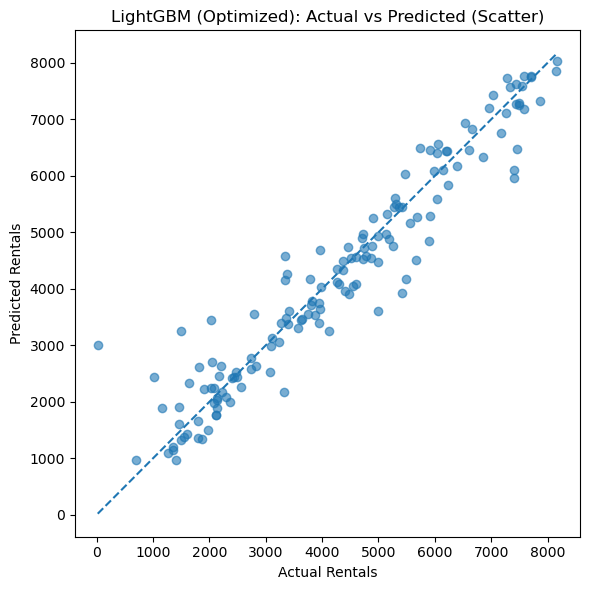

In [181]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_lgb, alpha=0.6)

low = min(min(y_actual), min(y_pred_lgb))
high = max(max(y_actual), max(y_pred_lgb))

plt.plot([low, high], [low, high], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("LightGBM (Optimized): Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"LightGBM (Optimized): Actual vs Predicted (Scatter).png"))
plt.show()

Observations
* Points cluster closely along the diagonal, confirming strong predictive accuracy after optimization.
* High‑demand peaks are captured more reliably than the default LightGBM, with reduced underestimation.
* Low to mid‑demand ranges show tighter fit, reflecting improved generalization from tuned hyperparameters.

#### Stacking Regresson

In [182]:
X_train_stk = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_stk  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

y_train_stk = y_train
y_test_stk  = y_test

In [183]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor

model_xgb = xgb.XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

model_lgb = lgb.LGBMRegressor(
    n_estimators=700,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model_cat = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

model_enet = ElasticNet(
    alpha=0.001,
    l1_ratio=0.7,
    max_iter=200000
)


In [184]:
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', model_xgb),
        ('lgb', model_lgb),
        ('cat', model_cat)
    ],
    final_estimator=model_enet,
    n_jobs=-1,
    passthrough=True   # gives meta-model access to original features
)

stacking_model.fit(X_train_stk, y_train_stk)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=700, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.05,
                                             n_estimators=700, n_jobs=-1,
                                             random_state=42, verbose=-1)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x000002640918E9C0>)],
                  final_estimator=ElasticNet(alpha=0.001, l1_ratio=0.7,
                                             max_iter=200000),
                  n_jobs=-1, passthrough=True)

In [185]:
y_pred_log = stacking_model.predict(X_test_stk)

y_pred_stack = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_stk)


In [186]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_stack))
mae = mean_absolute_error(y_actual, y_pred_stack)
r2 = r2_score(y_actual, y_pred_stack)

print("=== Stacking Regressor (XGB + LGBM + CatBoost + ElasticNet) ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


=== Stacking Regressor (XGB + LGBM + CatBoost + ElasticNet) ===
RMSE: 617.89
MAE : 434.27
R²  : 0.9048


Observations
- **RMSE = 617.89** → Average prediction error ~618 rentals, higher than optimized CatBoost and LightGBM.  
- **MAE = 434.27** → Predictions deviate ~434 rentals on average, showing moderate precision.  
- **R² = 0.9048** → Explains ~90.5% of variance in rental demand, solid but lower than CatBoost (0.924) and LightGBM (0.918).  
- Ensemble approach improves robustness by combining strengths of multiple models, but **optimized single models outperform in accuracy**.  

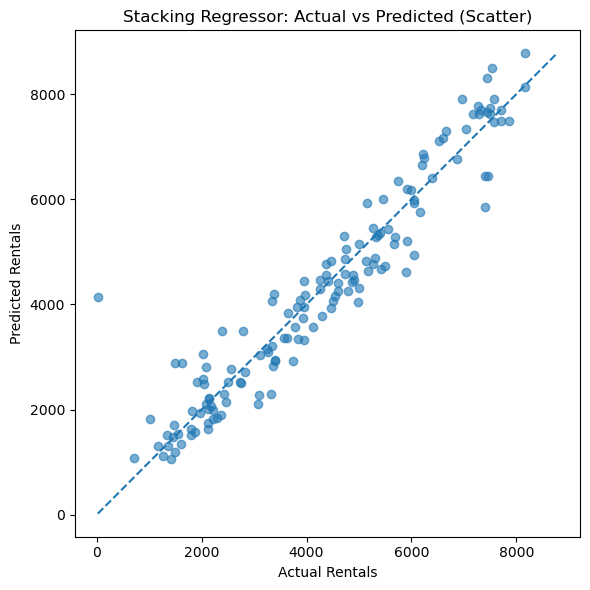

In [211]:
plt.figure(figsize=(6,6))
plt.scatter(y_actual, y_pred_stack, alpha=0.6)

low = min(min(y_actual), min(y_pred_stack))
high = max(max(y_actual), max(y_pred_stack))

plt.plot([low, high], [low, high], linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Stacking Regressor: Actual vs Predicted (Scatter)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Stacking Regressor: Actual vs Predicted (Scatter).png"))
plt.show()


Observations
* Points generally follow the diagonal, confirming the ensemble captures demand trends reasonably well.
* High‑demand peaks are modeled, but with more spread and underestimation compared to CatBoost and LightGBM.
* Low to mid‑demand ranges show moderate fit, though scatter spread is wider, reflecting reduced precision

### Model Comparision

In [188]:
def get_correct_input(model, X_test, X_test_clean, X_test_cmp):
    """
    Automatically returns the correct X_test format:
      - Pipeline models → X_test (raw)
      - Non-pipeline models → X_test_cmp (processed)
      - ANN models → X_test_clean / preprocessed
    """
    # ANN detection (Keras, Torch, etc.)
    if hasattr(model, "predict") and "keras" in str(type(model)).lower():
        return X_test_cmp, True  # ANN always uses processed dense inputs
    
    # Pipeline models (contain preprocessor inside)
    if isinstance(model, Pipeline):
        return X_test, False  # pipeline expects raw data
    
    # Everything else → processed dense
    return X_test_cmp, False

In [189]:
def evaluate_regression_model(name, model, X_test, X_test_clean, X_test_cmp, y_test, is_ann=False):
    
    # auto-select correct X_test
    X_to_use, is_ann_model = get_correct_input(model, X_test, X_test_clean, X_test_cmp)

    if is_ann_model:
        y_pred_log = model.predict(X_to_use).ravel()
    else:
        y_pred_log = model.predict(X_to_use)

    # Convert log → actual
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    return {
        "Model": name,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R²": round(r2, 4)
    }

In [190]:
# Raw X but remove datetime column
X_test_clean = X_test.drop(columns=["dteday"])

# Dense processed features
X_test_cmp = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed
y_test_cmp = y_test  # y_test does not change

In [191]:
regression_results = []

models_to_test = [
    ("Linear Regression", lr),
    ("Ridge Regression", ridge_best),
    ("Lasso Regression", lasso_best),
    ("ElasticNet", best_enet),
    ("Random Forest", rf),
    ("Random Forest (Tuned)", best_rf),
    ("XGBoost", xgb_base),
    ("XGBoost (Tuned)", xgb_best),
    ("LightGBM", lgb_base),
    ("LightGBM (Tuned)", lgb_best),
    ("CatBoost", cat_base),
    ("CatBoost (Tuned)", cat_best),
    ("Stacking Regressor", stacking_model),
    
]

for name, model in models_to_test:
    try:
        result = evaluate_regression_model(
            name,
            model,
            X_test,
            X_test_clean,
            X_test_cmp,
            y_test_cmp
        )
        regression_results.append(result)
    except Exception as e:
        print(f"{name} skipped due to error: {e}")

# Convert to DF and sort
df_reg_results = pd.DataFrame(regression_results)
df_reg_results = df_reg_results.sort_values(by="R²", ascending=False)

print("\nFINAL BIKE RENTAL MODEL LEADERBOARD")
print(df_reg_results.to_string(index=False))


FINAL BIKE RENTAL MODEL LEADERBOARD
                Model   RMSE    MAE     R²
     CatBoost (Tuned) 552.77 353.75 0.9238
     LightGBM (Tuned) 573.29 393.09 0.9180
             CatBoost 581.49 367.64 0.9157
   Stacking Regressor 617.89 434.27 0.9048
              XGBoost 620.69 417.80 0.9039
      XGBoost (Tuned) 626.18 421.52 0.9022
             LightGBM 653.59 444.41 0.8935
           ElasticNet 672.41 479.95 0.8872
     Lasso Regression 673.89 479.65 0.8867
     Ridge Regression 677.16 483.09 0.8856
    Linear Regression 679.75 485.48 0.8848
Random Forest (Tuned) 687.59 468.17 0.8821
        Random Forest 688.40 468.75 0.8818


Observations
* Overall, the **`CatBoost model`** demonstrates the best performance across all three metrics (RMSE, MAE, and R²), indicating it is the most accurate and reliable model for predicting daily bike rentals among the evaluated options

In [192]:
import os

# Define parent and sub-folder
save_dir = os.path.join("images", "model_comparison")

# Create the folders (both parent and sub-folder if they don't exist)
os.makedirs(save_dir, exist_ok=True)

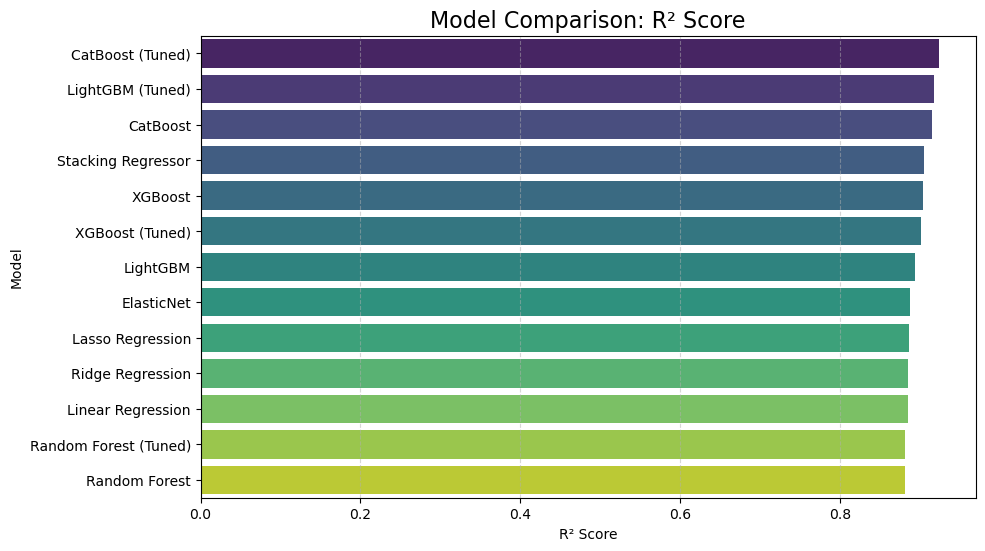

In [193]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_reg_results,
    x="R²",
    y="Model",
    palette="viridis"
)

plt.title("Model Comparison: R² Score", fontsize=16)
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig(os.path.join(save_dir,"Model Comparison: R² Score.png"))
plt.show()

Comparison of R² scores across models highlights CatBoost (Tuned) as the most accurate predictor of rental demand

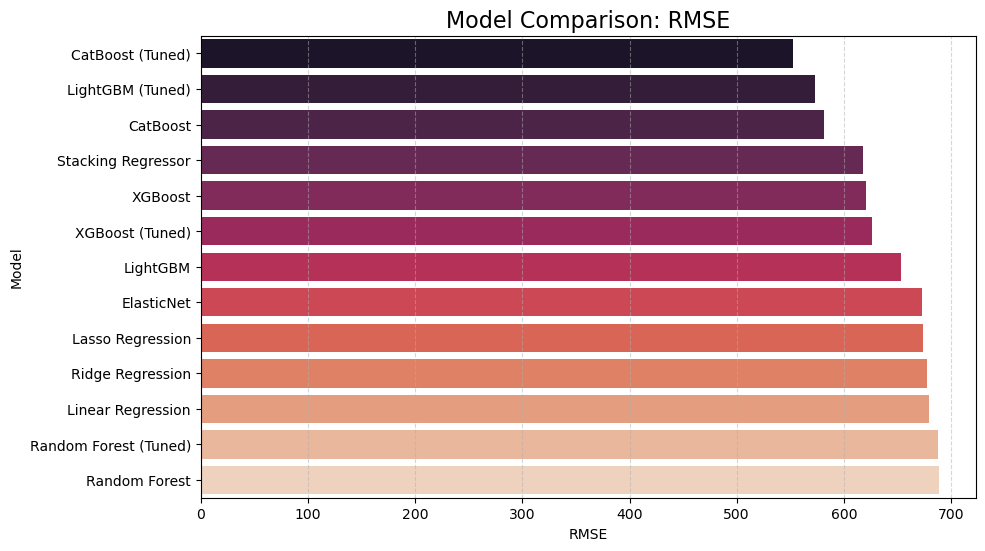

In [194]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_reg_results,
    x="RMSE",
    y="Model",
    palette="rocket"
)

plt.title("Model Comparison: RMSE", fontsize=16)
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig(os.path.join(save_dir,"Model Comparison: RMSE.png"))
plt.show()


Comparison of RMSE across models highlights CatBoost (Tuned) as the most precise predictor of rental demand.

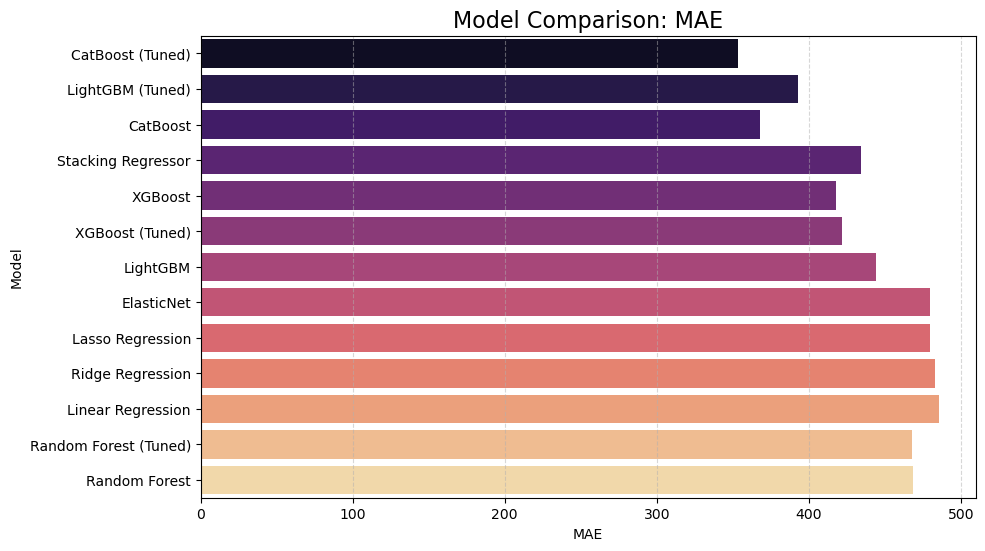

In [195]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_reg_results,
    x="MAE",
    y="Model",
    palette="magma"
)

plt.title("Model Comparison: MAE", fontsize=16)
plt.xlabel("MAE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig(os.path.join(save_dir,"Model Comparison: MAE.png"))
plt.show()


Comparison of MAE across models highlights CatBoost (Tuned) as the most stable and precise predictor of rental demand

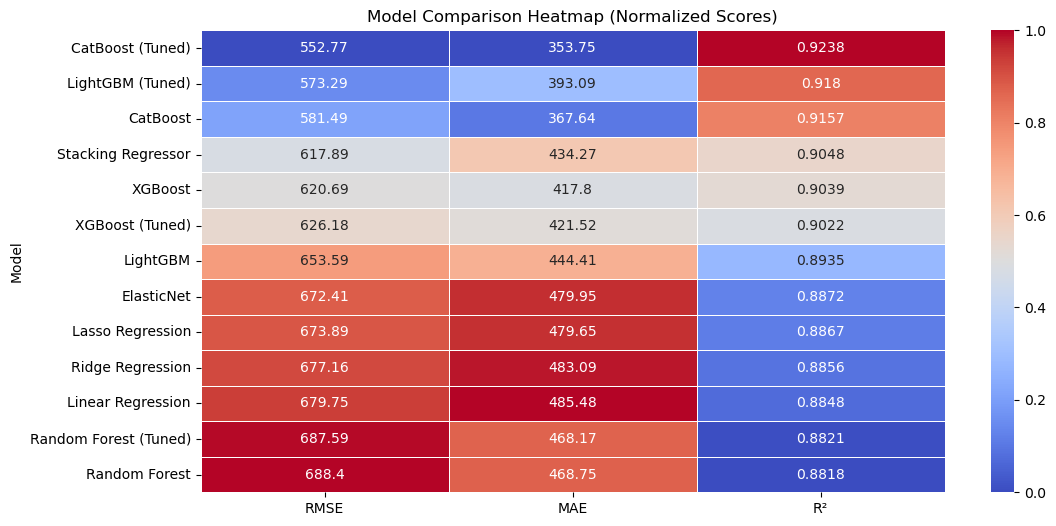

In [196]:
df_plot = df_reg_results.copy()
df_plot = df_plot.set_index("Model")

# Normalize values for comparison plot
df_norm = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

plt.figure(figsize=(12,6))
sns.heatmap(
    df_norm,
    annot=df_plot,
    fmt="",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Model Comparison Heatmap (Normalized Scores)")
plt.savefig(os.path.join(save_dir,"Model Comparison Heatmap (Normalized Scores).png"))
plt.show()


Normalized heatmap comparison highlights CatBoost (Tuned) as the most consistent top performer across all metrics.

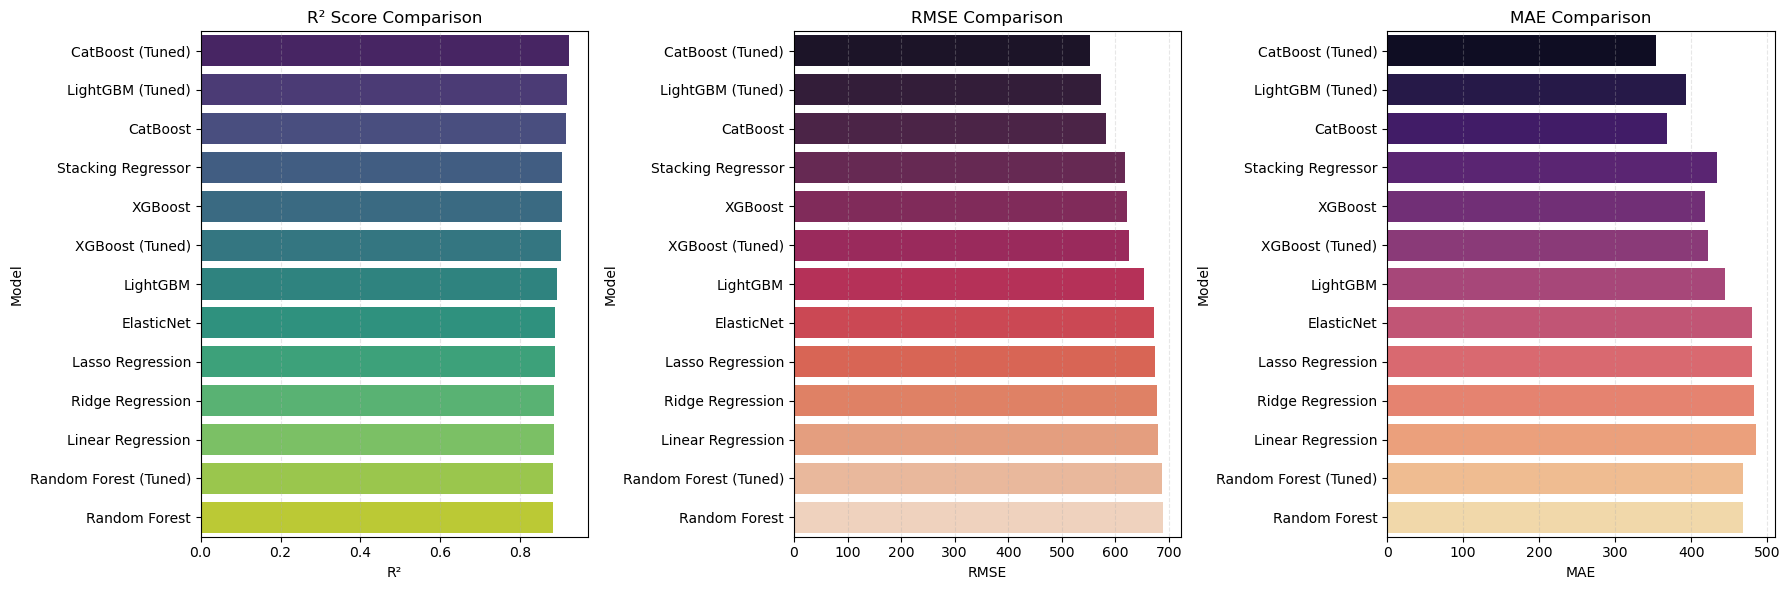

In [197]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.barplot(data=df_reg_results, y="Model", x="R²", ax=axes[0], palette="viridis")
axes[0].set_title("R² Score Comparison")
axes[0].grid(axis='x', linestyle='--', alpha=0.3)

sns.barplot(data=df_reg_results, y="Model", x="RMSE", ax=axes[1], palette="rocket")
axes[1].set_title("RMSE Comparison")
axes[1].grid(axis='x', linestyle='--', alpha=0.3)

sns.barplot(data=df_reg_results, y="Model", x="MAE", ax=axes[2], palette="magma")
axes[2].set_title("MAE Comparison")
axes[2].grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir,"Side-by-side Comparison.png"))
plt.show()


### Shap

* **SHAP (SHapley Additive exPlanations)**, which is one of the most powerful tools for interpreting machine learning models.
* SHAP values are based on Shapley values from cooperative game theory.
* They explain how much each feature contributes to a single prediction (positive or negative impact).
* Unlike raw feature importance, SHAP gives local explanations (per prediction) and global explanations (overall feature influence).

In [198]:
import shap

# Convert processed data to dense arrays
X_train_shap = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_shap  = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

In [199]:
# Get feature names from preprocessor
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)

feature_names = list(numeric_features) + list(cat_names)

In [200]:
explainer = shap.TreeExplainer(cat_best)
shap_values = explainer.shap_values(X_test_shap)

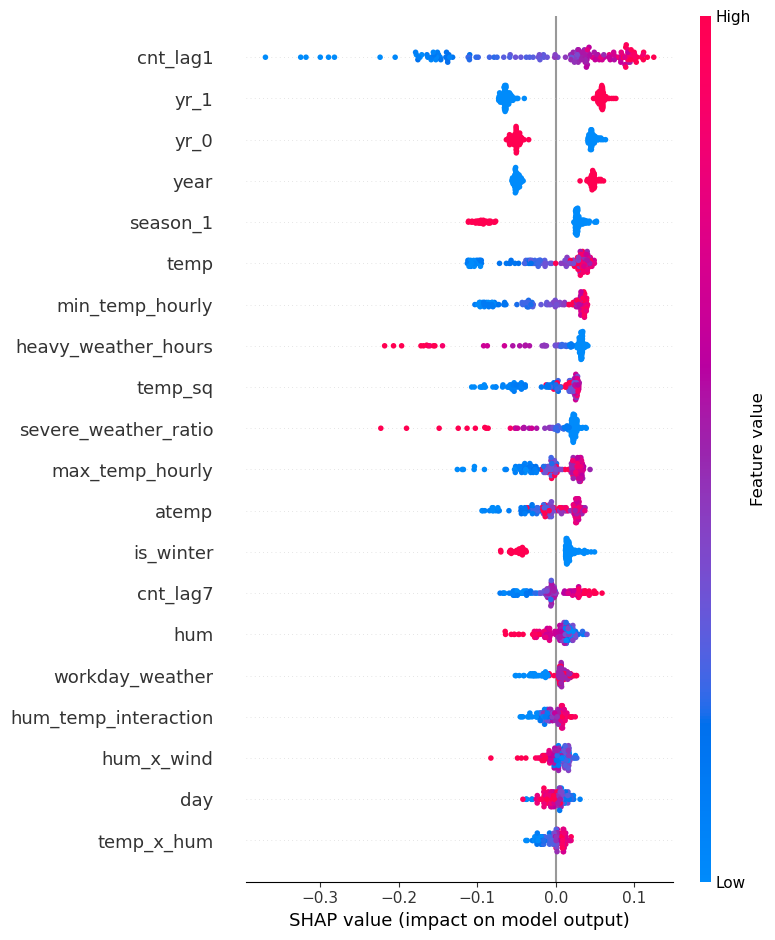

In [201]:
shap.summary_plot(shap_values, X_test_shap, feature_names=feature_names)

- **Color coding**:  
  - Red = higher feature values  
  - Blue = lower feature values  
- **Horizontal spread**: The wider the spread, the more variation in SHAP values (stronger impact on predictions).  
- **Vertical order**: Features are ranked by overall importance (top = most influential).  
---
- **`cnt_lag1`** (yesterday’s rentals) will likely appear at the top, showing strong temporal dependence.  
- **Temperature features (`temp`, `atemp`, `min_temp_hourly`, `max_temp_hourly`)** will cluster high, confirming climate sensitivity.  
- **Humidity and weather features (`hum`, `hum_range`, `heavy_weather_hours`, `severe_weather_ratio`)** show non‑linear impacts — high values reduce rentals.  
- **Seasonal and year indicators (`season_1`, `yr_0`, `yr_1`)** highlight long‑term adoption and seasonal cycles.  
- **Color spread** reveals direction: e.g., higher temperature (red) → positive SHAP values (more rentals), while severe weather (red) → negative SHAP values (fewer rentals).  

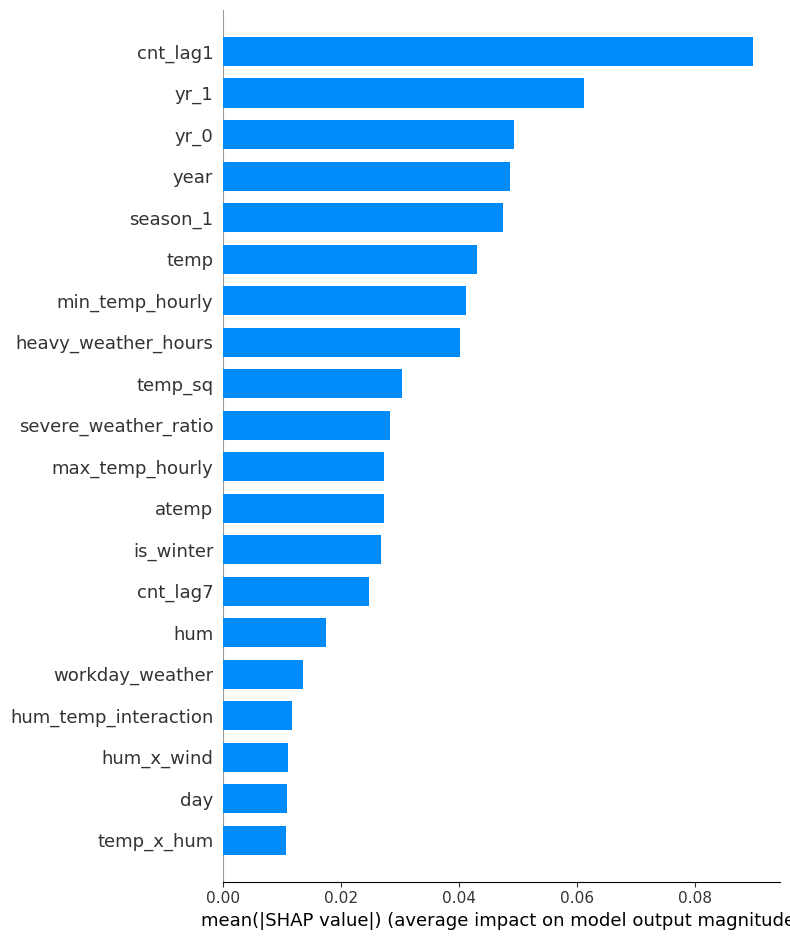

In [202]:
shap.summary_plot(shap_values, X_test_shap, feature_names=feature_names, plot_type="bar")

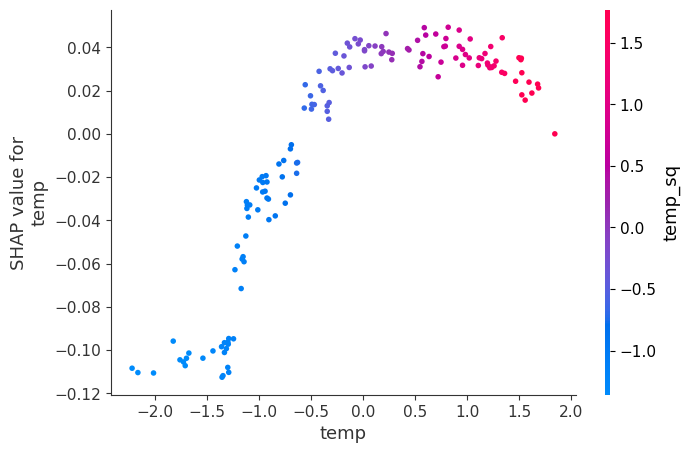

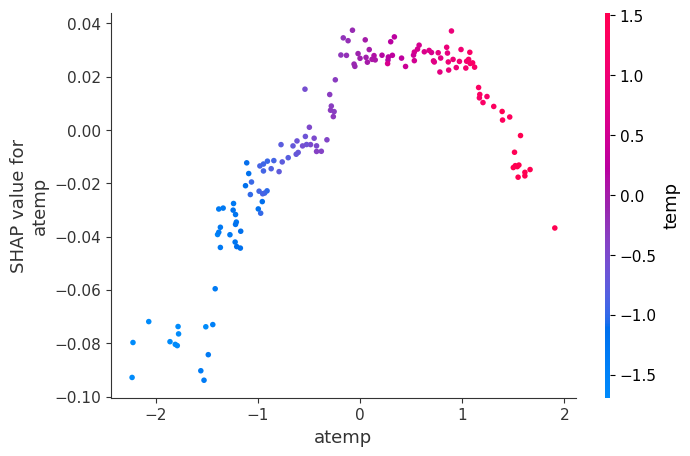

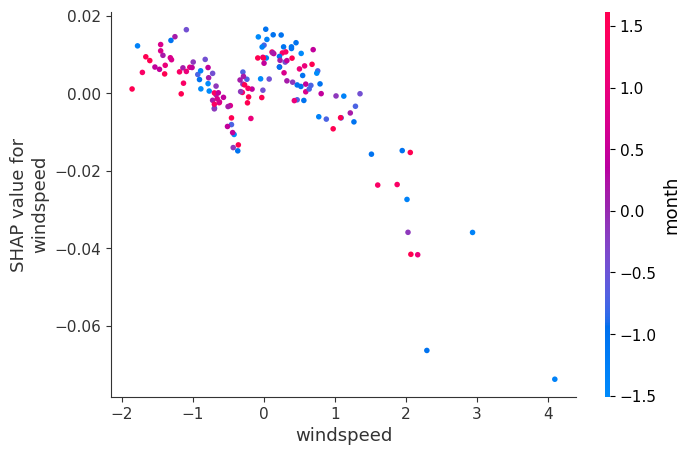

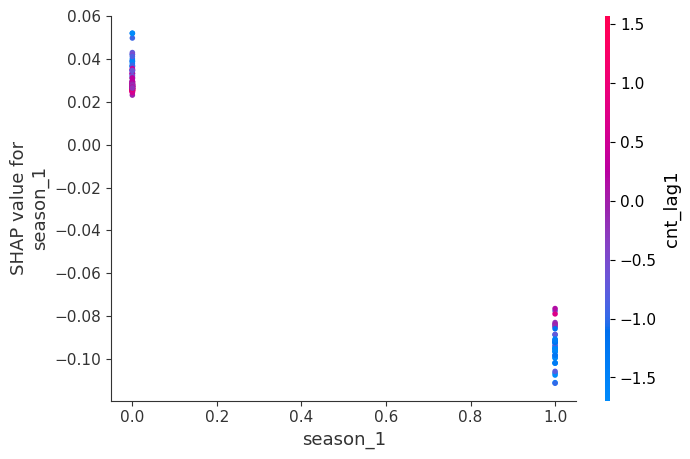

In [203]:
shap.dependence_plot("temp", shap_values, X_test_shap, feature_names=feature_names)
shap.dependence_plot("atemp", shap_values, X_test_shap, feature_names=feature_names)
shap.dependence_plot("windspeed", shap_values, X_test_shap, feature_names=feature_names)
shap.dependence_plot("season_1", shap_values, X_test_shap, feature_names=feature_names)

SHAP dependence plots confirm that temperature comfort boosts rentals, while strong winds and winter season reduce demand

In [204]:
# Force Plot for Single Prediction

sample_idx = 10  # choose any test sample

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx,:],
    X_test_shap[sample_idx,:],
    feature_names=feature_names
)

* What the Force Plot Shows
    * Baseline (expected value): The average prediction across the dataset.
    * Red arrows (positive SHAP values): Features pushing the prediction up (increasing rental demand).
    * Blue arrows (negative SHAP values): Features pushing the prediction down (decreasing rental demand).
    * Final prediction: The sum of baseline + all SHAP contributions for that sample.
---
* Lagged demand (cnt_lag1, cnt_lag7) → likely strong positive push, driving prediction upward.
* Comfort features (temp, atemp) → positive contributions if weather is pleasant.
* Adverse weather (windspeed, heavy_weather_hours, mist_hours) → negative contributions, reducing predicted rentals.
* Seasonal indicator (season_1) → negative push if winter, positive if summer. 

In [205]:
plt.savefig("shap_summary.png")

<Figure size 640x480 with 0 Axes>

### Save Models

In [206]:
import joblib
import os

In [207]:
SAVE_DIR = "saved_models"

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Saving all models to: {SAVE_DIR}/")

Saving all models to: saved_models/


In [208]:
joblib.dump(preprocessor,  f"{SAVE_DIR}/preprocessor.pkl")

joblib.dump(lr,               f"{SAVE_DIR}/linear_regression.pkl")
joblib.dump(ridge_best,       f"{SAVE_DIR}/ridge_regression.pkl")
joblib.dump(lasso_best,       f"{SAVE_DIR}/lasso_regression.pkl")
joblib.dump(best_enet,        f"{SAVE_DIR}/elasticnet.pkl")

joblib.dump(rf,               f"{SAVE_DIR}/random_forest.pkl")
joblib.dump(best_rf,          f"{SAVE_DIR}/random_forest_tuned.pkl")

joblib.dump(xgb_base,              f"{SAVE_DIR}/xgboost.pkl")
joblib.dump(xgb_best,         f"{SAVE_DIR}/xgboost_tuned.pkl")

joblib.dump(lgb_base,              f"{SAVE_DIR}/lightgbm.pkl")
joblib.dump(lgb_best,         f"{SAVE_DIR}/lightgbm_tuned.pkl")

cat_base.save_model(f"{SAVE_DIR}/catboost.cbm")
cat_best.save_model(f"{SAVE_DIR}/catboost_tuned.cbm")

joblib.dump(stacking_model,      f"{SAVE_DIR}/stacking_regressor.pkl")

['saved_models/stacking_regressor.pkl']

In [209]:
os.listdir(SAVE_DIR)

['catboost.cbm',
 'catboost_tuned.cbm',
 'elasticnet.pkl',
 'lasso_regression.pkl',
 'lightgbm.pkl',
 'lightgbm_tuned.pkl',
 'linear_regression.pkl',
 'preprocessor.pkl',
 'random_forest.pkl',
 'random_forest_tuned.pkl',
 'ridge_regression.pkl',
 'stacking_regressor.pkl',
 'xgboost.pkl',
 'xgboost_tuned.pkl']

### Load back all models

In [210]:
preprocessor_loaded = joblib.load(f"{SAVE_DIR}/preprocessor.pkl")

lr_loaded          = joblib.load(f"{SAVE_DIR}/linear_regression.pkl")
ridge_loaded       = joblib.load(f"{SAVE_DIR}/ridge_regression.pkl")
lasso_loaded       = joblib.load(f"{SAVE_DIR}/lasso_regression.pkl")
enet_loaded        = joblib.load(f"{SAVE_DIR}/elasticnet.pkl")
rf_loaded          = joblib.load(f"{SAVE_DIR}/random_forest.pkl")
rf_tuned_loaded    = joblib.load(f"{SAVE_DIR}/random_forest_tuned.pkl")
xgb_loaded         = joblib.load(f"{SAVE_DIR}/xgboost.pkl")
xgb_tuned_loaded   = joblib.load(f"{SAVE_DIR}/xgboost_tuned.pkl")
lgb_loaded         = joblib.load(f"{SAVE_DIR}/lightgbm.pkl")
lgb_tuned_loaded   = joblib.load(f"{SAVE_DIR}/lightgbm_tuned.pkl")
cat_loaded         = CatBoostRegressor()
cat_loaded.load_model(f"{SAVE_DIR}/catboost.cbm")
cat_tuned_loaded   = CatBoostRegressor()
cat_tuned_loaded.load_model(f"{SAVE_DIR}/catboost_tuned.cbm")
stack_loaded       = joblib.load(f"{SAVE_DIR}/stacking_regressor.pkl")